In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import CategoricalNB, MultinomialNB, GaussianNB, BernoulliNB
from imblearn.pipeline import make_pipeline
from umap import UMAP
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)


Train Test Split

In [8]:
df = pd.read_csv(r'project_data\train.csv', sep=',')
df = df.drop(columns='readmitted_multiclass') #drop multiclass, this notebook is for binary
df = df.set_index(df['encounter_id']).drop(columns='encounter_id') #set encounter id as index
y = df['readmitted_binary'] #split in X and y
X = df.drop(columns = 'readmitted_binary')

In [9]:
y.value_counts() / y.shape[0] #class imbalance ~9:1

readmitted_binary
No     0.888399
Yes    0.111601
Name: count, dtype: float64

In [10]:

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, 
                                                  random_state = 0,
                                                  stratify = y, 
                                                  shuffle = True)

X_train_id = X_train.index #save indicies for later on
X_val_id = X_val.index

In [11]:
X_train.head()

country  patient_id             race  gender      age    weight  \
encounter_id                                                                   
898739           USA    23353470  AfricanAmerican  Female  [70-80)         ?   
985943           USA    33496749        Caucasian    Male  [60-70)         ?   
386470           USA    61844211        Caucasian    Male  [70-80)  [75-100)   
205429           USA    41436810        Caucasian  Female  [70-80)         ?   
544009           USA    11472570        Caucasian    Male      NaN         ?   

             payer_code  outpatient_visits_in_previous_year  \
encounter_id                                                  
898739               MC                                   0   
985943               MC                                   0   
386470               MC                                   0   
205429               MC                                   0   
544009                ?                                   0   

              emergency_visits_in_previous_year  \
encounter_id                                      
898739                                        1   
985943                                        0   
386470                                        0   
205429                                        0   
544009                                        0   

              inpatient_visits_in_previous_year  ... number_of_medications  \
encounter_id                                     ...                         
898739                                        1  ...                    21   
985943                                        0  ...                    24   
386470                                        1  ...                    10   
205429                                        1  ...                    22   
544009                                        1  ...                    19   

             primary_diagnosis  secondary_diagnosis additional_diagnosis  \
encounter_id                                                               
898739                     531                  599                  280   
985943                     275                  203                  428   
386470                     431                  428                  427   
205429                     805                  805                  428   
544009                     557                  428                  425   

             number_diagnoses  glucose_test_result  a1c_test_result  \
encounter_id                                                          
898739                      9                  NaN              NaN   
985943                      9                  NaN              NaN   
386470                      9                  NaN              NaN   
205429                      9                  NaN              NaN   
544009                      9                  NaN               >8   

              change_in_meds_during_hospitalization  prescribed_diabetes_meds  \
encounter_id                                                                    
898739                                           Ch                       Yes   
985943                                           Ch                       Yes   
386470                                           No                        No   
205429                                           No                       Yes   
544009                                           No                        No   

                               medication  
encounter_id                               
898739                        ['insulin']  
985943        ['pioglitazone', 'insulin']  
386470                                 []  
205429                      ['glipizide']  
544009                                 []  

[5 rows x 28 columns]

EDA Basics

In [12]:
X_train.select_dtypes(include=np.number).info() #no NAs for numerics

<class 'pandas.core.frame.DataFrame'>
Index: 56988 entries, 898739 to 788870
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   patient_id                          56988 non-null  int64
 1   outpatient_visits_in_previous_year  56988 non-null  int64
 2   emergency_visits_in_previous_year   56988 non-null  int64
 3   inpatient_visits_in_previous_year   56988 non-null  int64
 4   average_pulse_bpm                   56988 non-null  int64
 5   length_of_stay_in_hospital          56988 non-null  int64
 6   number_lab_tests                    56988 non-null  int64
 7   non_lab_procedures                  56988 non-null  int64
 8   number_of_medications               56988 non-null  int64
 9   number_diagnoses                    56988 non-null  int64
dtypes: int64(10)
memory usage: 4.8 MB


In [13]:
X_train.describe() # seems like there are a lot of right screwed distribution, we'll have a closer look at that soon

patient_id  outpatient_visits_in_previous_year  \
count  5.698800e+04                        56988.000000   
mean   5.432849e+07                            0.370482   
std    3.875878e+07                            1.293416   
min    1.350000e+02                            0.000000   
25%    2.339932e+07                            0.000000   
50%    4.536468e+07                            0.000000   
75%    8.767972e+07                            0.000000   
max    1.895026e+08                           42.000000   

       emergency_visits_in_previous_year  inpatient_visits_in_previous_year  \
count                       56988.000000                       56988.000000   
mean                            0.195252                           0.639556   
std                             0.926298                           1.265840   
min                             0.000000                           0.000000   
25%                             0.000000                           0.000000   
50%                             0.000000                           0.000000   
75%                             0.000000                           1.000000   
max                            76.000000                          21.000000   

       average_pulse_bpm  length_of_stay_in_hospital  number_lab_tests  \
count       56988.000000                56988.000000      56988.000000   
mean           99.641310                    4.398172         43.118095   
std            23.033145                    2.994711         19.617709   
min            60.000000                    1.000000          1.000000   
25%            80.000000                    2.000000         31.000000   
50%           100.000000                    4.000000         44.000000   
75%           119.000000                    6.000000         57.000000   
max           139.000000                   14.000000        121.000000   

       non_lab_procedures  number_of_medications  number_diagnoses  
count        56988.000000           56988.000000      56988.000000  
mean             1.340826              16.008195          7.421334  
std              1.707399               8.105962          1.935935  
min              0.000000               1.000000          1.000000  
25%              0.000000              10.000000          6.000000  
50%              1.000000              15.000000          8.000000  
75%              2.000000              20.000000          9.000000  
max              6.000000              75.000000         16.000000

In [14]:
X_train.select_dtypes(exclude=np.number).info()

<class 'pandas.core.frame.DataFrame'>
Index: 56988 entries, 898739 to 788870
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   country                                56988 non-null  object
 1   race                                   54174 non-null  object
 2   gender                                 56988 non-null  object
 3   age                                    54131 non-null  object
 4   weight                                 56988 non-null  object
 5   payer_code                             56988 non-null  object
 6   admission_type                         54042 non-null  object
 7   medical_specialty                      56988 non-null  object
 8   discharge_disposition                  54917 non-null  object
 9   admission_source                       53201 non-null  object
 10  primary_diagnosis                      56988 non-null  object
 11  secondary_diag

In [15]:
X_train.isna().sum() #NAs for race, age, admission_type, discharge_sidposition, #admission_source, #glucose_test_result, a1c_test_result

country                                      0
patient_id                                   0
race                                      2814
gender                                       0
age                                       2857
weight                                       0
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            2946
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                     2071
admission_source                          3787
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_diagnosis                          0
additional_di

In [16]:
X_train.duplicated().sum() #no duplicates

0

In [17]:
print(X_train['patient_id'].duplicated().sum()) # duplicated patient ids, good to know maybe for feature engineering later on, for now we drop it
patient_id = X_train['patient_id'] #since we dont expect the patient id to be a relevant feature
X_train.drop(columns='patient_id', inplace=True)#but keep it for later if we need it

12004


EDA Numerical

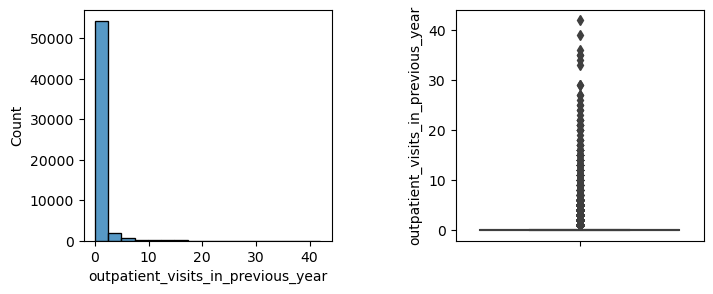

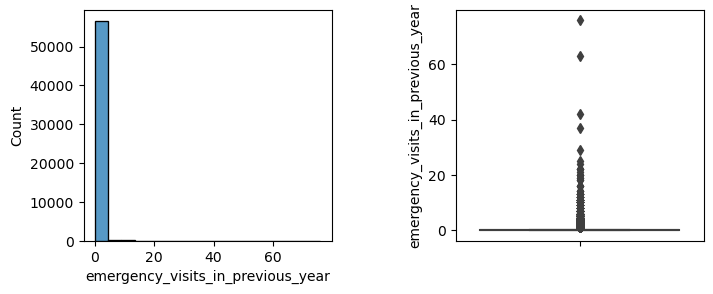

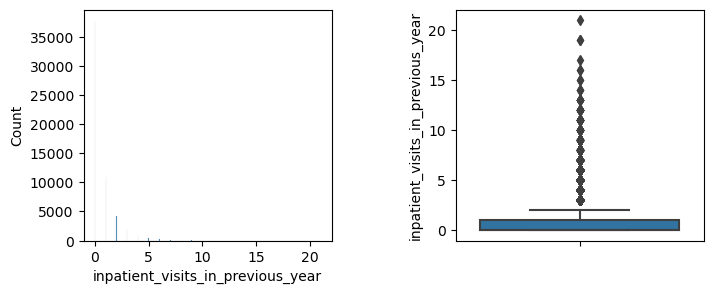

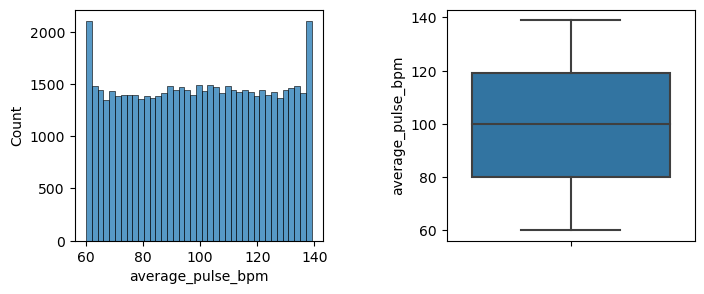

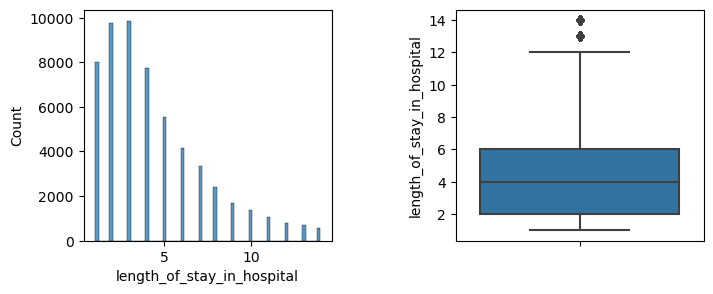

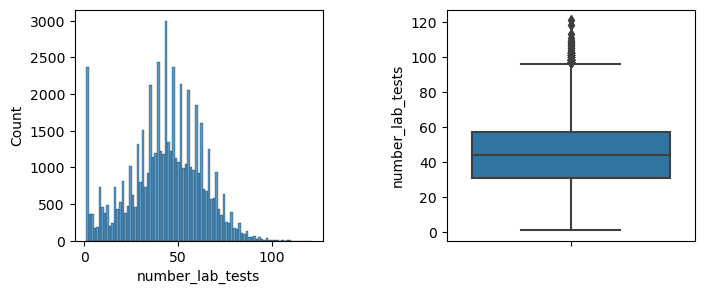

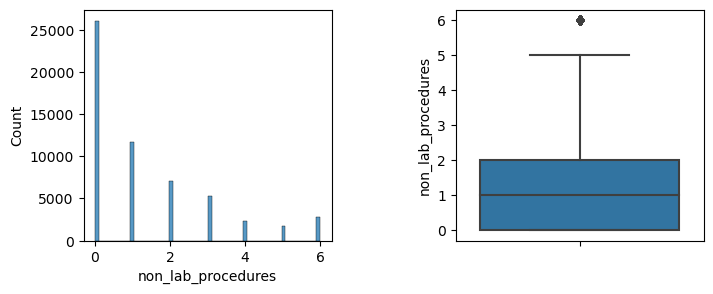

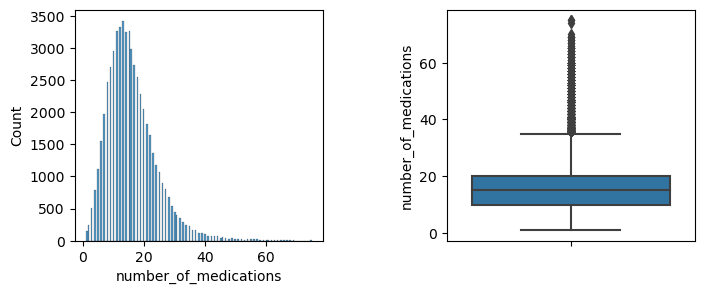

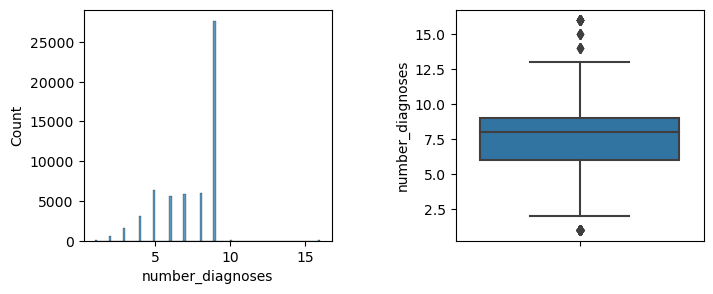

In [18]:
#let's check the distributions for the numerical features
numerical_features = X_train.select_dtypes(include=np.number).columns
for col in numerical_features:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={'wspace': 0.5})
    sns.histplot(ax=axes[0], x= X_train[col])
    sns.boxplot(ax=axes[1], y=X_train[col])
    plt.show()

In [19]:
#number diagnoses peaks at 9 for some reason
#inpatient, outpatient, emergency visits -> very right screwed distributions with long tail
#'zero inflated poisson distribution'
#let's check the distributions for them for values < 10 to get a clearer visualization


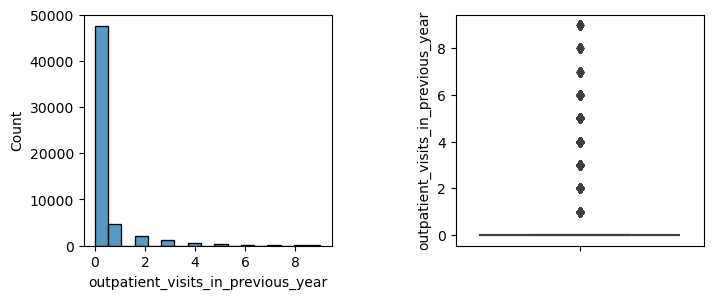

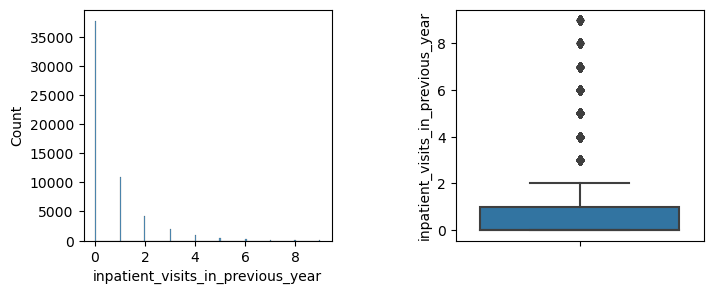

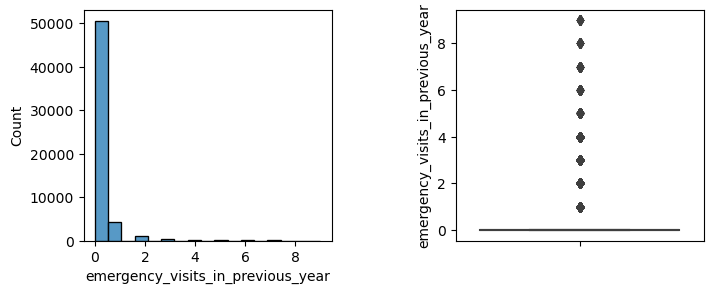

In [20]:
for col in ['outpatient_visits_in_previous_year','inpatient_visits_in_previous_year','emergency_visits_in_previous_year']:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), gridspec_kw={'wspace': 0.5})
    sns.histplot(ax=axes[0], x=X_train.loc[X_train[col]<10, col])
    sns.boxplot(ax=axes[1], y=X_train.loc[X_train[col]<10, col])
    plt.show()

In [21]:
#it makes no sense to assume that all the outliers, basically all values > 0 regarding the iqr methods, are 'wrong' and need to be changed
#considering that in real life it can be quite common to visit the hospital several times a year
#therefore it can make sense to take the log (log1p) for distributions like that
#it makes the data more symmetrical, compresses the scale, stabalizes variance
# #we'll do it later on

In [22]:
#this function puts the numerical values into bins and shows the correlation with the target variable by frequency and also proportional
def bar_charts_numerical(df, feature, target, num_bins=10):
    # Create bins for numerical values
    df['binned_values'] = pd.cut(df[feature], bins=num_bins, precision=2)
    
    # Convert interval midpoints to numeric values
    df['binned_values'] = df['binned_values'].apply(lambda x: x.mid)
    
    cont_tab = pd.crosstab(df['binned_values'], df[target], margins=True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 6))
    
    # Frequency bar chart
    plt.subplot(121)
    p1 = plt.bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray")
    p2 = plt.bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # Proportion bar chart
    obs_pct = np.array([np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values), 
                        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)])
      
    plt.subplot(122)
    p1 = plt.bar(categories, obs_pct[0], 0.55, color="gray")
    p2 = plt.bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    plt.legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    plt.axhline(y=0.888, color='red', linestyle='--', label='Overall Ratio', linewidth=0.5)
    
    # Remove the binned_values column to avoid interference in further computations
    df.drop('binned_values', axis=1, inplace=True)
    
    plt.show()




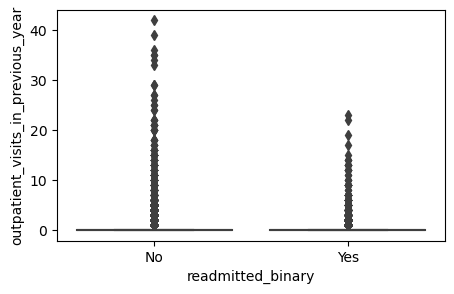

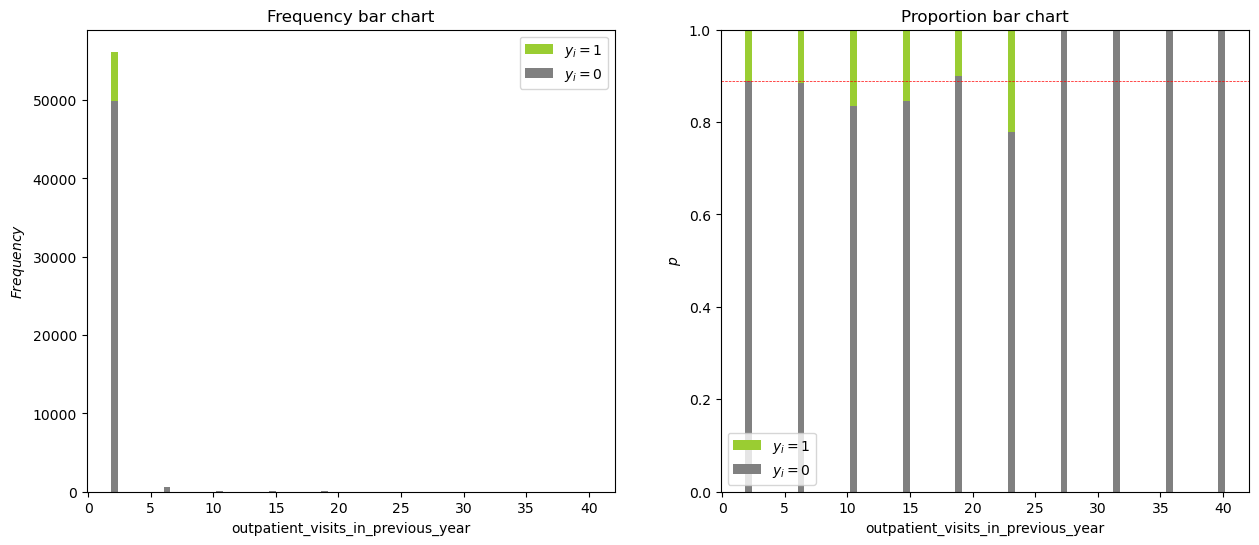

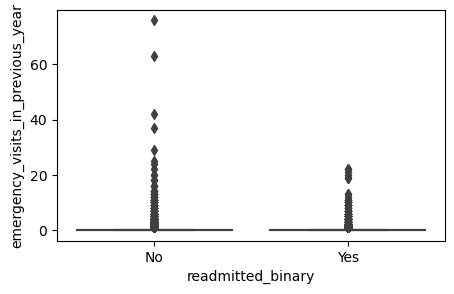

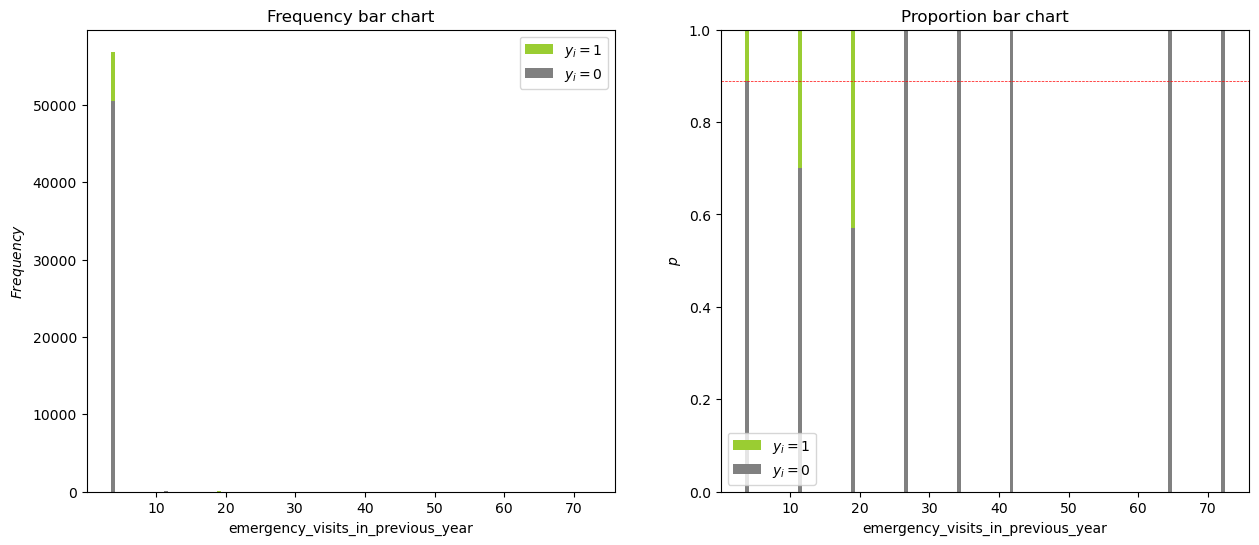

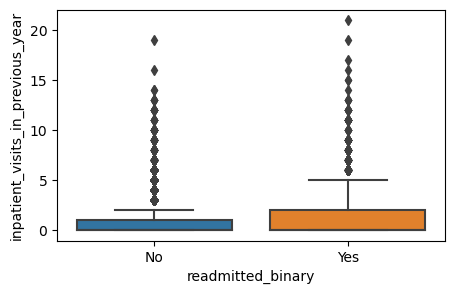

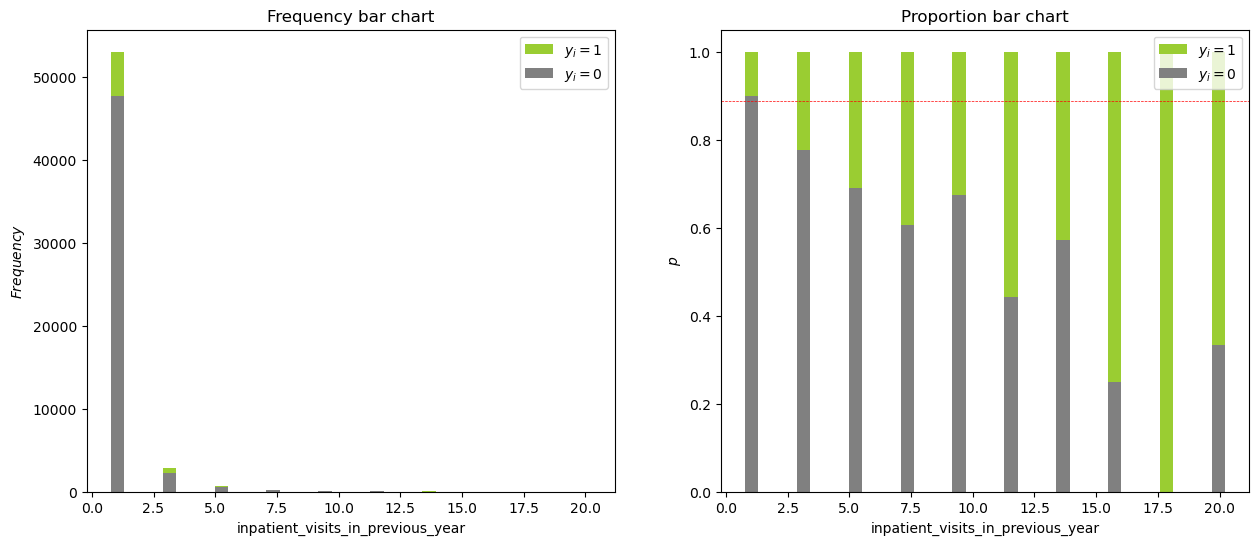

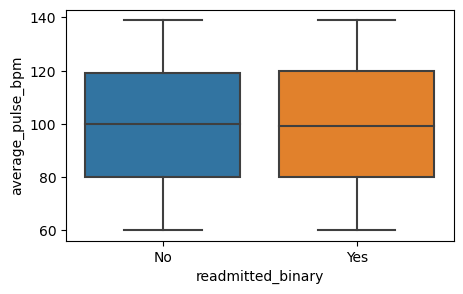

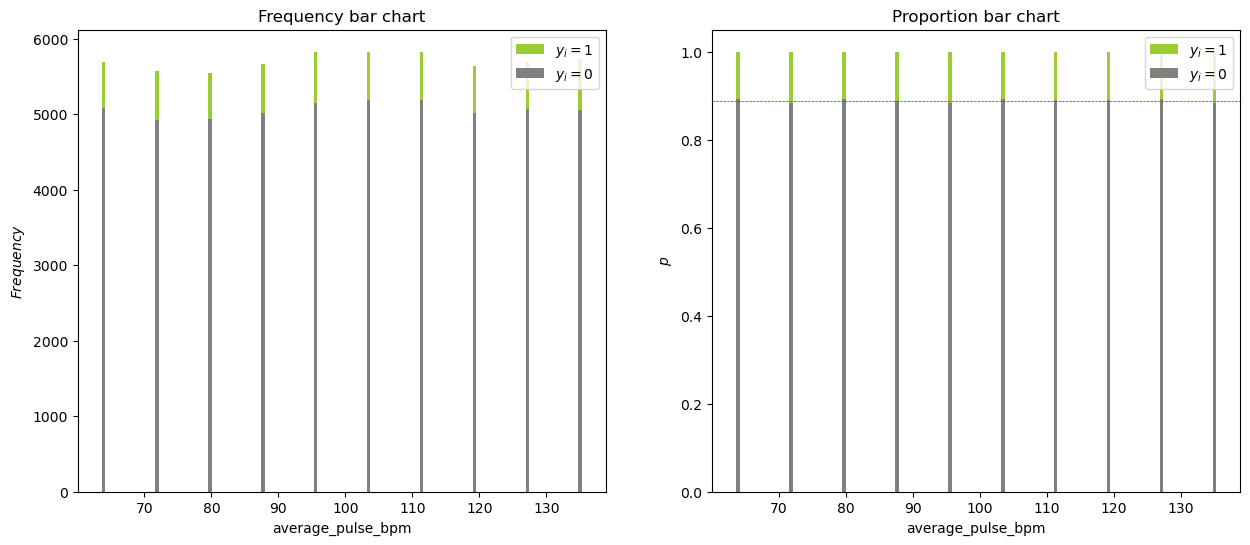

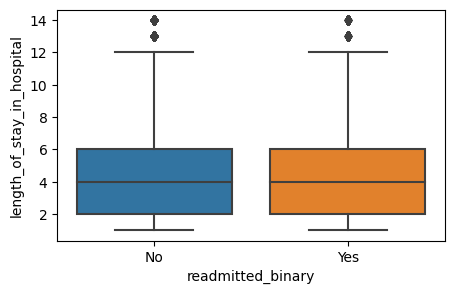

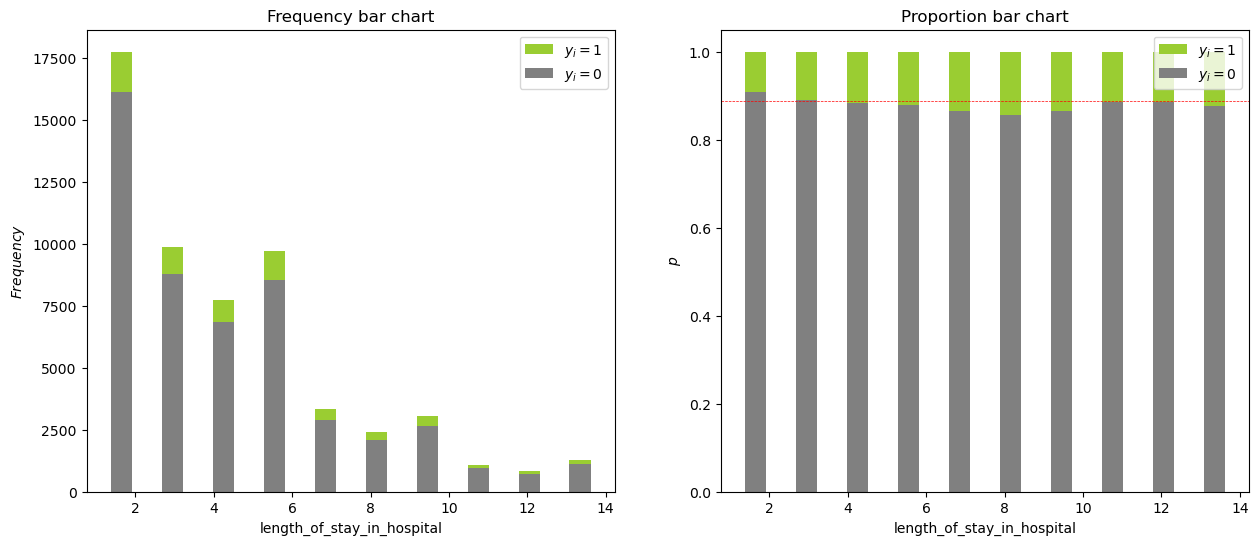

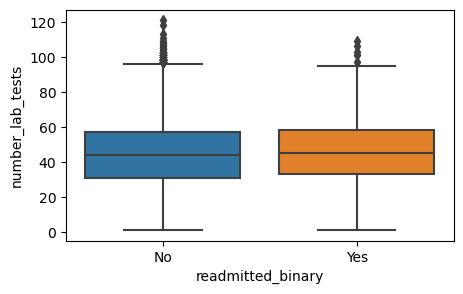

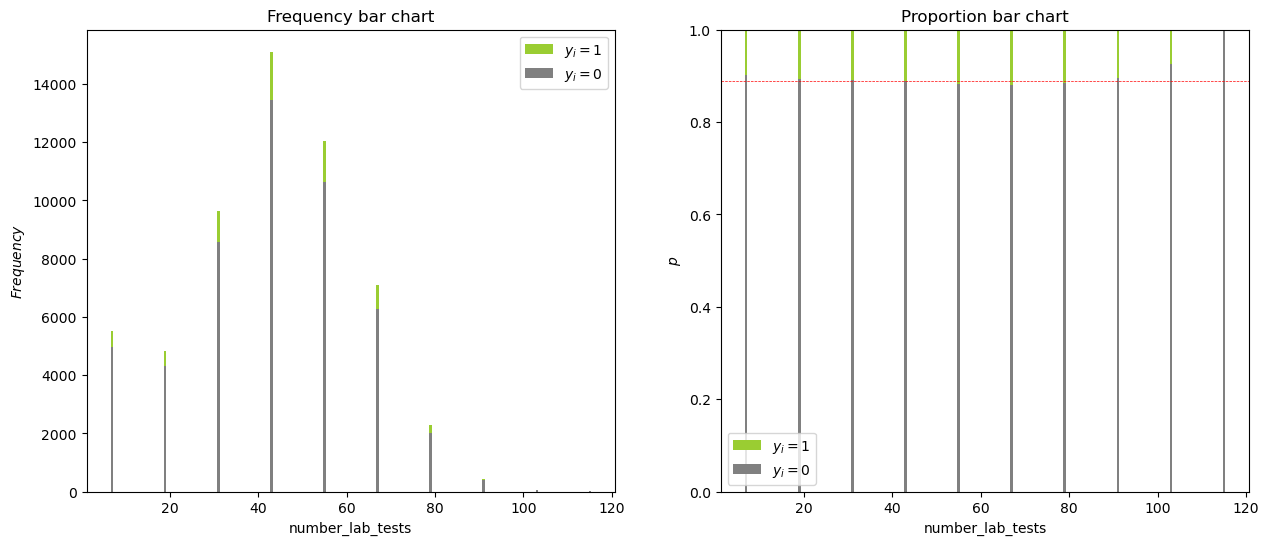

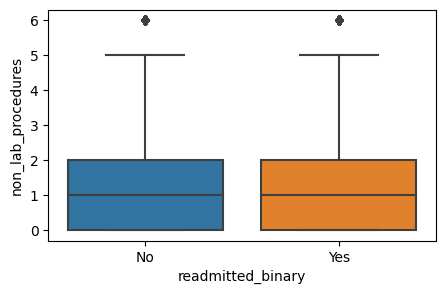

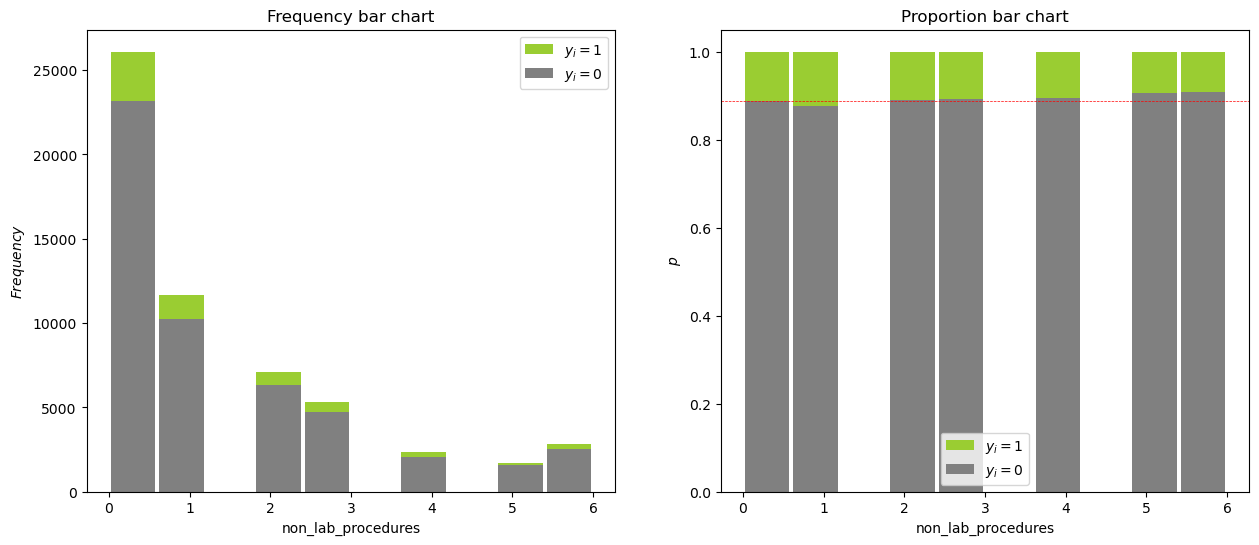

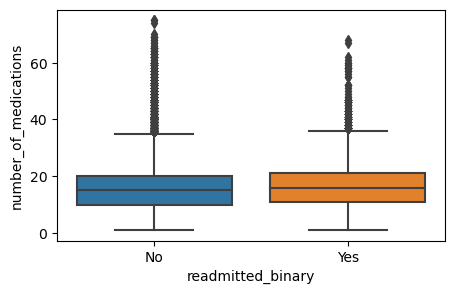

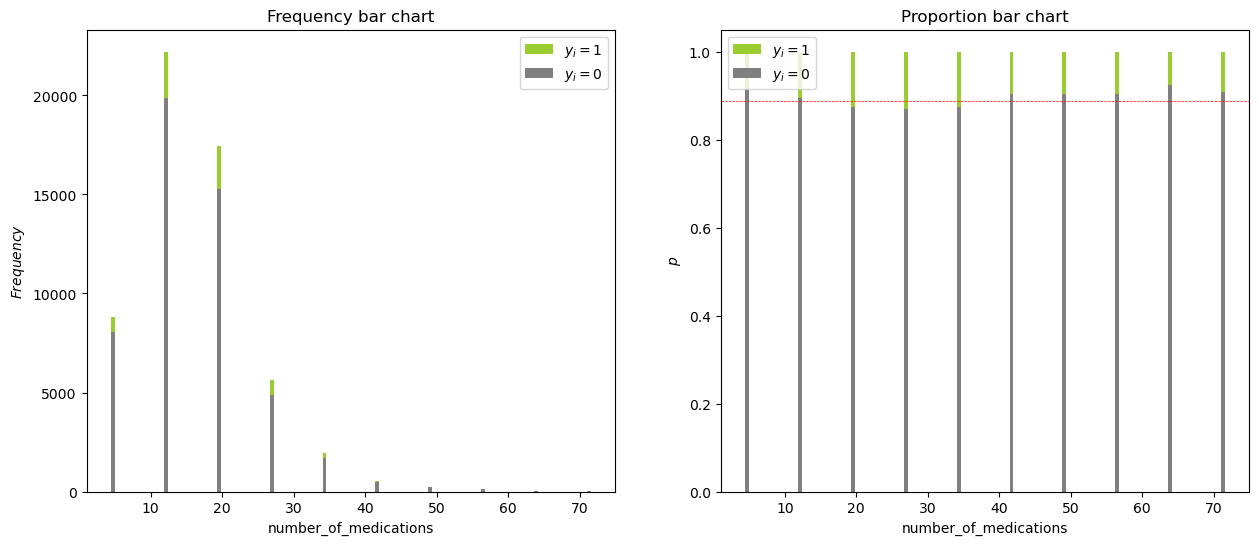

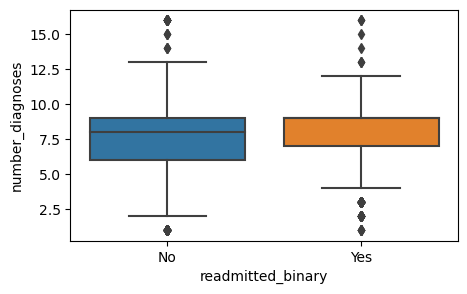

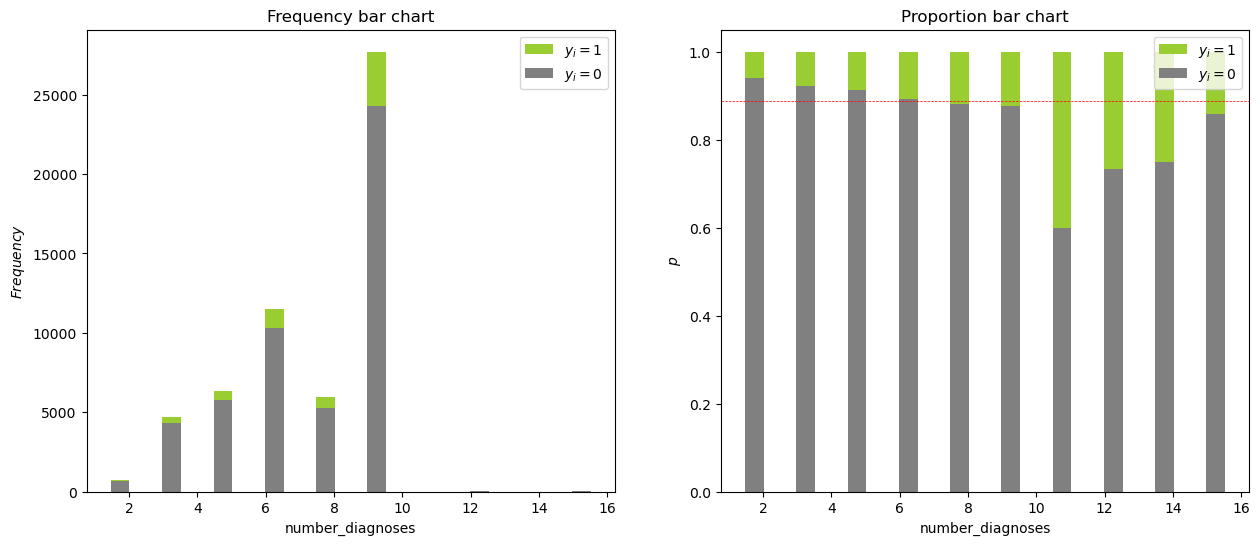

In [23]:
#first we bin the numerical data and have a look at the distributions and their effect on the target variable
#for the visits we'll do again later on after taking the log as u dont gain a lot information of this visualizations as is

all_train = X_train.join(y_train)

for col in numerical_features:
    plt.figure(figsize=(5, 3))
    sns.boxplot(y=X_train[col], x = y_train)
    plt.show()
    bar_charts_numerical(all_train, col, 'readmitted_binary', num_bins=10)

In [24]:
#number of diagnosis seems to be correlated
#average pulse doesnt seem to have a big effect
#strong correlation with inpatient visits
#number medications between 20-35 seems to peak for readmission
#length of stay in hospital seems to peak between 5 and 9

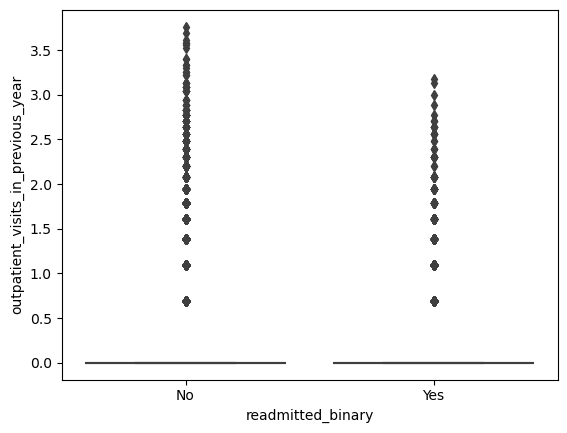

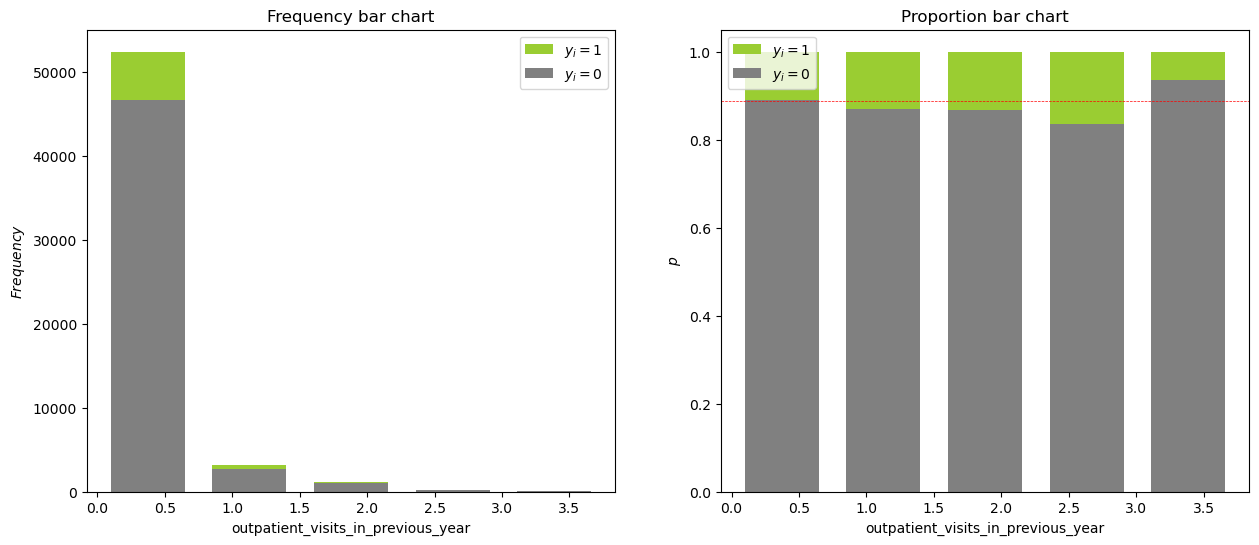

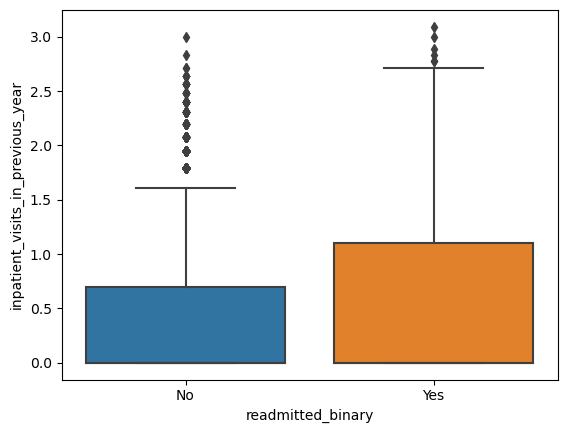

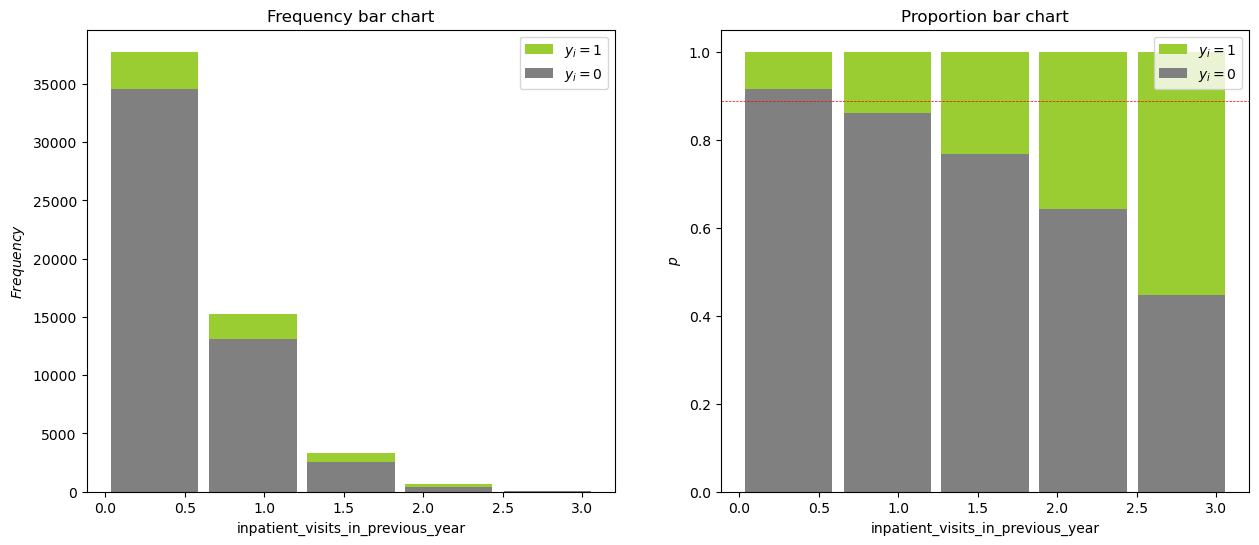

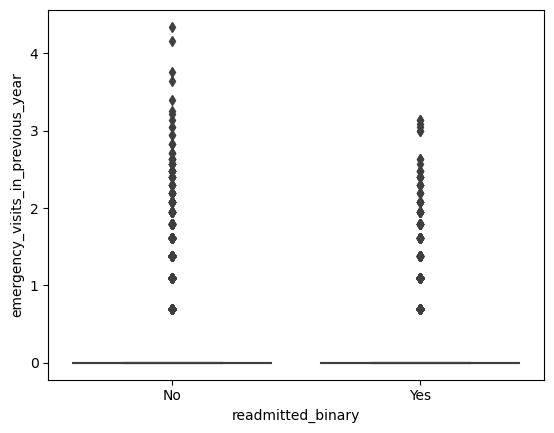

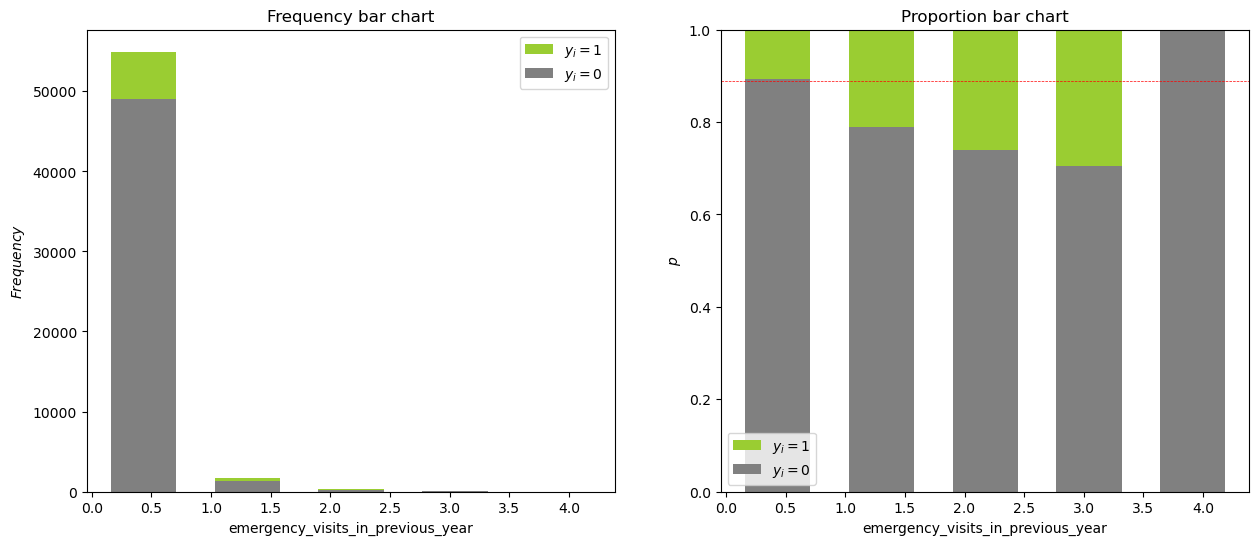

In [25]:
all_train['outpatient_visits_in_previous_year'] = np.log1p(all_train['outpatient_visits_in_previous_year'])
all_train['inpatient_visits_in_previous_year'] = np.log1p(all_train['inpatient_visits_in_previous_year'])
all_train['emergency_visits_in_previous_year'] = np.log1p(all_train['emergency_visits_in_previous_year'])

for col in ['outpatient_visits_in_previous_year','inpatient_visits_in_previous_year','emergency_visits_in_previous_year']:
    sns.boxplot(y=all_train[col], x = all_train['readmitted_binary'])
    bar_charts_numerical(all_train, col, 'readmitted_binary', num_bins=5)
    plt.show()

Preprocessing numericals

In [26]:
#after taking the log clear correlations are visible for all of the visits, especially inpatient
# for emergency visits > 3.2 no readmissions anymore, maybe inplausible outliers, set to median (0)
#comparable for outpatient visits
#it seems like the log transformation is an appropriate way to deal with the variables so we will work with
#the transformed data from now on for the visits and directly remove the outliers
X_train['outpatient_visits_in_previous_year'] = np.log1p(X_train['outpatient_visits_in_previous_year'])
X_train['inpatient_visits_in_previous_year'] = np.log1p(X_train['inpatient_visits_in_previous_year'])
X_train['emergency_visits_in_previous_year'] = np.log1p(X_train['emergency_visits_in_previous_year'])
 
X_train.loc[X_train['emergency_visits_in_previous_year'] >= 3.2, 'emergency_visits_in_previous_year' ] = 0
X_train.loc[X_train['outpatient_visits_in_previous_year'] >= 3.2, 'outpatient_visits_in_previous_year' ] = 0

In [27]:
#average pulse no outliers

#length of stay in hospittal, correlation for outliers seems to match the correlation for the median based on the visual inspection, set to median
X_train.loc[X_train['length_of_stay_in_hospital']>12, 'length_of_stay_in_hospital'] = 4

#same for number of lab tests
X_train.loc[X_train['number_lab_tests']>96, 'number_lab_tests'] = 44

#same here
X_train.loc[X_train['number_of_medications']>34, 'number_of_medications'] = 15


#winsorizing upper outer quantile range, since distribution regarding the target variable seems to fit better to the outer quantile range
X_train.loc[X_train['number_diagnoses']>13, 'number_diagnoses'] = 13

#outer quantile range winsorizing for lab_procedures aswell
X_train.loc[X_train['non_lab_procedures']>5, 'non_lab_procedures'] = 5

In [28]:
X_train[numerical_features].groupby(y_train).mean() #mean differences 

outpatient_visits_in_previous_year  \
readmitted_binary                                       
No                                           0.165836   
Yes                                          0.206755   

                   emergency_visits_in_previous_year  \
readmitted_binary                                      
No                                          0.092390   
Yes                                         0.166484   

                   inpatient_visits_in_previous_year  average_pulse_bpm  \
readmitted_binary                                                         
No                                          0.299939          99.629039   
Yes                                         0.553052          99.738994   

                   length_of_stay_in_hospital  number_lab_tests  \
readmitted_binary                                                 
No                                   4.148120         42.922414   
Yes                                  4.512107         44.004560   

                   non_lab_procedures  number_of_medications  number_diagnoses  
readmitted_binary                                                               
No                           1.300091              15.112487          7.384649  
Yes                          1.224057              16.057862          7.700157

In [29]:
X_train[numerical_features].groupby(y_train).median()

outpatient_visits_in_previous_year  \
readmitted_binary                                       
No                                                0.0   
Yes                                               0.0   

                   emergency_visits_in_previous_year  \
readmitted_binary                                      
No                                               0.0   
Yes                                              0.0   

                   inpatient_visits_in_previous_year  average_pulse_bpm  \
readmitted_binary                                                         
No                                               0.0              100.0   
Yes                                              0.0               99.0   

                   length_of_stay_in_hospital  number_lab_tests  \
readmitted_binary                                                 
No                                        4.0              44.0   
Yes                                       4.0              45.0   

                   non_lab_procedures  number_of_medications  number_diagnoses  
readmitted_binary                                                               
No                                1.0                   15.0               8.0  
Yes                               1.0                   15.0               9.0

Feature Engineering

In [30]:
X_train['medication_per_day'] = X_train['number_of_medications'] / X_train['length_of_stay_in_hospital']
X_train['lab_tests_per_day'] = X_train['number_lab_tests'] / X_train['length_of_stay_in_hospital']
#maybe the nr of medications in relation to the hospital stay is a relevant feature
#if you get a lot of different medications in a short amount this might be beneficial, or the opposite, for the healing process
#same thought for the lab tests, either the diagnosis is so bad that you need to take a lot of tests, or the doctors
#take a lot of tests to ensure the patient is well and will be in the future

X_train['patient_id'] = patient_id
X_train['mean_of_inpatient_visits'] = X_train.groupby('patient_id')['inpatient_visits_in_previous_year'].transform('mean')
#X_train['mean_of_inpatient_visits'] = X_train.apply(lambda row: 0 if row['mean_of_inpatient_visits'] == row['inpatient_visits_in_previous_year'] else row['mean_of_inpatient_visits'], axis=1)
#also we saw in the eda that the inpatient_visits have a high correlation with the target variable
#we take the mean for the patient id, and fill with 0 if it equals the inpatient_visits_in previous year
#this way we also include information about if the patient is a duplicate in the feature

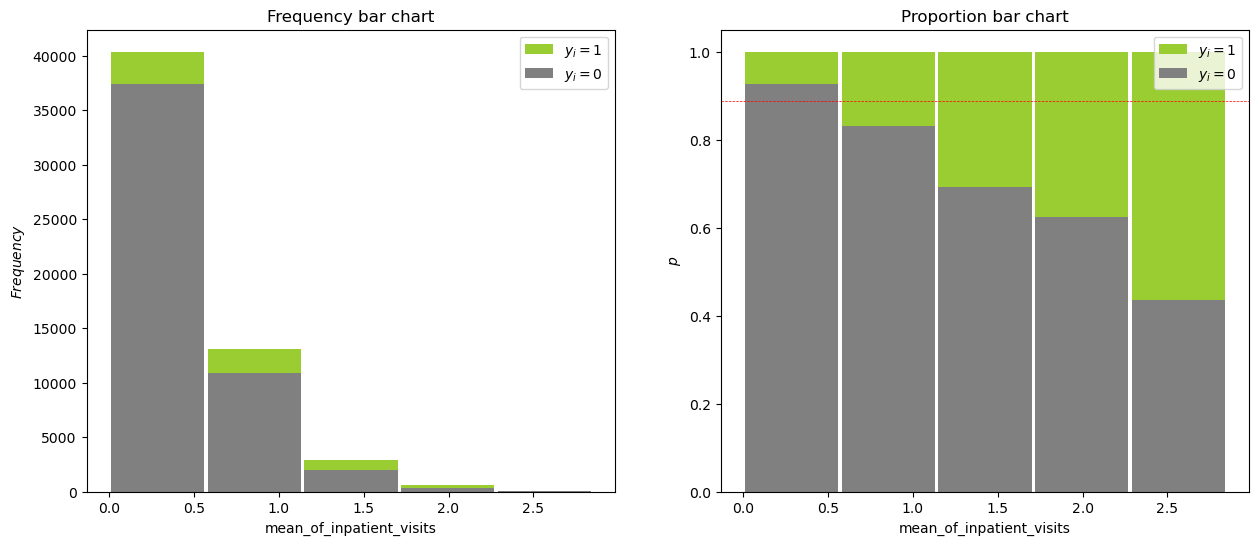

In [31]:
all_train = X_train.join(y_train)
bar_charts_numerical(all_train.loc[all_train['mean_of_inpatient_visits']<50], 'mean_of_inpatient_visits', 'readmitted_binary', num_bins=5)
#the mean of the inpatient visits seems to have an even higher correlation with the target variable 
#this might be due to the fact that the further history of patient has a big impact of his future readmission behaviour

In [32]:
numerical_features = X_train.select_dtypes(include=np.number).columns
numerical_features

Index(['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses', 'medication_per_day',
       'lab_tests_per_day', 'patient_id', 'mean_of_inpatient_visits'],
      dtype='object')

In [33]:
#same procedure for our validation data set
X_val['outpatient_visits_in_previous_year'] = np.log1p(X_val['outpatient_visits_in_previous_year'])
X_val['inpatient_visits_in_previous_year'] = np.log1p(X_val['inpatient_visits_in_previous_year'])
X_val['emergency_visits_in_previous_year'] = np.log1p(X_val['emergency_visits_in_previous_year'])


X_val.loc[X_val['emergency_visits_in_previous_year'] >= 3.2, 'emergency_visits_in_previous_year' ] = 0
X_val.loc[X_val['outpatient_visits_in_previous_year'] >= 3.2, 'outpatient_visits_in_previous_year' ] = 0

X_val.loc[X_val['length_of_stay_in_hospital']>12, 'length_of_stay_in_hospital'] = 4


X_val.loc[X_val['number_lab_tests']>96, 'number_lab_tests'] = 44

X_val.loc[X_val['number_of_medications']>34, 'number_of_medications'] = 15

X_val.loc[X_val['number_diagnoses']>13, 'number_diagnoses'] = 13

X_val.loc[X_val['non_lab_procedures']>5, 'non_lab_procedures'] = 5

X_val['medication_per_day'] = X_val['number_of_medications'] / X_val['length_of_stay_in_hospital']
X_val['lab_tests_per_day'] = X_val['number_lab_tests'] / X_val['length_of_stay_in_hospital']

#to ensure no data leakage we take the information if the nr_of_inpatient visits and do a left join on patient_id
X_val = pd.merge(X_val, X_train.groupby('patient_id')['mean_of_inpatient_visits'].max().reset_index(), on='patient_id', how='left').set_index(X_val_id)
#X_val['mean_of_inpatient_visits'].fillna(0, inplace=True)
X_val['mean_of_inpatient_visits'].fillna(X_val['inpatient_visits_in_previous_year'], inplace=True)

X_train.drop(columns='patient_id', inplace=True)#drop patient id for val and train set since it's an id it's not worth keeping
X_val.drop(columns='patient_id', inplace=True)

numerical_features = X_train.select_dtypes(include=np.number).columns

Categoricals

In [34]:
categorical_features = X_train.select_dtypes(exclude=np.number).columns

In [35]:
#for now we fill NAs with 'NA' for the EDA
X_train[categorical_features] = X_train[categorical_features].fillna('NA')

In [36]:
for col in categorical_features:
    print(col, X_train[col].nunique())

#extremely high number of categories for primary, seondary, additional diagnosis and medication
#high number of categories for medical specialty, discharge disposition, admission source
#will lead to a lot of dummy variables after one hot encoding-> high feature space

country 1
race 7
gender 3
age 11
weight 10
payer_code 18
admission_type 8
medical_specialty 69
discharge_disposition 25
admission_source 17
primary_diagnosis 662
secondary_diagnosis 671
additional_diagnosis 719
glucose_test_result 4
a1c_test_result 4
change_in_meds_during_hospitalization 2
prescribed_diabetes_meds 2
medication 287


In [37]:
#this function allows us to have a look at the frequency aswell as the proportion and the relation to the target variable
#since some of the features have a lot of cardinalities, we have a look at the top 20 only

def bar_charts_categorical(df, feature, target, top_n=20, font_size=10):
    cont_tab = pd.crosstab(df[feature], df[target], margins=True)

    cont_tab = cont_tab.sort_values(by='All', ascending=False).head(top_n)
    
    categories = cont_tab.index  

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

    p1 = axes[0].bar(categories, cont_tab.iloc[:, 0].values, 0.55, color="gray")
    p2 = axes[0].bar(categories, cont_tab.iloc[:, 1].values, 0.55, bottom=cont_tab.iloc[:, 0], color="yellowgreen")
    axes[0].legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    axes[0].set_title("Frequency bar chart")
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("$Frequency$")
    
    axes[0].set_xticks(range(len(categories)))
    axes[0].set_xticklabels(categories, rotation=45, ha='right', fontsize=font_size)

    obs_pct = np.array([np.divide(cont_tab.iloc[:, 0].values, cont_tab.iloc[:, 2].values),
                        np.divide(cont_tab.iloc[:, 1].values, cont_tab.iloc[:, 2].values)])
    
    categories_proportion = cont_tab.index
    
    p1 = axes[1].bar(categories_proportion, obs_pct[0], 0.55, color="gray")
    p2 = axes[1].bar(categories_proportion, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen")
    axes[1].legend((p2[0], p1[0]), ('$y_i=1$', '$y_i=0$'))
    axes[1].set_title("Proportion bar chart")
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel("$p$")
    axes[1].axhline(y=0.888, color='red', linestyle='--', label='Overall Ratio', linewidth=0.5)
    
    axes[1].set_xticks(range(len(categories_proportion)))
    axes[1].set_xticklabels(categories_proportion, rotation=45, ha='right', fontsize=font_size)

    for ax in axes:
        ax.yaxis.set_tick_params(labelsize=font_size)

    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout()
    plt.show()


all_train = X_train.join(y_train)



country
USA    56988
Name: count, dtype: int64


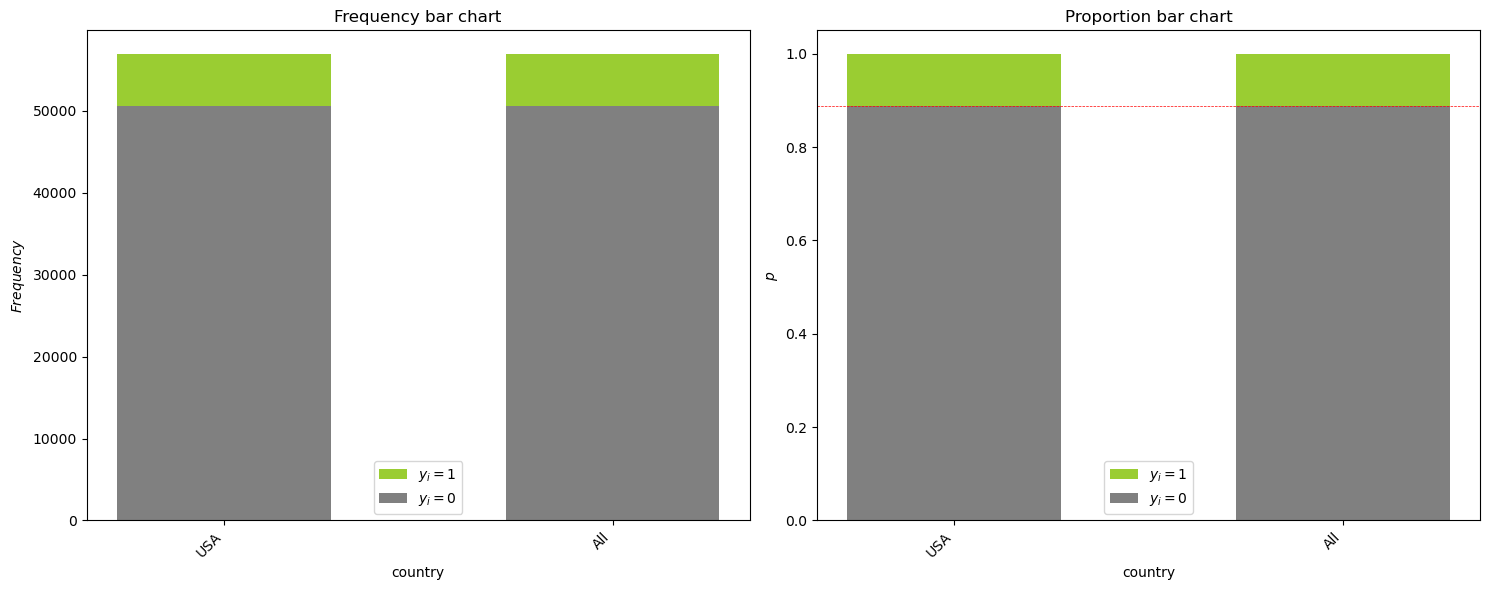

race
Caucasian          40549
AfricanAmerican    10211
NA                  2814
?                   1196
Hispanic            1083
Other                802
Asian                333
Name: count, dtype: int64


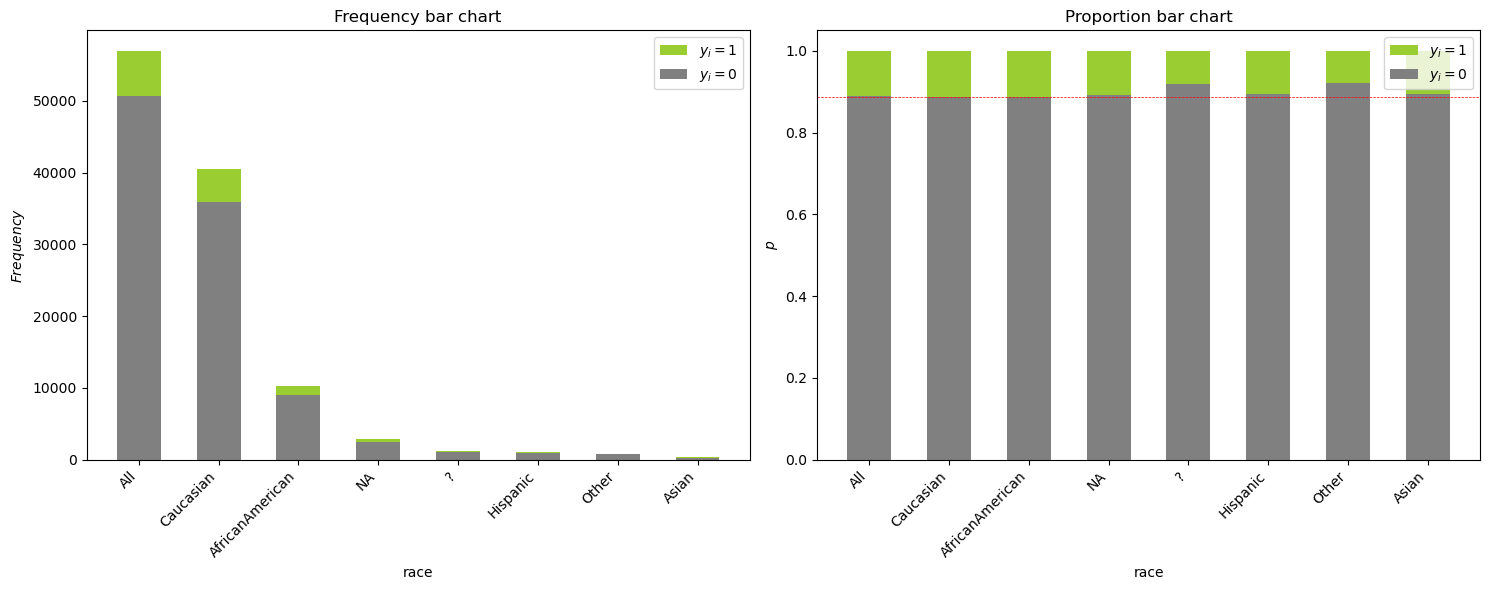

gender
Female             30481
Male               26505
Unknown/Invalid        2
Name: count, dtype: int64


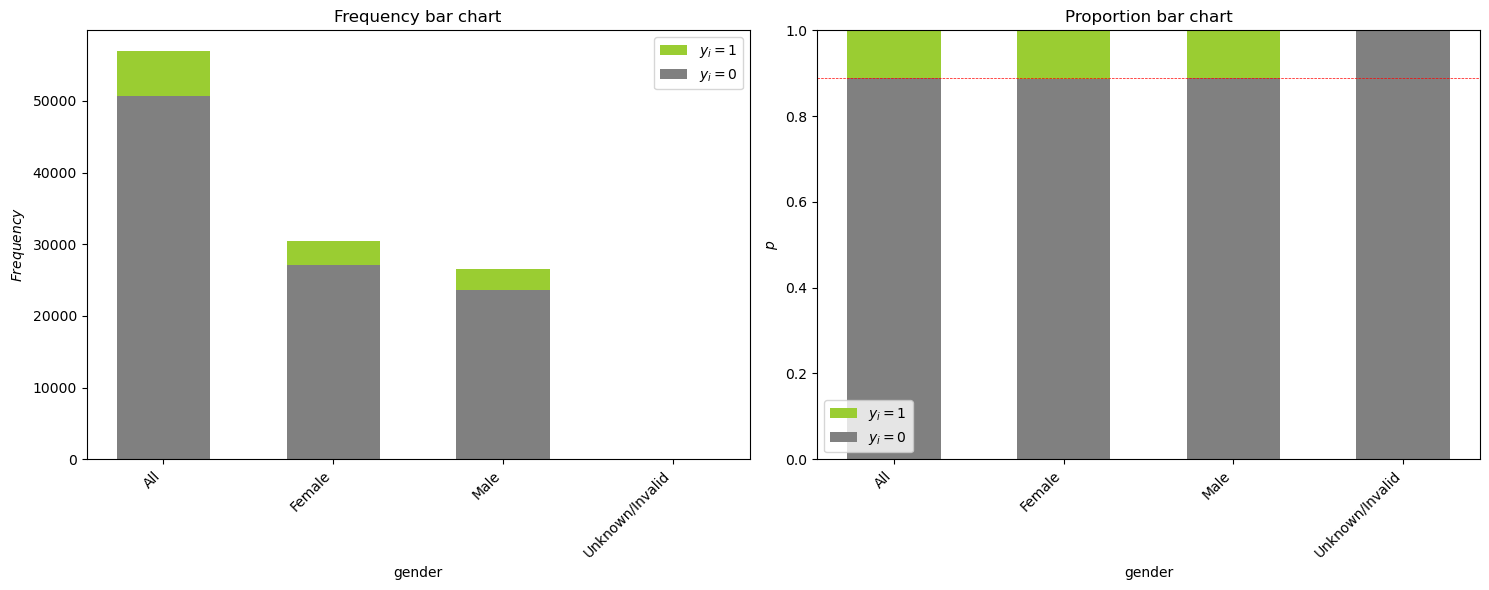

age
[70-80)     13845
[60-70)     11983
[80-90)      9188
[50-60)      9160
[40-50)      5112
NA           2857
[30-40)      2022
[90-100)     1505
[20-30)       859
[10-20)       370
[0-10)         87
Name: count, dtype: int64


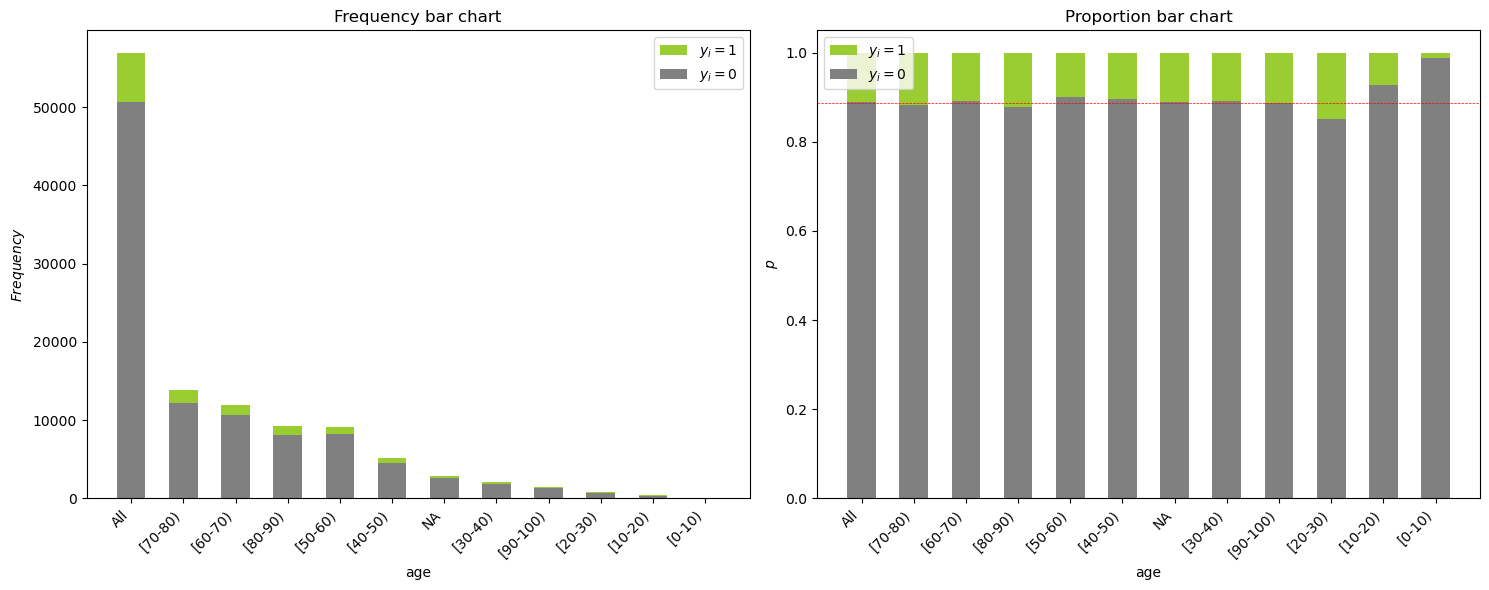

weight
?            55171
[75-100)       758
[50-75)        511
[100-125)      362
[125-150)       83
[25-50)         51
[0-25)          29
[150-175)       16
[175-200)        5
>200             2
Name: count, dtype: int64


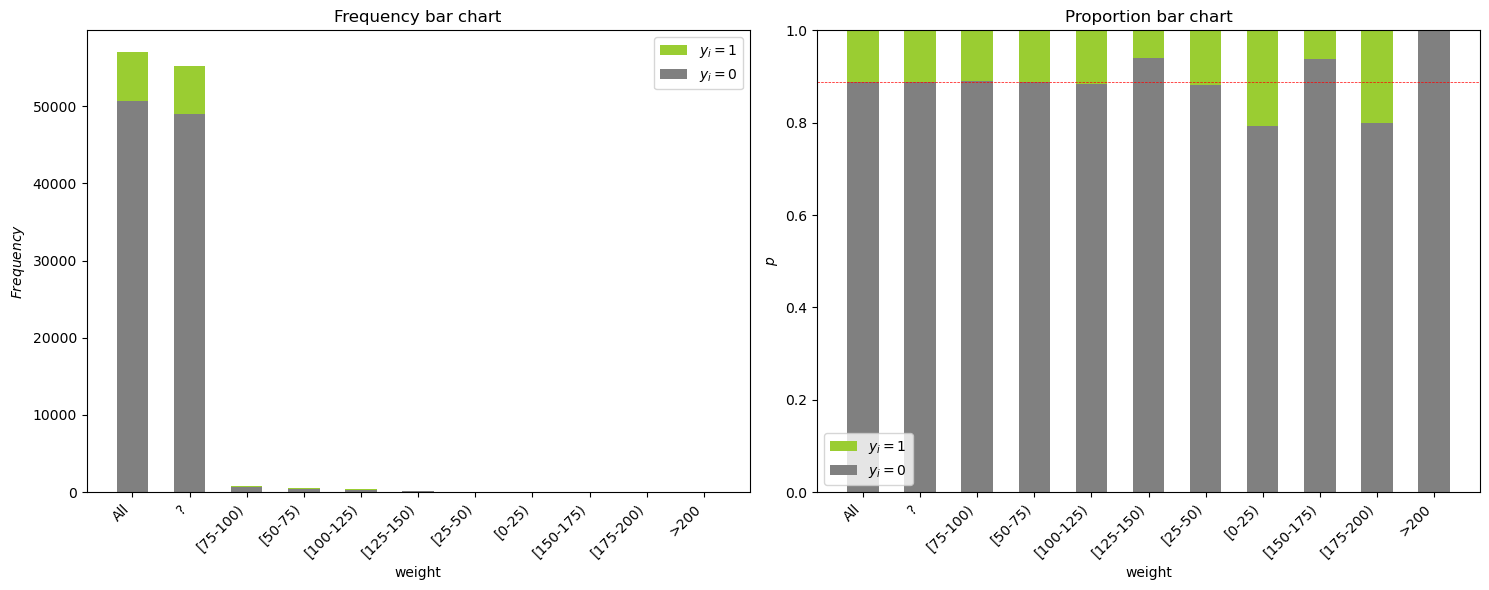

payer_code
?     22556
MC    18176
HM     3426
SP     2839
BC     2651
MD     1986
CP     1412
UN     1374
CM     1058
OG      578
PO      321
DM      313
CH       82
WC       79
OT       55
MP       45
SI       36
FR        1
Name: count, dtype: int64


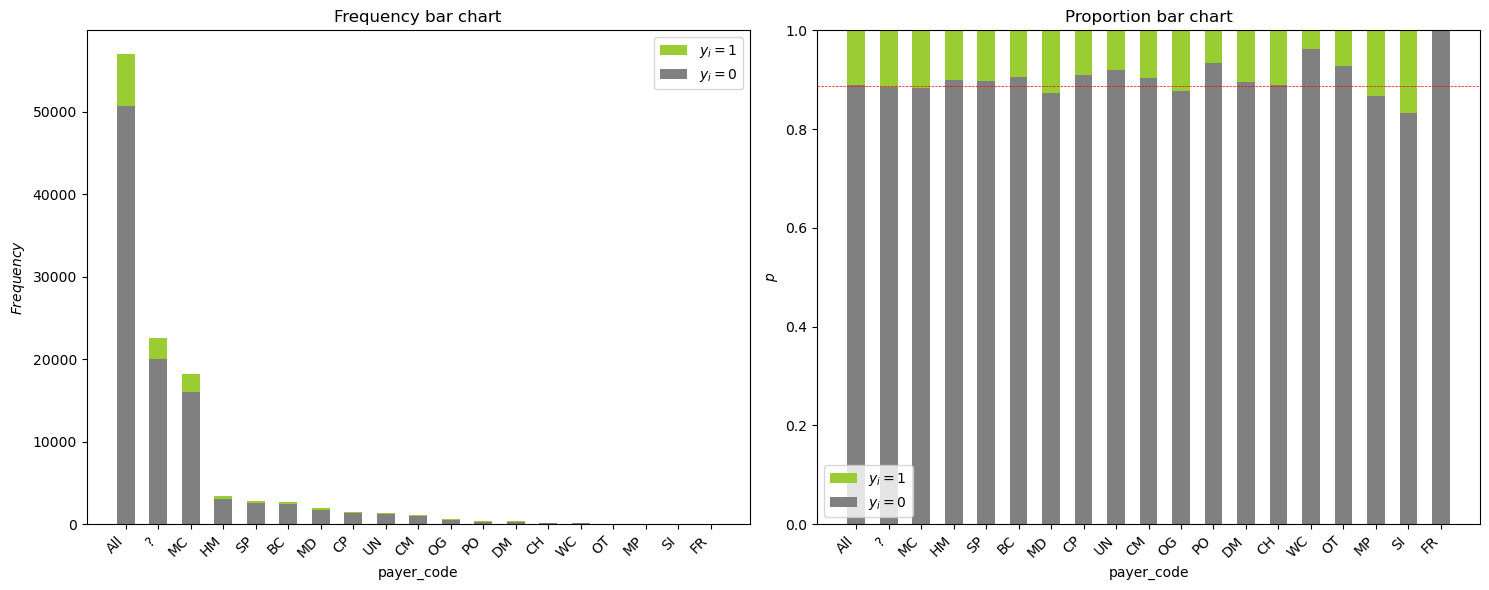

admission_type
Emergency        30245
Elective         10559
Urgent           10368
NA                2946
Not Available     2677
Not Mapped         176
Trauma Center       13
Newborn              4
Name: count, dtype: int64


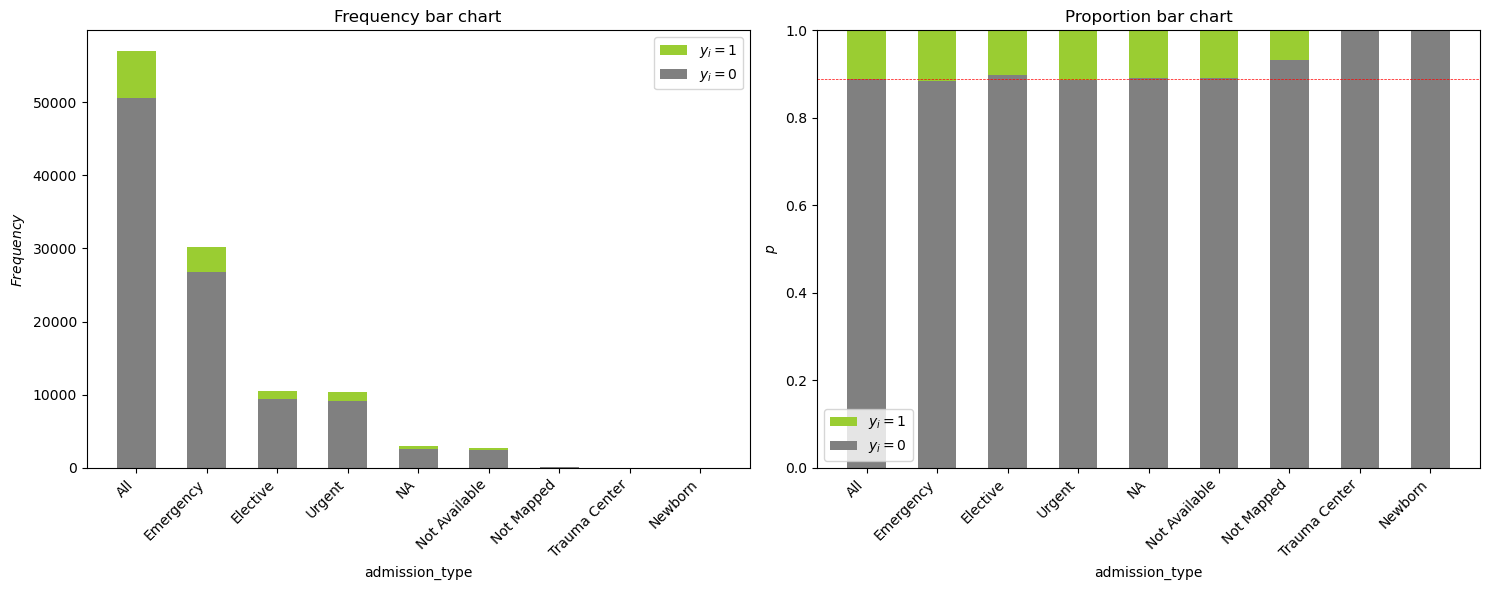

medical_specialty
?                                  27926
InternalMedicine                    8227
Emergency/Trauma                    4254
Family/GeneralPractice              4152
Cardiology                          3000
                                   ...  
Speech                                 1
DCPTEAM                                1
Pediatrics-AllergyandImmunology        1
Proctology                             1
Neurophysiology                        1
Name: count, Length: 69, dtype: int64


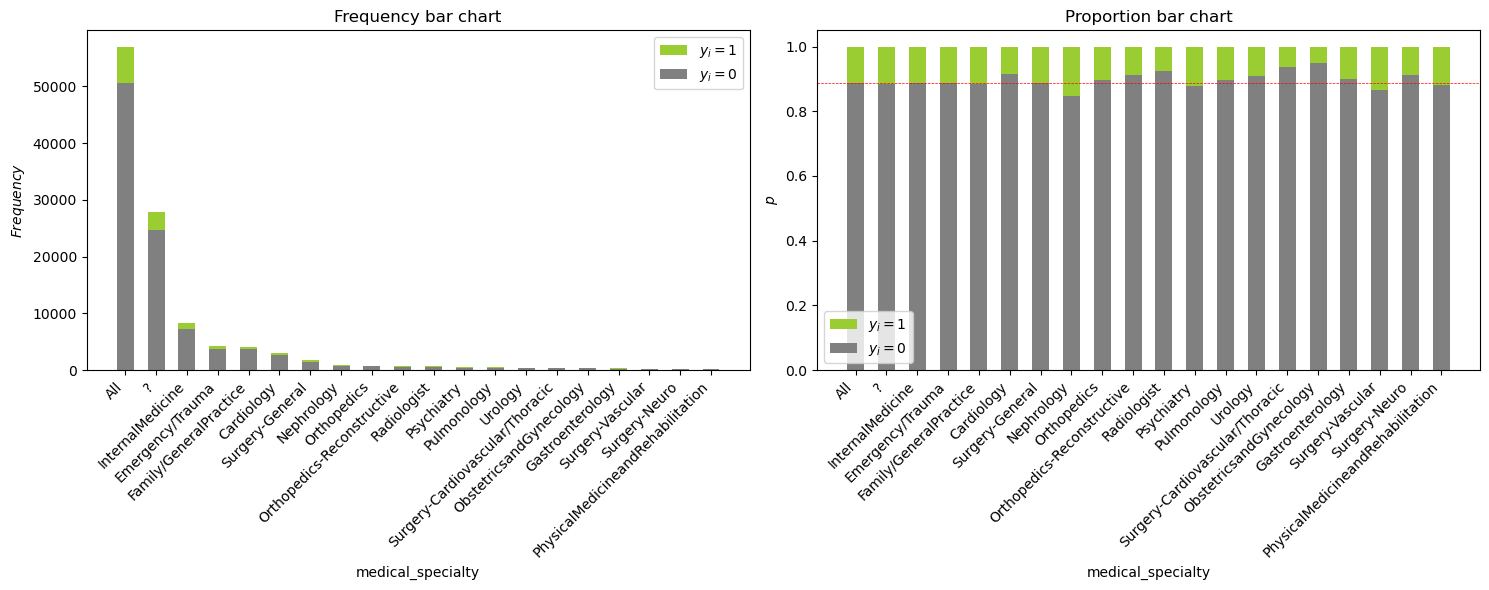

discharge_disposition
Discharged to home                                                                                           33896
Discharged/transferred to SNF                                                                                 7754
Discharged/transferred to home with home health service                                                       7221
NA                                                                                                            2071
Discharged/transferred to another short term hospital                                                         1191
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1086
Expired                                                                                                        897
Discharged/transferred to another type of inpatient care institution                                           673
Not Mapped                                                

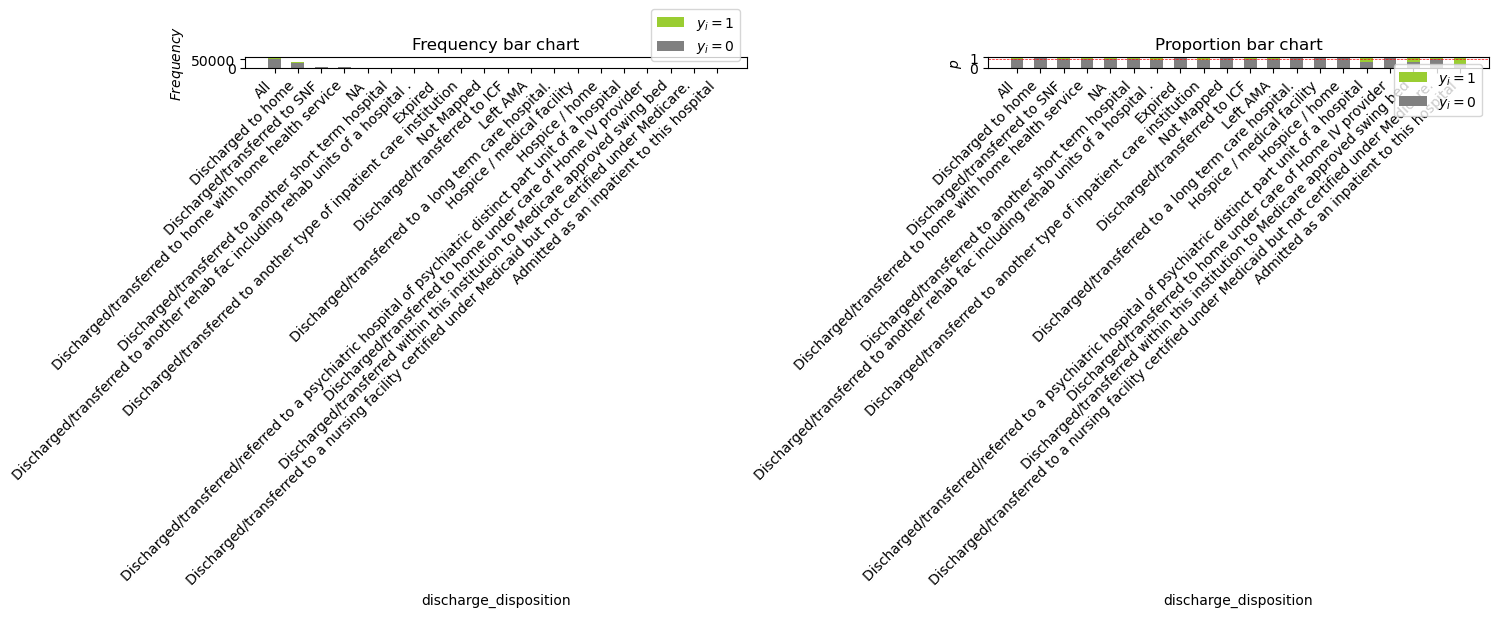

admission_source
 Emergency Room                                               32309
 Physician Referral                                           16511
NA                                                             3787
Transfer from a hospital                                       1780
 Transfer from another health care facility                    1237
Clinic Referral                                                 621
 Transfer from a Skilled Nursing Facility (SNF)                 473
HMO Referral                                                     98
 Not Mapped                                                      84
 Not Available                                                   62
 Court/Law Enforcement                                            8
 Transfer from hospital inpt/same fac reslt in a sep claim        7
 Transfer from critial access hospital                            6
 Transfer from Ambulatory Surgery Center                          2
 Extramural Birth              

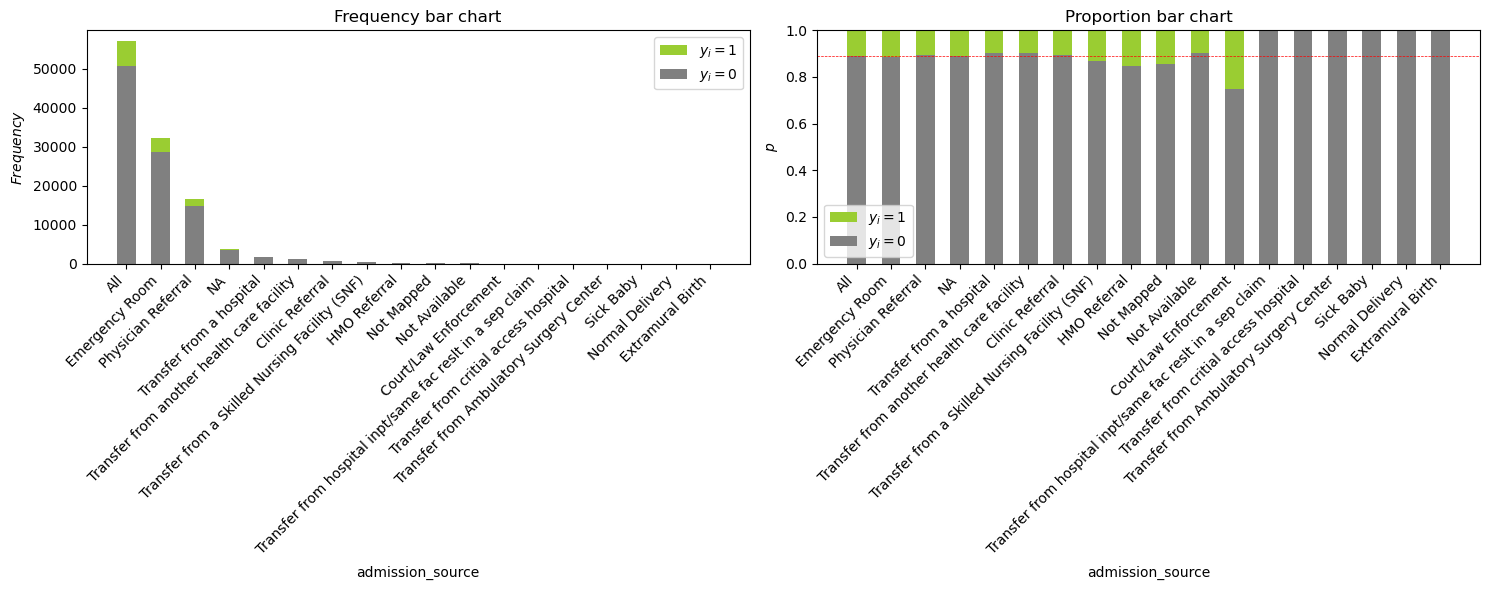

primary_diagnosis
428    3866
414    3694
786    2252
486    2034
410    1984
       ... 
897       1
279       1
381       1
477       1
114       1
Name: count, Length: 662, dtype: int64


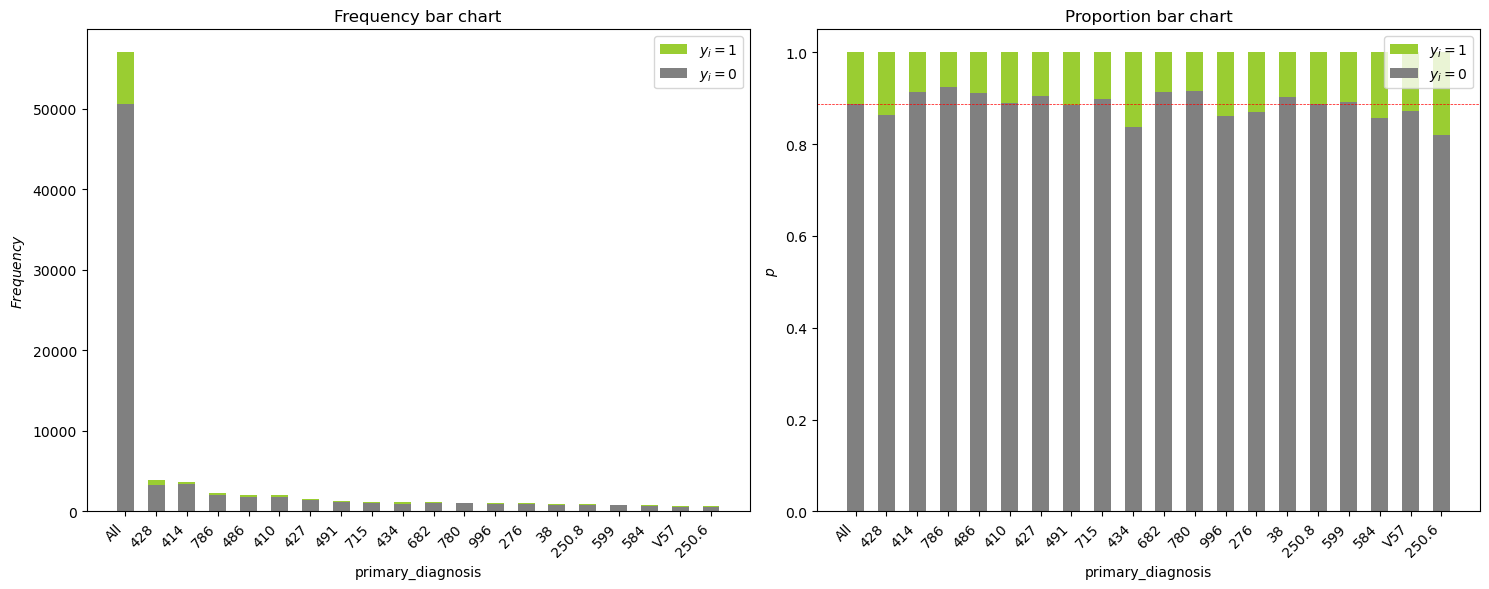

secondary_diagnosis
276    3771
428    3764
250    3415
427    2827
401    2080
       ... 
164       1
271       1
980       1
483       1
906       1
Name: count, Length: 671, dtype: int64


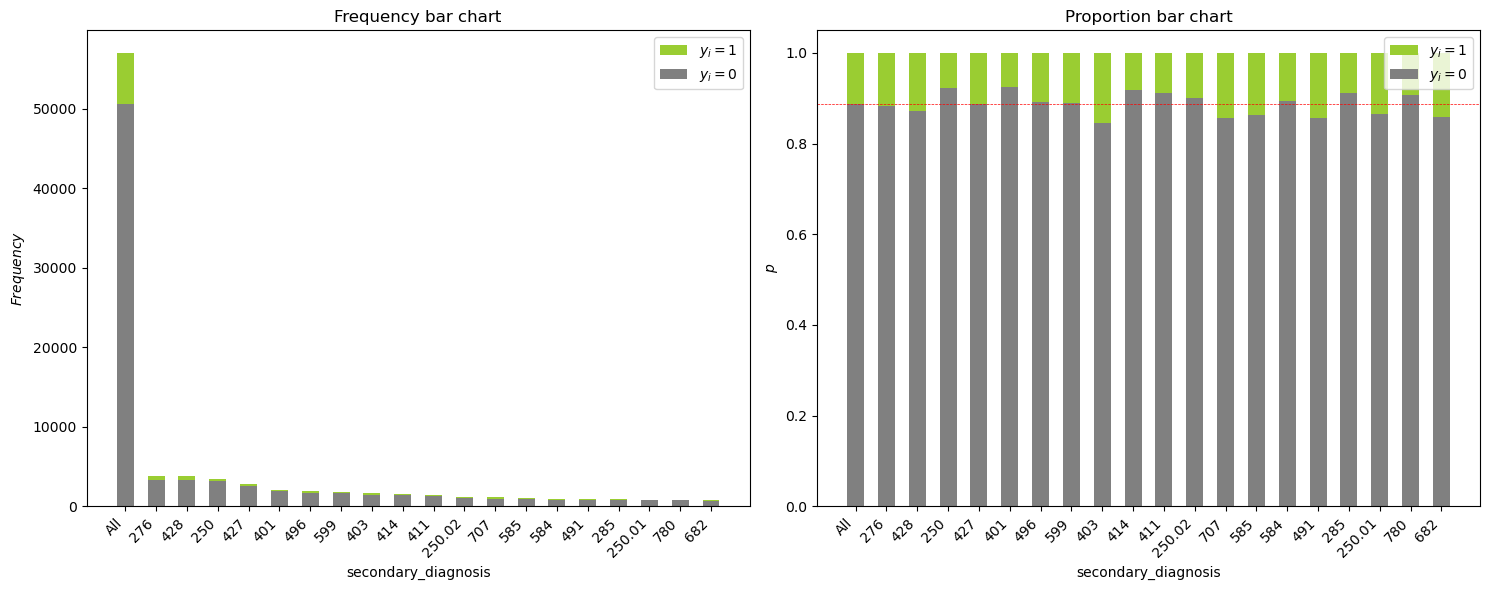

additional_diagnosis
250     6431
401     4618
276     2899
428     2592
427     2196
        ... 
161        1
952        1
834        1
215        1
E922       1
Name: count, Length: 719, dtype: int64


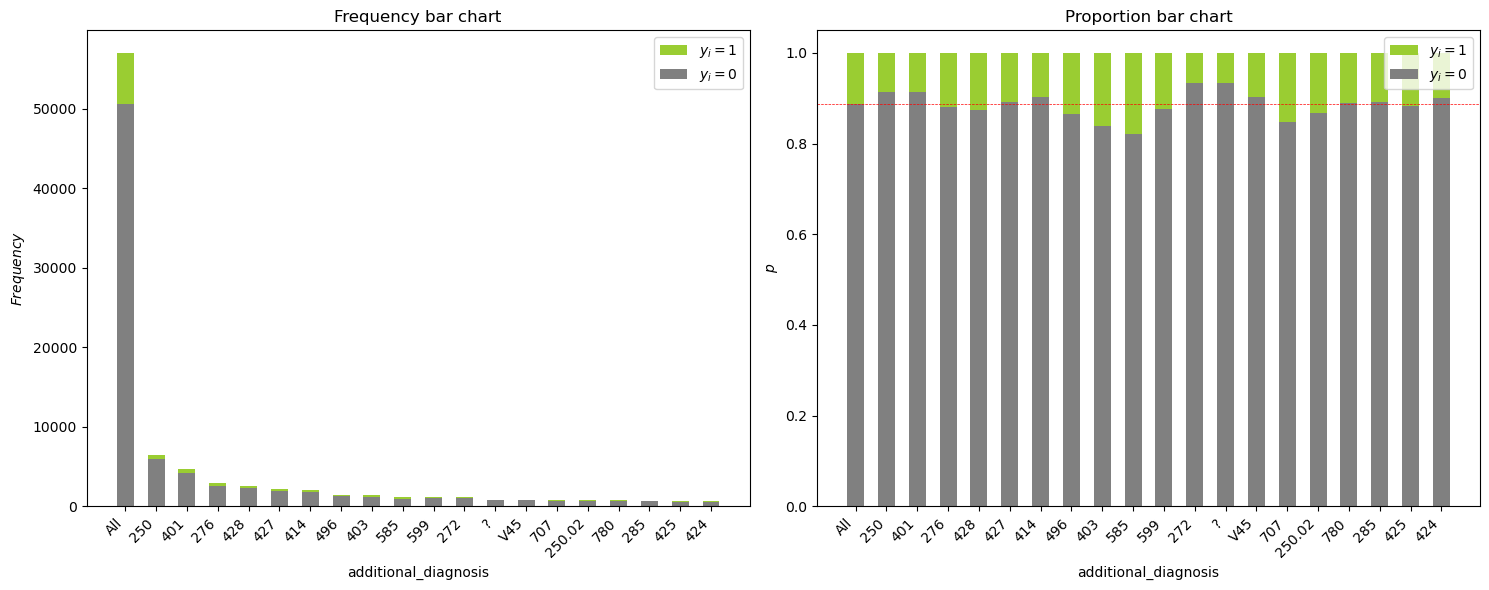

glucose_test_result
NA      54024
Norm     1440
>200      844
>300      680
Name: count, dtype: int64


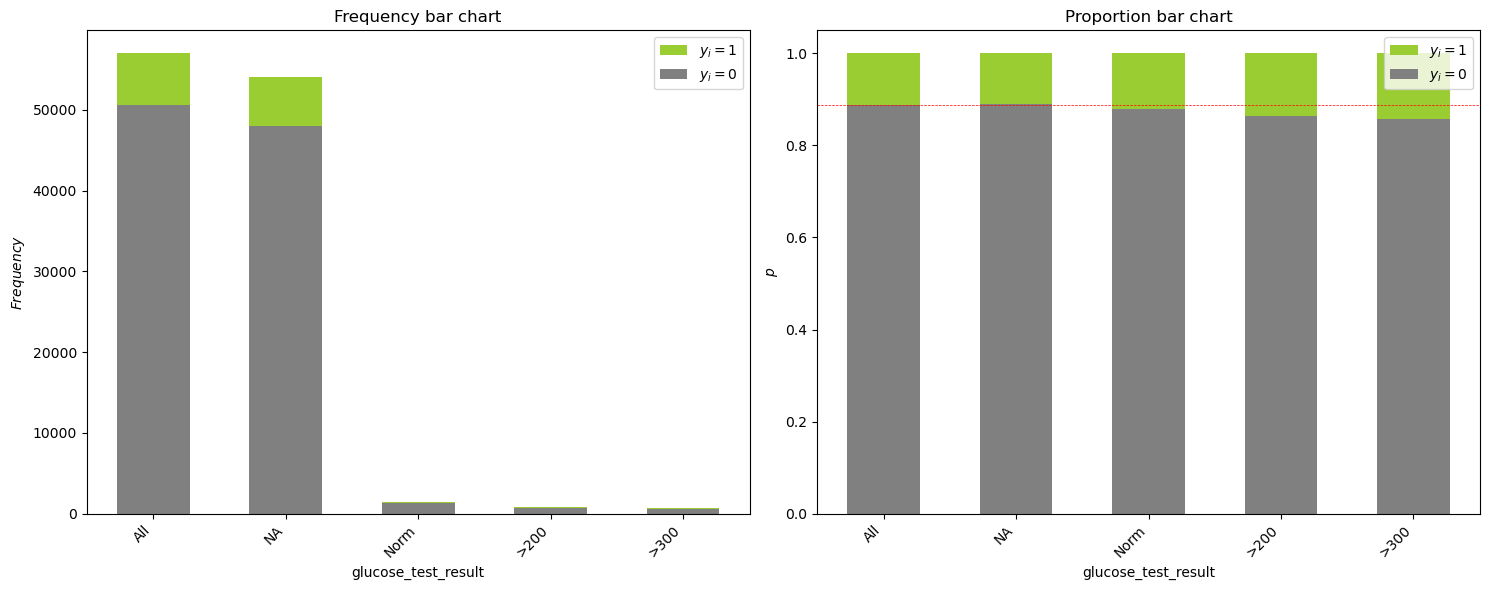

a1c_test_result
NA      47472
>8       4589
Norm     2778
>7       2149
Name: count, dtype: int64


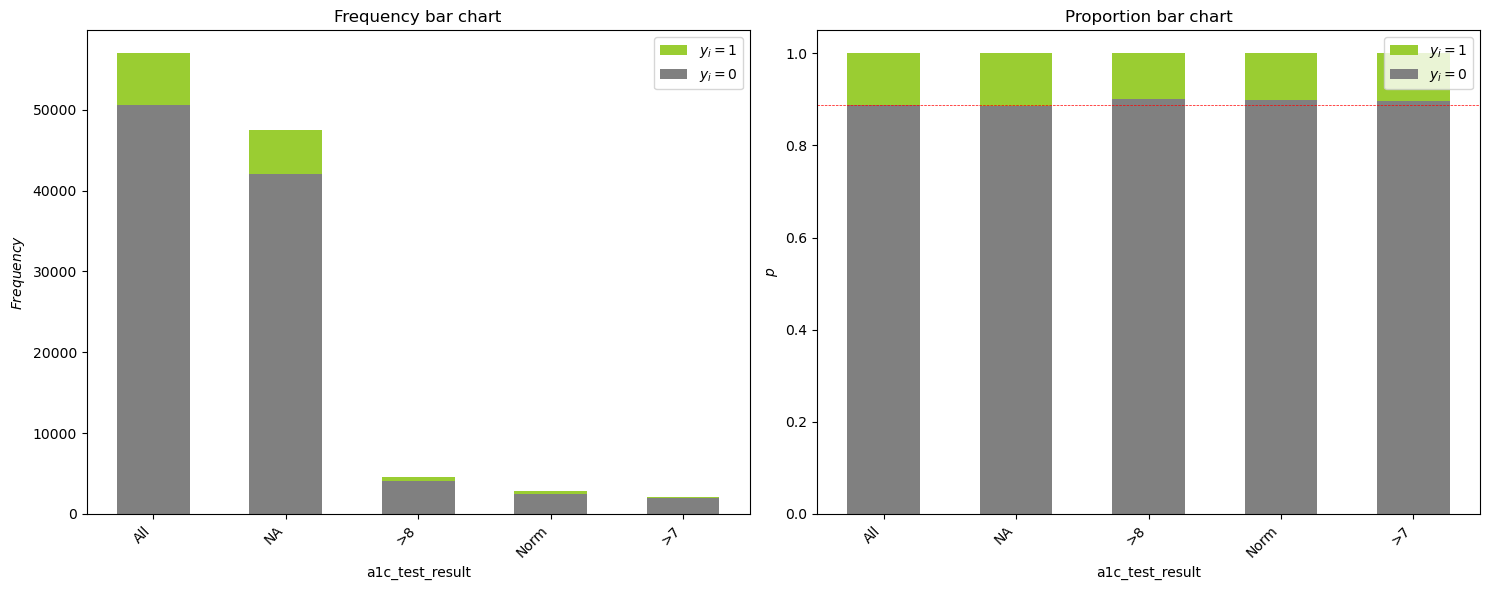

change_in_meds_during_hospitalization
No    30593
Ch    26395
Name: count, dtype: int64


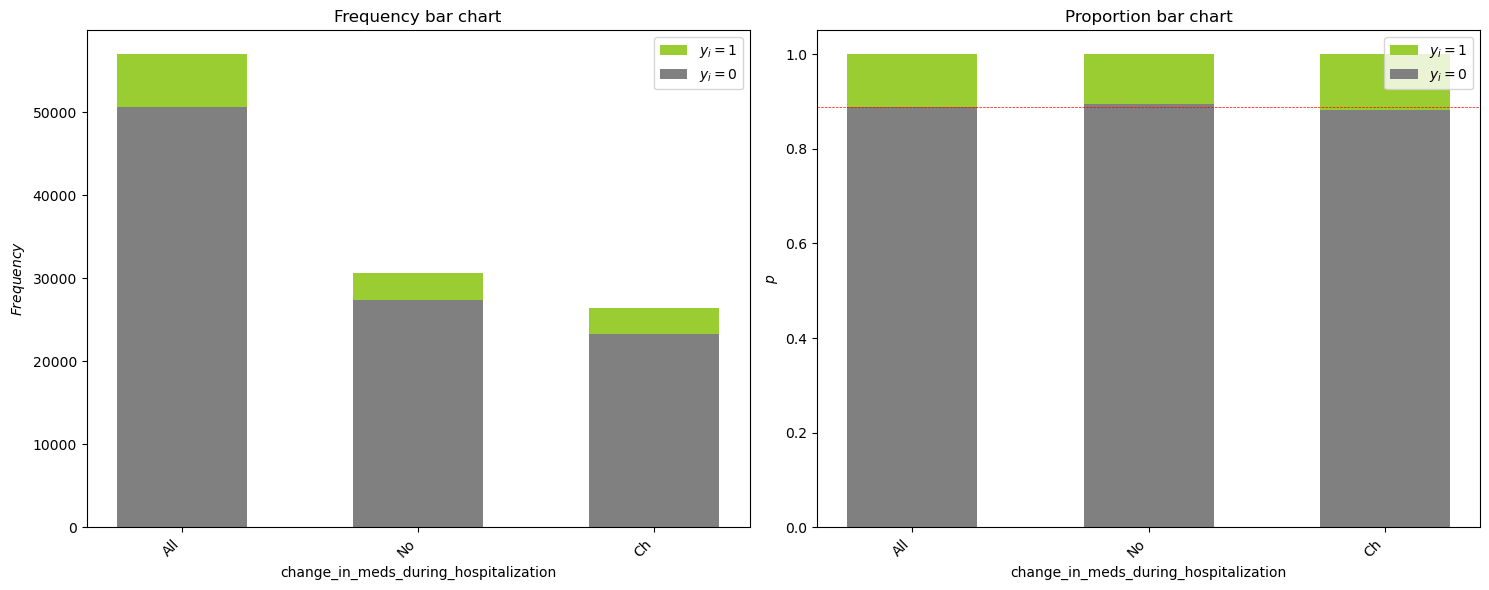

prescribed_diabetes_meds
Yes    43942
No     13046
Name: count, dtype: int64


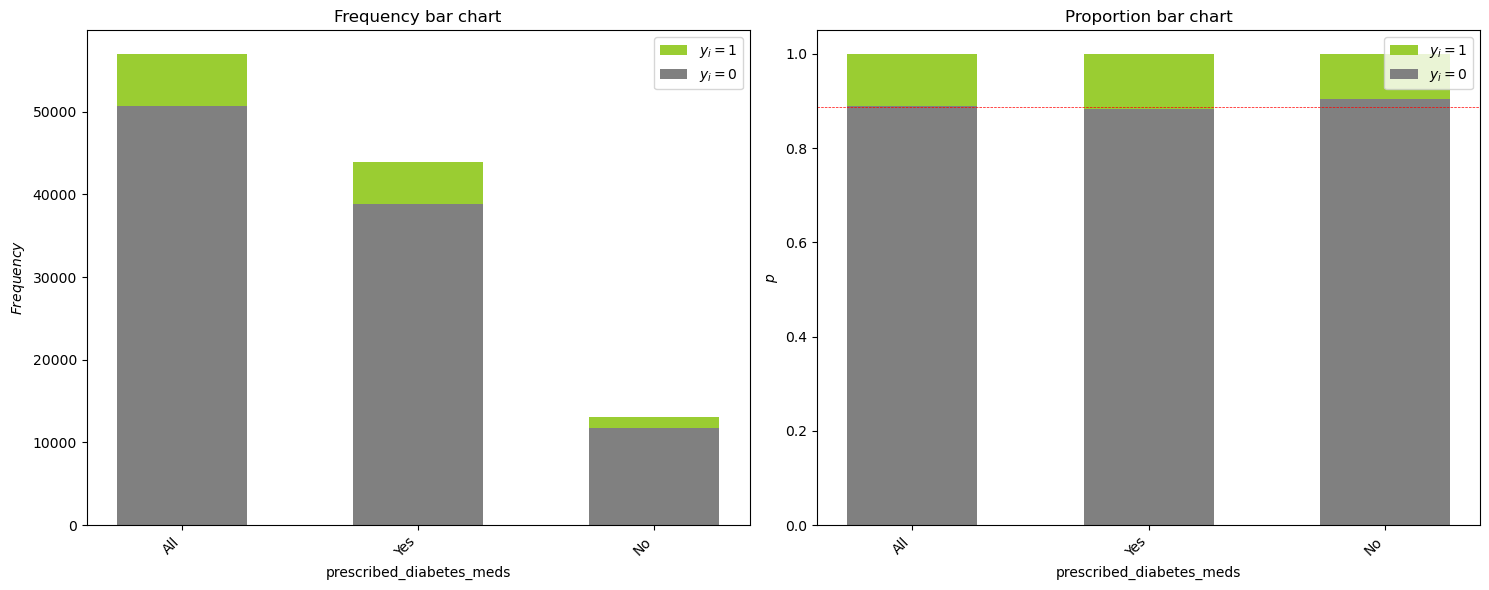

medication
['insulin']                                               17413
[]                                                        13046
['metformin']                                              2500
['metformin', 'insulin']                                   2437
['glipizide']                                              2147
                                                          ...  
['metformin', 'glipizide', 'tolazamide']                      1
['metformin', 'pioglitazone', 'acarbose']                     1
['glimepiride', 'glipizide', 'miglitol', 'insulin']           1
['insulin', 'glimepiride-pioglitazone']                       1
['metformin', 'repaglinide', 'glimepiride', 'insulin']        1
Name: count, Length: 287, dtype: int64


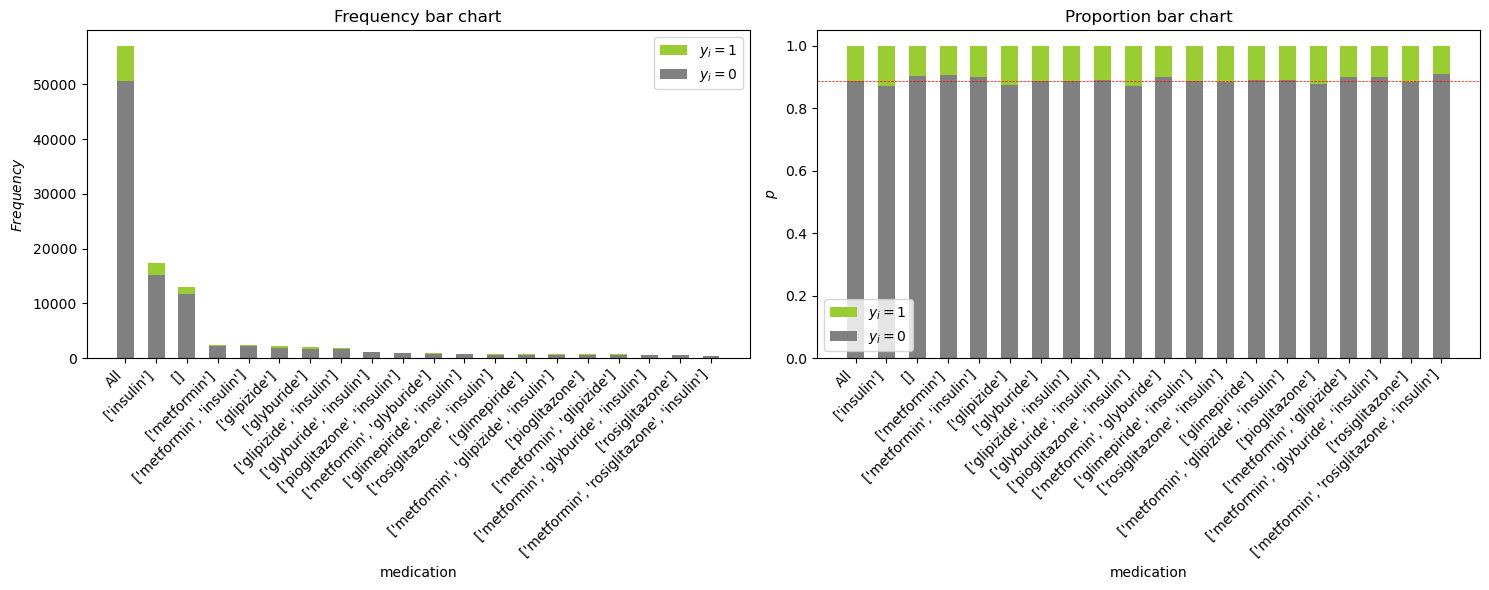

In [38]:
for col in categorical_features:
    print(X_train[col].value_counts())    
    bar_charts_categorical(all_train, col, "readmitted_binary")


In [39]:
#country drop only one category, no variance

#race, there is already category '?' so we add the NAs to the questionmark
#based on the assumption that '?' is mixed races aswell as the NAs
#frequency encoding should be the way to go since caucasian ist most relevant regarding the plots that show the relationship with different races

#gender only 2 rows unknown/Invalid -> set them to mode, female, since it's only 2, also dropping should be worth considering

#age, impute NAs with mode, 70-80, then frequency encoding since ordinal encoding makes no sense regarding the correlation with the target variable

#weight, since a lot of NAs might be droppable, for now we leave NAs as ? and give it for the feature selection

#same for test results a1c and glucose, here NAs might be not taken tests

#payer code, target encoding or frequency encoding

#admission type, clear correlation between frequency and target binary, frequency encoding

#medical specialty, frequency encoding

#discarge disposiotion, frequency or target encdoing

Categorical Preprocessing 1

In [40]:
#we aggregate low cardinalities to a category called other
#the choice for low cardinalities is baes on the value count inspection, in general the cutoff line is nearby 0.5% of the number of rows of the train dataset
#this way we avoid havining categories with low cardinalities with might lead to random impacts in the models, we increase robustness
#a problem might be too much aggregation and therefore lack of information

#country
X_train.drop(columns='country', inplace=True)

#race
X_train.loc[X_train['race']=='NA', 'race'] = '?'

#gender
X_train.loc[X_train['gender']=='Unknown/Invalid', 'gender'] = 'Female'

#age
X_train.loc[X_train['age']=='NA', 'age'] = '[70-80)'

#weight
other = ['[125-150)', '[25-50)', '[0-25)', '[150-175)', '[175-200)', '>200 ']
X_train['weight'] = X_train['weight'].replace(other, 'other')

#payercode
other = ['CH', 'WC', 'OT', 'MP', 'SI', 'FR']
X_train['payer_code'] = X_train['payer_code'].replace(other, 'other')


#admission_type
X_train.loc[X_train['admission_type']=='NA', 'admission_type'] = 'Not Mapped'
other = ['Not Mapped', 'Trauma Center', 'Newborn']
X_train['admission_type'] = X_train['admission_type'].replace(other, 'other')


#discharge_disposition
X_train.loc[X_train['discharge_disposition']=='NA', 'discharge_disposition'] = 'Not Mapped'
category_counts = X_train['discharge_disposition'].value_counts()
other_discharge= category_counts[category_counts < X_train.shape[0] * 0.005].index
X_train['discharge_disposition'] = X_train['discharge_disposition'].replace(other_discharge, 'other')

#medical_specialty
X_train.loc[X_train['medical_specialty']=='NA', 'medical_specialty'] = 'Not Mapped'
category_counts = X_train['medical_specialty'].value_counts()
other_medical_specialty = category_counts[category_counts < X_train.shape[0] * 0.005].index
X_train['medical_specialty'] = X_train['medical_specialty'].replace(other_medical_specialty , 'other')


#admission_source
X_train.loc[X_train['admission_source']=='NA', 'admission_source'] = 'Not Mapped'
X_train.loc[X_train['admission_source']=='Not Available', 'admission_source'] = 'Not Mapped'

other= ['HMO Referral', 'Court/Law Enforcement', 'Transfer from hospital inpt/same fac reslt in a sep claim', 'Transfer from critial access hospital', 'Transfer from Ambulatory Surgery Center', 'Extramural Birth', 'Normal Delivery', 'Sick Baby']
X_train['admission_source'] = X_train['admission_source'].replace(other, 'other')

#medication
category_counts = X_train['medication'].value_counts()
other_med = category_counts[category_counts < X_train.shape[0] * 0.005].index
X_train['medication'] = X_train['medication'].replace(other_med, 'other')

In [41]:
#for the diagnosis, since it's too many categories, aggregate the icd 9 codes regarding there icd 9 class to aggregate the categories
#this way we have more stable frequencies, but maybe loose some information threw aggregation, but we take the tradeoff

icd9_mapping = {
    'Infectious and Parasitic Diseases': (1, 139),
    'Neoplasms': (140, 239),
    'Endocrine, Nutritional, Metabolic Diseases, and Immunity Disorders': (240, 279),
    'Diseases of the Blood and Blood-Forming Organs': (280, 289),
    'Mental Disorders': (290, 319),
    'Diseases of the Nervous System and Sense Organs': (320, 389),
    'Diseases of the Circulatory System': (390, 459),
    'Diseases of the Respiratory System': (460, 519),
    'Diseases of the Digestive System': (520, 579),
    'Diseases of the Genitourinary System': (580, 629),
    'Complications of Pregnancy, Childbirth, and the Puerperium': (630, 679),
    'Diseases of the Skin and Subcutaneous Tissue': (680, 709),
    'Diseases of the Musculoskeletal System and Connective Tissue': (710, 739),
    'Congenital Anomalies': (740, 759),
    'Certain Conditions Originating in the Perinatal Period': (760, 779),
    'Symptoms, Signs, and Ill-Defined Conditions': (780, 799),
    'Injury and Poisoning': (800, 999),
    'External Causes of Injury': ('E',),
    'Supplemental Classification': ('V',)
}

def map_icd9_code(icd9_code, icd9_mapping):
    # Check for 'E' and 'V' codes
    if icd9_code.startswith('E'):
        return 'External Causes of Injury'
    
    if icd9_code.startswith('V'):
        return 'Supplemental Classification'
    
    if '250' in icd9_code: #since we know diabetes is important for hospital readmission we encode them seperately
        return 'Diabetes'
    
    for category, code_range in icd9_mapping.items():
        if icd9_code.isdigit():
            start, end = code_range
            if start <= int(icd9_code) <= end:
                return category
    
    if icd9_code == '?':
        return icd9_code
    
    return 'other'

In [42]:
X_train['primary_icd9_class'] = X_train['primary_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))
X_train['secondary_icd9_class'] = X_train['secondary_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))
X_train['additional_icd9_class'] = X_train['additional_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))

X_train.drop(columns = ['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis'], inplace=True)

primary_icd9_class
Diseases of the Circulatory System                                    17072
Diseases of the Respiratory System                                     5872
Diseases of the Digestive System                                       5217
Diabetes                                                               4871
Symptoms, Signs, and Ill-Defined Conditions                            4271
Injury and Poisoning                                                   3928
Diseases of the Genitourinary System                                   2825
Diseases of the Musculoskeletal System and Connective Tissue           2714
Neoplasms                                                              1949
Infectious and Parasitic Diseases                                      1577
Endocrine, Nutritional, Metabolic Diseases, and Immunity Disorders     1447
Diseases of the Skin and Subcutaneous Tissue                           1362
Mental Disorders                                                     

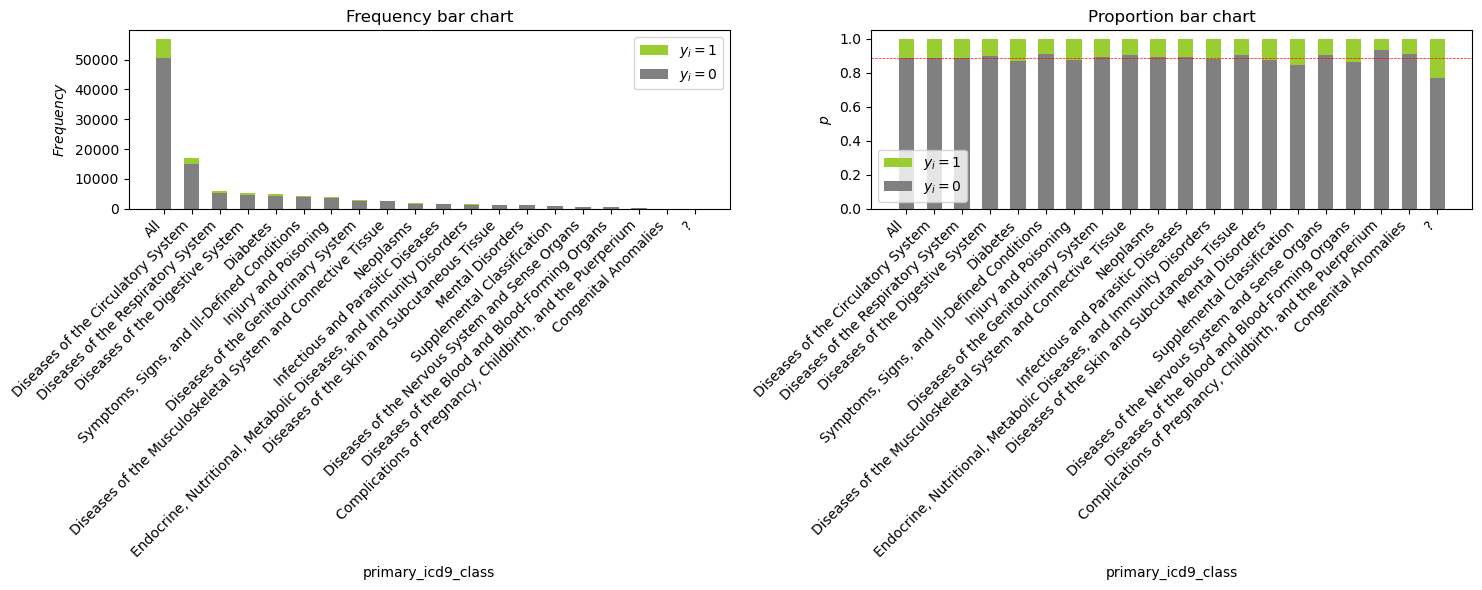

secondary_icd9_class
Diseases of the Circulatory System                                    17596
Diabetes                                                               7140
Diseases of the Respiratory System                                     5720
Endocrine, Nutritional, Metabolic Diseases, and Immunity Disorders     4597
Diseases of the Genitourinary System                                   4458
Symptoms, Signs, and Ill-Defined Conditions                            2563
Diseases of the Digestive System                                       2227
Diseases of the Skin and Subcutaneous Tissue                           2047
Diseases of the Blood and Blood-Forming Organs                         1621
Mental Disorders                                                       1486
Neoplasms                                                              1431
Injury and Poisoning                                                   1387
Infectious and Parasitic Diseases                                  

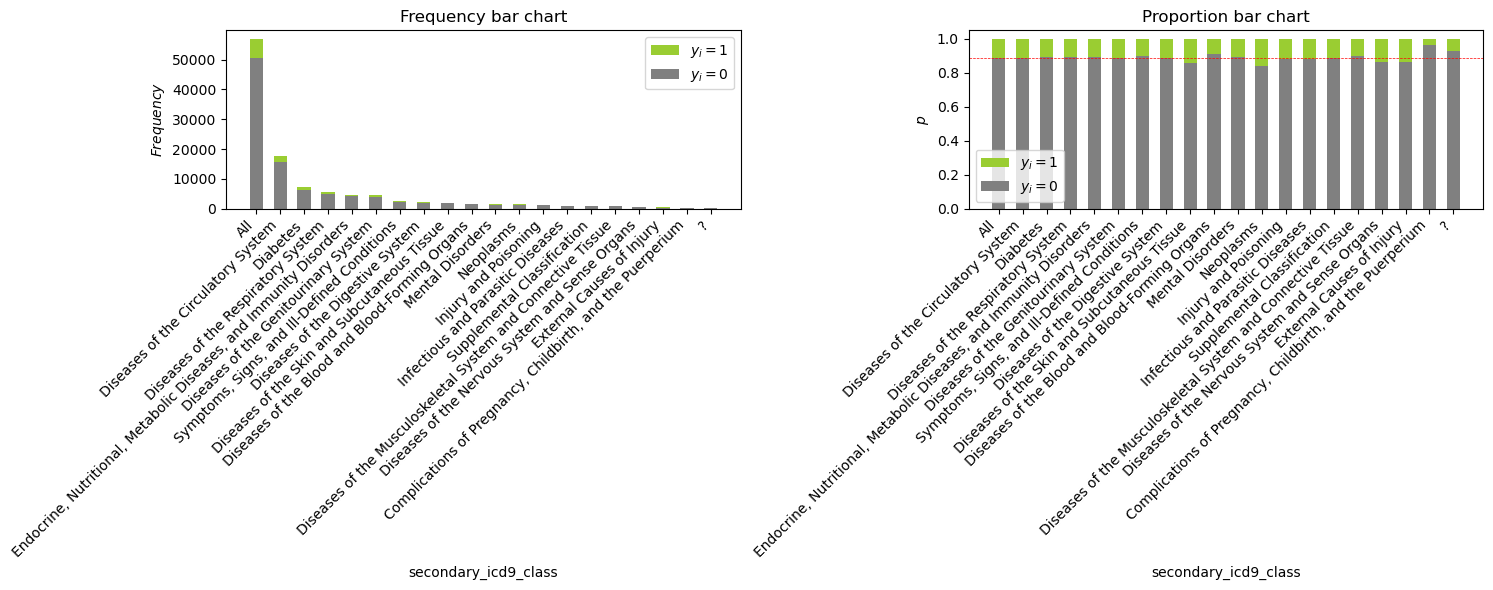

additional_icd9_class
Diseases of the Circulatory System                                    16751
Diabetes                                                               9497
Endocrine, Nutritional, Metabolic Diseases, and Immunity Disorders     5095
Diseases of the Respiratory System                                     3782
Diseases of the Genitourinary System                                   3578
Symptoms, Signs, and Ill-Defined Conditions                            2494
Supplemental Classification                                            2130
Diseases of the Digestive System                                       2015
Mental Disorders                                                       1779
Diseases of the Blood and Blood-Forming Organs                         1411
Diseases of the Skin and Subcutaneous Tissue                           1403
Injury and Poisoning                                                   1131
Infectious and Parasitic Diseases                                 

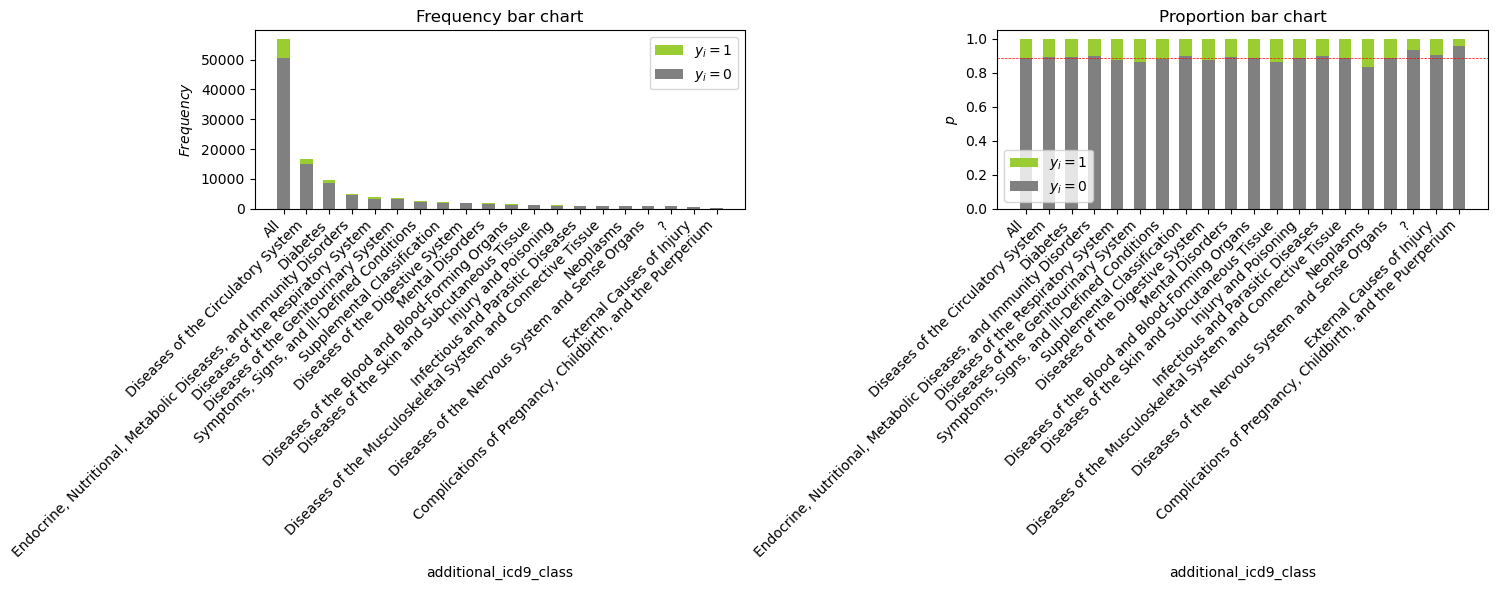

In [43]:
all_train = X_train.join(y_train)
for col in ['primary_icd9_class', 'secondary_icd9_class', 'additional_icd9_class']:
    print(all_train[col].value_counts())    
    bar_charts_categorical(all_train, col, "readmitted_binary")

In [44]:
#we decide to do frequency encoding for every feature with a number of categories >2, otherwise we use one hot encoding
#this way we keep our input space very small and avoid a sparse dataset, also we can include the features in the Feature Selection process with the
#numerical features without risking too long runtimes
#a disadvantage of this encoding tecnique might be a loss of information in comparison to one hot encoding every variable

categorical_features = X_train.select_dtypes(exclude=np.number).columns
binary_encoding_columns = ['gender', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds']
frequency_encoding_columns = list(set(categorical_features)-set(binary_encoding_columns))

In [45]:
X_train['gender'] = X_train['gender'].replace({'Female':1, 'Male':0})
X_train['change_in_meds_during_hospitalization'] = X_train['change_in_meds_during_hospitalization'].replace({'Ch':1, 'No':0})
X_train['prescribed_diabetes_meds'] = X_train['prescribed_diabetes_meds'].replace({'Yes':1, 'No':0})

In [46]:
#preprocessing for validation set

#NAs beginning
categorical_features = X_val.select_dtypes(exclude=np.number).columns
X_val[categorical_features] = X_val[categorical_features].fillna('NA')

#country
X_val.drop(columns='country', inplace=True)

#race
X_val.loc[X_val['race']=='NA', 'race'] = '?'

#gender
X_val.loc[X_val['gender']=='Unknown/Invalid', 'gender'] = 'Female'

#age
X_val.loc[X_val['age']=='NA', 'age'] = '[70-80)'

#weight
other = ['[125-150)', '[25-50)', '[0-25)', '[150-175)', '[175-200)', '>200 ']
X_val['weight'] = X_val['weight'].replace(other, 'other')

#payercode
other = ['CH', 'WC', 'OT', 'MP', 'SI', 'FR']
X_val['payer_code'] = X_val['payer_code'].replace(other, 'other')

#admission_type
X_val.loc[X_val['admission_type']=='NA', 'admission_type'] = 'Not Mapped'
other = ['Not Mapped', 'Trauma Center', 'Newborn']
X_val['admission_type'] = X_val['admission_type'].replace(other, 'other')

#discharge disposition
X_val.loc[X_val['discharge_disposition']=='NA', 'discharge_disposition'] = 'Not Mapped'
X_val['discharge_disposition'] = X_val['discharge_disposition'].replace(other_discharge, 'other')

#medical specialty
X_val['medical_specialty'] = X_val['medical_specialty'].replace(other_medical_specialty, 'other')

#admission_source
X_val.loc[X_val['admission_source']=='NA', 'admission_source'] = 'Not Mapped'
X_val.loc[X_val['admission_source']=='Not Available', 'admission_source'] = 'Not Mapped'
other= ['HMO Referral', 'Court/Law Enforcement', 'Transfer from hospital inpt/same fac reslt in a sep claim', 'Transfer from critial access hospital', 'Transfer from Ambulatory Surgery Center', 'Extramural Birth', 'Normal Delivery', 'Sick Baby']
X_val['admission_source'] = X_val['admission_source'].replace(other, 'other')

#medication
X_val['medication'] = X_val['medication'].replace(other_med, 'other')

In [47]:
X_val['primary_icd9_class'] = X_val['primary_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))
X_val['secondary_icd9_class'] = X_val['secondary_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))
X_val['additional_icd9_class'] = X_val['additional_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))

X_val.drop(columns = ['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis'], inplace=True)

In [48]:
X_val['gender'] = X_val['gender'].replace({'Female':1, 'Male':0})
X_val['change_in_meds_during_hospitalization'] = X_val['change_in_meds_during_hospitalization'].replace({'Ch':1, 'No':0})
X_val['prescribed_diabetes_meds'] = X_val['prescribed_diabetes_meds'].replace({'Yes':1, 'No':0})

In [49]:
#frequency encoding for X_train and X_val together since we use the frequencies from the training set to avoid data leakage
def frequency_encode_columns(df1, df2, columns):
    frequency_mappings = {}
    
    for column in columns:
        frequency_mapping = df1[column].value_counts(normalize=True)
        frequency_mappings[column] = frequency_mapping
    
    for column, mapping in frequency_mappings.items():
        df1[column] = df1[column].map(mapping)
        df2[column] = df2[column].map(mapping).fillna(0)  # Fill NaN with 0 for unseen categories in validation set
    
    return df1, df2


X_train, X_val = frequency_encode_columns(X_train, X_val, columns=frequency_encoding_columns)

Preprocessing together

In [50]:
#scale the numerical and frequencie endoed features
features_to_scale = list(list(frequency_encoding_columns) + list(numerical_features))

In [51]:
scaler = StandardScaler()

#we use as standardscaler since most of our distribution are skewed and standard scalers are less affected by outliers in the absence of normal distribution
scaler.fit(X_train[features_to_scale])

X_train_num_scaled = scaler.transform(X_train[features_to_scale])
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train[features_to_scale].columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val[features_to_scale])
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val[features_to_scale].columns).set_index(X_val.index)

X_train = pd.concat([X_train_num_scaled, X_train[binary_encoding_columns]], axis=1)
X_val =  pd.concat([X_val_num_scaled, X_val[binary_encoding_columns]], axis=1)


In [52]:
y_train = y_train.replace({'Yes': 1, 'No': 0})
y_val = y_val.replace({'Yes': 1, 'No': 0})

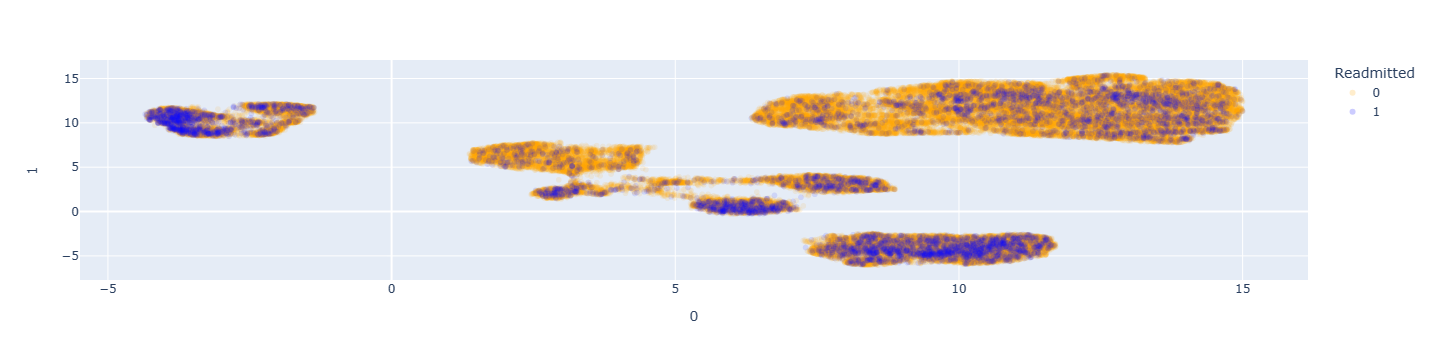

In [53]:
#try a visualization with umap to see if there are clear decision boundaries visible
#clearly there are none, but u can spot areas in the middle left and upper right where 
umap_2d = UMAP(n_components=2, random_state=0)
proj_2d = umap_2d.fit_transform(X_train_num_scaled[numerical_features])
fig = px.scatter(proj_2d, x=0, y=1, color=y_train.astype(str), opacity=0.1,
                 color_discrete_map={'1': 'blue', '0': 'orange'},
                 labels={'color': 'Readmitted'})
fig.show()

Feature Selection Categorical

In [54]:
Feature_selection = pd.DataFrame(index=X_train.columns)

In [55]:
#General Idea: we use 5 Feature Selection methods and decide which features to keep by majority vote

In [56]:
#Mutual Information

In [57]:
# we get the values of the mutual info classification for each variable by using select k with all features
#we are not selecting them yet, just getting the mi scores

k_best = SelectKBest(score_func=lambda X, y: mutual_info_classif(X, y, random_state=0), k=len(X_train.columns))
X_train_selected = k_best.fit_transform(X_train, y_train)
selected_feature_indices = k_best.get_support(indices=True)
selected_feature_names = X_train.columns[selected_feature_indices]
mi_scores = k_best.scores_
feature_selection = pd.DataFrame({'Feature': selected_feature_names, 'MI_score': mi_scores})
feature_selection.set_index('Feature', inplace=True)
feature_selection.sort_values(by='MI_score', ascending=False, inplace=True)

In [58]:
#LassoCV

In [59]:
#also we use lasso cv to see which variables the l1 regularization would exclude / set parameters to 0
reg = LassoCV()
reg.fit(X_train, y_train)
coef = pd.Series(reg.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
coef

Lasso picked 19 variables and eliminated the other 10 variables


weight                                  -0.000000
medical_specialty                        0.000885
a1c_test_result                          0.000000
age                                      0.000131
additional_icd9_class                   -0.001892
primary_icd9_class                       0.002342
admission_source                        -0.000000
secondary_icd9_class                    -0.000713
payer_code                               0.003410
glucose_test_result                     -0.000000
race                                     0.001523
admission_type                           0.000000
medication                               0.000948
discharge_disposition                   -0.016798
outpatient_visits_in_previous_year      -0.000000
emergency_visits_in_previous_year        0.007328
inpatient_visits_in_previous_year       -0.082103
average_pulse_bpm                        0.000000
length_of_stay_in_hospital              -0.000000
number_lab_tests                        -0.000000


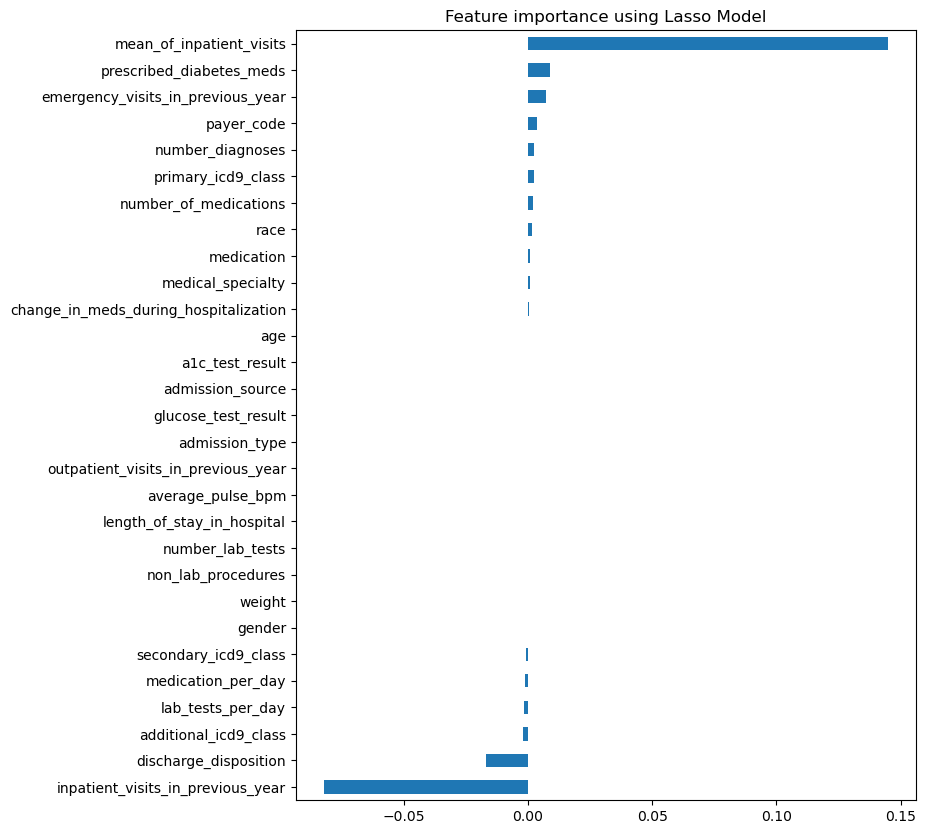

In [60]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
plot_importance(coef,'Lasso')

In [61]:
feature_selection['Lasso_cv'] = coef

In [62]:
#Mannwhitneyu / chi squared

In [63]:
#using mannwhitneyu test to get a first idea of how relevant the features are
#we also include the frequency encoded variables since we would use them the encoded way in the model aswell
#like wilcoxon test (distribution doesnt matter), also length is irrelvant (sample doesnt have to be same length)
feature_selection['Mannwhitneyu/Chisquared'] = 'X' #

for col in (list(numerical_features) + list(frequency_encoding_columns)):
    group1 = X_train_num_scaled[y_train == 1][col]
    group2 = X_train_num_scaled[y_train == 0][col]
    t_stat, p_value = mannwhitneyu(group1, group2)
    feature_selection.loc[feature_selection.index == col, 'Mannwhitneyu/Chisquared'] = p_value

In [64]:
#for the binaryl features we use the chi squared test
categorical_features = list(binary_encoding_columns) 
def TestIndependence(X,y,var,alpha=0.05):
    crosstable = pd.crosstab(y,X) 
    chi2, p_value, dof, expected = chi2_contingency(crosstable.values)
    feature_selection.loc[feature_selection.index == col, 'Mannwhitneyu/Chisquared'] = p_value
   
for col in categorical_features:
    TestIndependence(X_train[col],y_train, col)
feature_selection

MI_score  Lasso_cv  \
Feature                                                     
mean_of_inpatient_visits               0.040630  0.144819   
inpatient_visits_in_previous_year      0.014699 -0.082103   
discharge_disposition                  0.010936 -0.016798   
prescribed_diabetes_meds               0.010611  0.008830   
gender                                 0.008638 -0.000201   
medical_specialty                      0.006567  0.000885   
emergency_visits_in_previous_year      0.006288  0.007328   
race                                   0.005955  0.001523   
change_in_meds_during_hospitalization  0.005429  0.000338   
length_of_stay_in_hospital             0.004510 -0.000000   
outpatient_visits_in_previous_year     0.004475 -0.000000   
medication                             0.004321  0.000948   
admission_source                       0.004024 -0.000000   
age                                    0.003315  0.000131   
payer_code                             0.003274  0.003410   
number_diagnoses                       0.003199  0.002386   
glucose_test_result                    0.002199 -0.000000   
admission_type                         0.002045  0.000000   
a1c_test_result                        0.001655  0.000000   
secondary_icd9_class                   0.001417 -0.000713   
number_lab_tests                       0.001308 -0.000000   
number_of_medications                  0.000915  0.001865   
non_lab_procedures                     0.000645 -0.000000   
additional_icd9_class                  0.000228 -0.001892   
primary_icd9_class                     0.000145  0.002342   
weight                                 0.000114 -0.000000   
medication_per_day                     0.000000 -0.001077   
lab_tests_per_day                      0.000000 -0.001834   
average_pulse_bpm                      0.000000  0.000000   

                                      Mannwhitneyu/Chisquared  
Feature                                                        
mean_of_inpatient_visits                                  0.0  
inpatient_visits_in_previous_year                         0.0  
discharge_disposition                                     0.0  
prescribed_diabetes_meds                                  0.0  
gender                                               0.385694  
medical_specialty                                    0.000075  
emergency_visits_in_previous_year                         0.0  
race                                                 0.004617  
change_in_meds_during_hospitalization                0.000005  
length_of_stay_in_hospital                                0.0  
outpatient_visits_in_previous_year                        0.0  
medication                                                0.0  
admission_source                                     0.000124  
age                                                  0.010544  
payer_code                                           0.000041  
number_diagnoses                                          0.0  
glucose_test_result                                  0.000808  
admission_type                                       0.046078  
a1c_test_result                                      0.000401  
secondary_icd9_class                                 0.086224  
number_lab_tests                                     0.000032  
number_of_medications                                     0.0  
non_lab_procedures                                   0.031248  
additional_icd9_class                                0.010914  
primary_icd9_class                                    0.47877  
weight                                               0.952231  
medication_per_day                                    0.00057  
lab_tests_per_day                                         0.0  
average_pulse_bpm                                    0.722311

In [65]:
#we create new columnsfor the three methods used so far that suggest to keep (=1) or not to keep (=0) and sum them up
#to get an idea of how many features arerelevant at the moment
feature_selection['MI_score_>_0'] = (feature_selection['MI_score'] > 0.005).astype(int)#thresholds, seems to be a reasonable threshold
feature_selection['Lasso_cv_>_0'] = (feature_selection['Lasso_cv'].abs() > 0.0001).astype(int)#threshold 
feature_selection['Man/Chi_signif'] = (feature_selection['Mannwhitneyu/Chisquared'] < 0.05 ).astype(int)
feature_selection['sum'] = feature_selection['MI_score_>_0'] + feature_selection['Lasso_cv_>_0'] + feature_selection['Man/Chi_signif']

In [66]:
feature_selection.sort_values(by='sum', ascending=False)

MI_score  Lasso_cv  \
Feature                                                     
mean_of_inpatient_visits               0.040630  0.144819   
inpatient_visits_in_previous_year      0.014699 -0.082103   
discharge_disposition                  0.010936 -0.016798   
prescribed_diabetes_meds               0.010611  0.008830   
medical_specialty                      0.006567  0.000885   
emergency_visits_in_previous_year      0.006288  0.007328   
race                                   0.005955  0.001523   
change_in_meds_during_hospitalization  0.005429  0.000338   
lab_tests_per_day                      0.000000 -0.001834   
medication_per_day                     0.000000 -0.001077   
additional_icd9_class                  0.000228 -0.001892   
number_of_medications                  0.000915  0.001865   
number_diagnoses                       0.003199  0.002386   
payer_code                             0.003274  0.003410   
age                                    0.003315  0.000131   
medication                             0.004321  0.000948   
gender                                 0.008638 -0.000201   
admission_source                       0.004024 -0.000000   
glucose_test_result                    0.002199 -0.000000   
admission_type                         0.002045  0.000000   
a1c_test_result                        0.001655  0.000000   
secondary_icd9_class                   0.001417 -0.000713   
number_lab_tests                       0.001308 -0.000000   
non_lab_procedures                     0.000645 -0.000000   
outpatient_visits_in_previous_year     0.004475 -0.000000   
primary_icd9_class                     0.000145  0.002342   
length_of_stay_in_hospital             0.004510 -0.000000   
weight                                 0.000114 -0.000000   
average_pulse_bpm                      0.000000  0.000000   

                                      Mannwhitneyu/Chisquared  MI_score_>_0  \
Feature                                                                       
mean_of_inpatient_visits                                  0.0             1   
inpatient_visits_in_previous_year                         0.0             1   
discharge_disposition                                     0.0             1   
prescribed_diabetes_meds                                  0.0             1   
medical_specialty                                    0.000075             1   
emergency_visits_in_previous_year                         0.0             1   
race                                                 0.004617             1   
change_in_meds_during_hospitalization                0.000005             1   
lab_tests_per_day                                         0.0             0   
medication_per_day                                    0.00057             0   
additional_icd9_class                                0.010914             0   
number_of_medications                                     0.0             0   
number_diagnoses                                          0.0             0   
payer_code                                           0.000041             0   
age                                                  0.010544             0   
medication                                                0.0             0   
gender                                               0.385694             1   
admission_source                                     0.000124             0   
glucose_test_result                                  0.000808             0   
admission_type                                       0.046078             0   
a1c_test_result                                      0.000401             0   
secondary_icd9_class                                 0.086224             0   
number_lab_tests                                     0.000032             0   
non_lab_procedures                                   0.031248             0   
outpatient_visits_in_previous_year                        0.0             0   
primary_icd9_c

In [67]:
feature_selection[feature_selection['sum'] <2] #features we would drop based on the methods used so far


MI_score  Lasso_cv  \
Feature                                                  
length_of_stay_in_hospital          0.004510 -0.000000   
outpatient_visits_in_previous_year  0.004475 -0.000000   
admission_source                    0.004024 -0.000000   
glucose_test_result                 0.002199 -0.000000   
admission_type                      0.002045  0.000000   
a1c_test_result                     0.001655  0.000000   
secondary_icd9_class                0.001417 -0.000713   
number_lab_tests                    0.001308 -0.000000   
non_lab_procedures                  0.000645 -0.000000   
primary_icd9_class                  0.000145  0.002342   
weight                              0.000114 -0.000000   
average_pulse_bpm                   0.000000  0.000000   

                                   Mannwhitneyu/Chisquared  MI_score_>_0  \
Feature                                                                    
length_of_stay_in_hospital                             0.0             0   
outpatient_visits_in_previous_year                     0.0             0   
admission_source                                  0.000124             0   
glucose_test_result                               0.000808             0   
admission_type                                    0.046078             0   
a1c_test_result                                   0.000401             0   
secondary_icd9_class                              0.086224             0   
number_lab_tests                                  0.000032             0   
non_lab_procedures                                0.031248             0   
primary_icd9_class                                 0.47877             0   
weight                                            0.952231             0   
average_pulse_bpm                                 0.722311             0   

                                    Lasso_cv_>_0  Man/Chi_signif  sum  
Feature                                                                
length_of_stay_in_hospital                     0               1    1  
outpatient_visits_in_previous_year             0               1    1  
admission_source                               0               1    1  
glucose_test_result                            0               1    1  
admission_type                                 0               1    1  
a1c_test_result                                0               1    1  
secondary_icd9_class                           1               0    1  
number_lab_tests                               0               1    1  
non_lab_procedures                             0               1    1  
primary_icd9_class                             1               0    1  
weight                                         0               0    0  
average_pulse_bpm                              0               0    0

In [68]:
#RFE Logreg

In [69]:
#now we are using two recursive feature elimination models
#we start with a logistic regression, followed by a decision tree
#the logistic regression is supposed to represent the distance based, the decision tree to represent the tree based methods in the majority vote

#we give a parameter grid to the for loop in which we first do a cross grid search for each number of features to get appropriate parameters
#then we get the cross validation scores for each number of features and compare them
#we dont use the validation set to avoid data leakage

In [70]:
param_grid = {
    'solver': ['lbfgs','liblinear','saga', 'newton-cg','newton-cholesky', 'saga'],
    'penalty': ['l2'],
    'C': [0.5, 1, 2]
}
#we choose l2 regularization cause l1 regularization is already involved in the lasso cv

# Variables to store results
avg_val_scores = []
best_params_list = []
min = 1

for n in range(min, len(X_train.columns) + 1):
    model = LogisticRegression(random_state=0, class_weight='balanced')

    rfe = RFE(estimator=model, n_features_to_select=n)
    X_train_rfe = rfe.fit_transform(X_train, y_train)

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), scoring='f1')
    grid_search.fit(X_train_rfe, y_train)

    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_
    best_params_list.append(best_params)
    # Use the best hyperparameters to train the model
    model = LogisticRegression(**best_params, random_state=0, class_weight='balanced')
    val_scores = cross_val_score(model, X_train_rfe, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), scoring='f1')

    # Store the average validation score
    avg_val_score = np.mean(val_scores)
    avg_val_scores.append(avg_val_score)
    print(avg_val_score)


# Find the index of the best average validation score
best_nof_index = np.argmax(avg_val_scores)

# Get the corresponding number of features and features to select
best_nof = best_nof_index +  min  # Since the loop starts from 1
best_params = best_params_list[best_nof_index]
model = LogisticRegression(**best_params, random_state=0, class_weight='balanced')
best_features_to_select = pd.Series(RFE(estimator=model, n_features_to_select=best_nof).fit(X_train, y_train).support_, index=X_train.columns)


print("Optimum number of features:", best_nof)
print("Best hyperparameters:", best_params)
print("Average validation score with %d features: %f" % (best_nof, avg_val_scores[best_nof_index]))
print(f"Best features to select: \n{best_features_to_select}")

0.2948819466591823
0.33684891339338907
0.3336992918569278
0.3363892780789822
0.3335592053249773
0.33395327868857827
0.3355546494961881
0.33569702899921866
0.3357024533559168
0.3354387461165117
0.3357812124437686
0.3357790659255372
0.3356154554902846
0.33535044801655706
0.3352448517734422
0.33567452453344393
0.33505434478859697
0.33484212453328943
0.3360745518929261
0.3358238059719616
0.33540489053513567
0.334626599661133
0.3349147533237497
0.33455226919773046
0.3347597775699665
0.33474700734888396
0.3345277901097249
0.3341926248261585
0.3343173802401723
Optimum number of features: 2
Best hyperparameters: {'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
Average validation score with 2 features: 0.336849
Best features to select: 
weight                                   False
medical_specialty                        False
a1c_test_result                          False
age                                      False
additional_icd9_class                    False
primary_icd9_class           

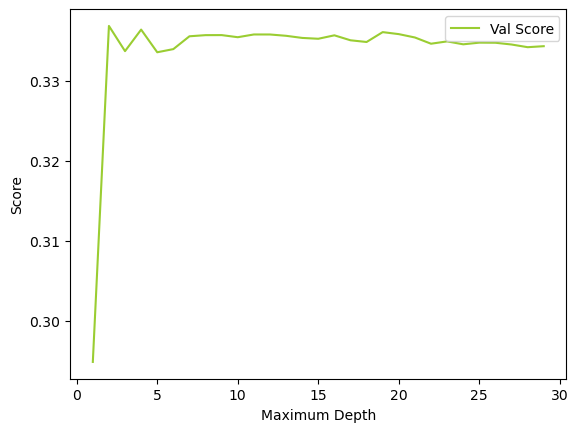

In [71]:
plt.plot(list(range(min, len(X_train.columns) + 1)), avg_val_scores, label="Val Score", color='yellowgreen')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

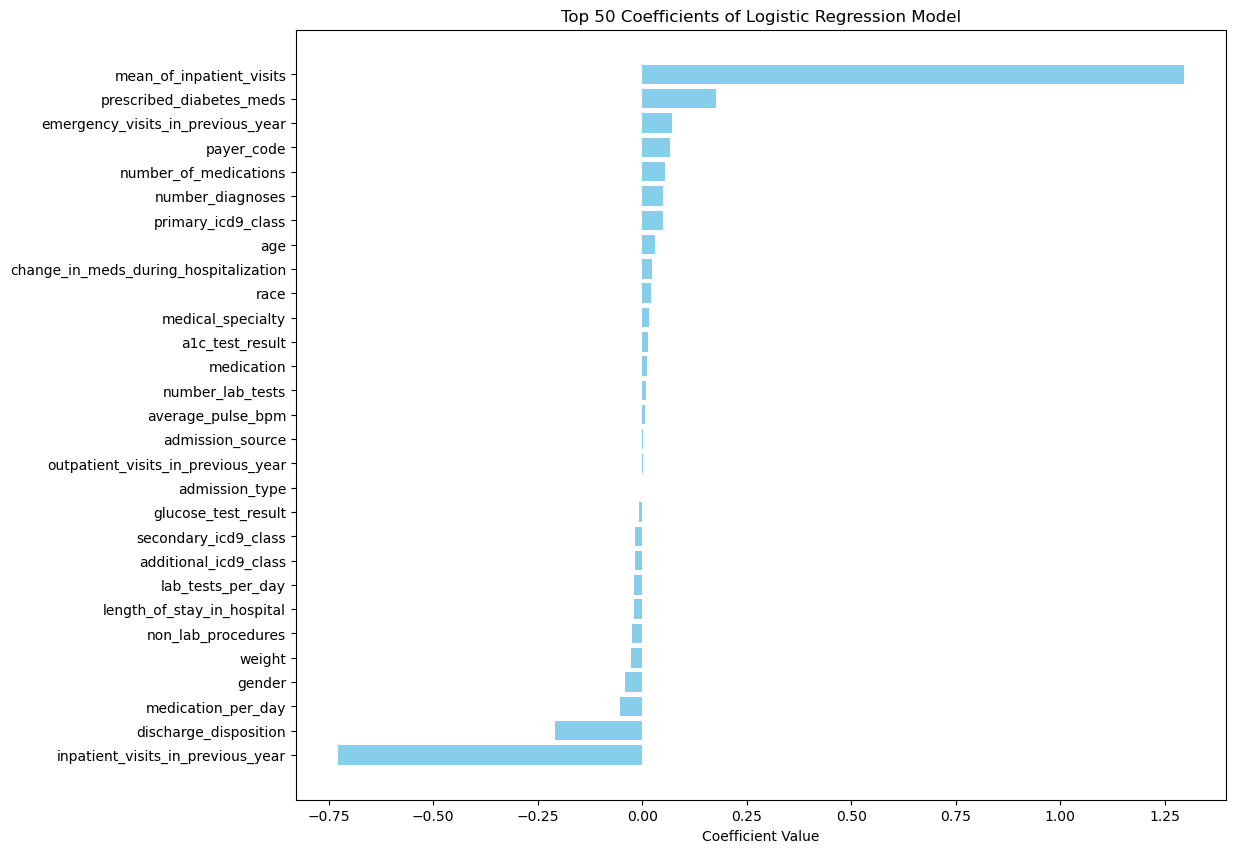

In [72]:
model.fit(X_train_rfe, y_train)
coef_df = pd.DataFrame({'feature': X_train.columns, 'coef': model.coef_[0]})
coef_df['abs_coef'] = np.abs(coef_df['coef'])

sorted_coef_df = coef_df.sort_values(by='coef', ascending=True)
sorted_coef_df = sorted_coef_df
# Plot the top 50 coefficients
plt.figure(figsize=(12, 10))
plt.barh(sorted_coef_df['feature'], sorted_coef_df['coef'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Top 50 Coefficients of Logistic Regression Model')
plt.show()

In [73]:
feature_selection['RFE_log'] = best_features_to_select.replace({True:1, False:0}) #1 if true to use for majority vote later on

In [74]:
#RFE RF

In [75]:
#we do the same for a decision tree

In [76]:
param_grid = {
    'max_depth': [3,6,9],
    'splitter' : ['random', 'best'],
    'criterion' : ['gini', 'entropy']
}
#min sample leafes shouldnt be relevant regarding size of dataset and max_depth parameters


# Variables to store results
avg_val_scores = []
best_params_list = []

for n in range(min, len(X_train.columns) + 1):
    model = DecisionTreeClassifier(random_state=0, class_weight='balanced')

    rfe = RFE(estimator=model, n_features_to_select=n)
    X_train_rfe = rfe.fit_transform(X_train, y_train)

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), scoring='f1')
    grid_search.fit(X_train_rfe, y_train)

    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_
    best_params_list.append(best_params)

    # Use the best hyperparameters to train the model
    model = DecisionTreeClassifier(**best_params, random_state=0, class_weight='balanced')
    val_scores = cross_val_score(model, X_train_rfe, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), scoring='f1')
    
    # Store the average validation score
    avg_val_score = np.mean(val_scores)
    avg_val_scores.append(avg_val_score)
    print(avg_val_score)
    

best_nof_index = np.argmax(avg_val_scores)
best_nof = best_nof_index +  min 
best_params = best_params_list[best_nof_index]

model = DecisionTreeClassifier(**best_params, random_state=0, class_weight='balanced')
best_features_to_select = pd.Series(RFE(estimator=model, n_features_to_select=best_nof).fit(X_train, y_train).support_, index=X_train.columns)

print("Optimum number of features:", best_nof)
print("Best hyperparameters:", best_params)
print("Average validation score with %d features: %f" % (best_nof, avg_val_scores[best_nof_index]))
print(f"Best features to select: \n{best_features_to_select}")


0.19613422075598672
0.2048627973365012
0.20678888773228365
0.33003427925061357
0.33003427925061357
0.33003427925061357
0.33003427925061357
0.33003427925061357
0.33003427925061357
0.33003427925061357
0.33003427925061357
0.36951435906695534
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
0.3679509931882188
Optimum number of features: 12
Best hyperparameters: {'criterion': 'entropy', 'max_depth': 6, 'splitter': 'best'}
Average validation score with 12 features: 0.369514
Best features to select: 
weight                                   False
medical_specialty                        False
a1c_test_result                          False
age                                       True
additional_icd9_class                    False
primary_icd

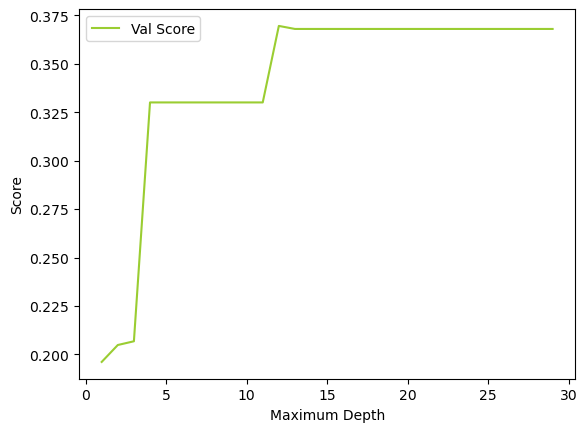

In [77]:
plt.plot(list(range(min, len(X_train.columns) + 1)), avg_val_scores, label="Val Score", color='yellowgreen')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

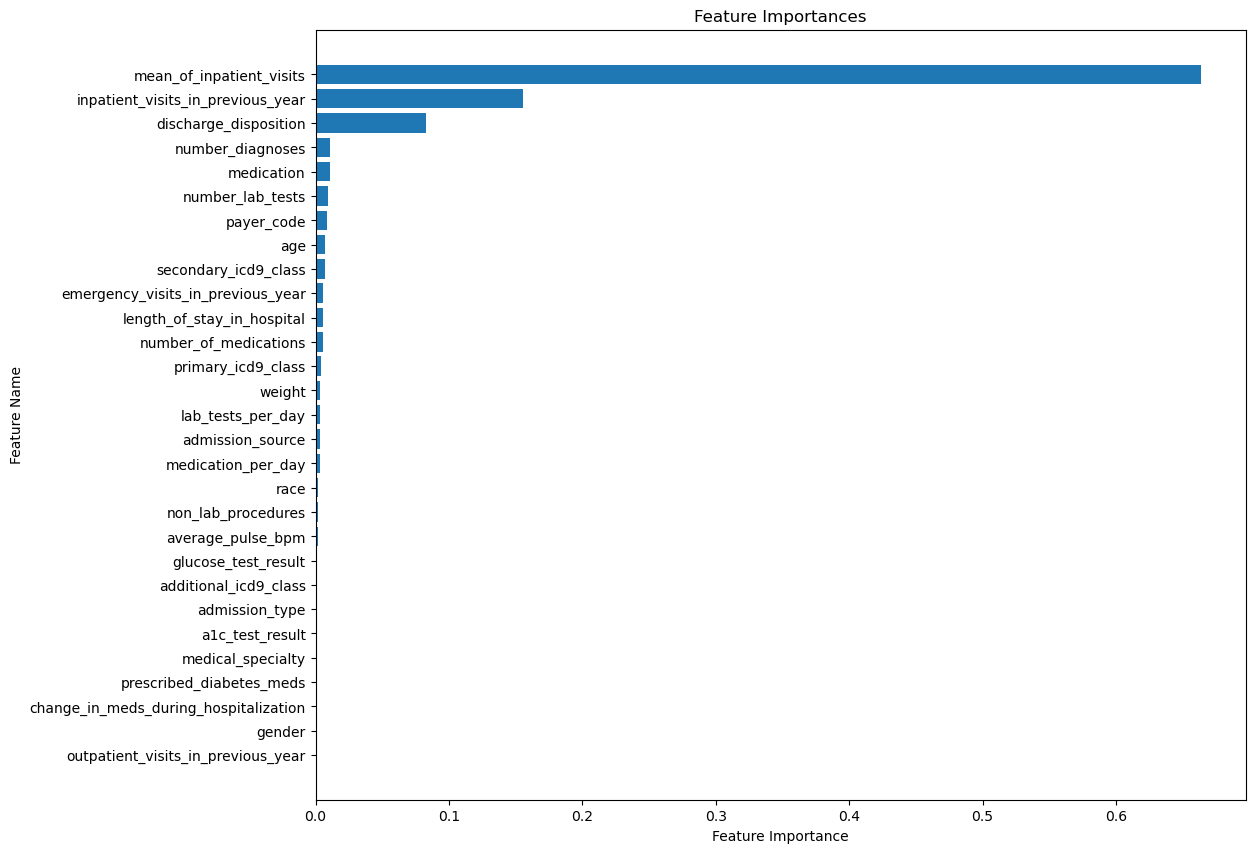

In [78]:
model.fit(X_train_rfe, y_train)
feature_importances = model.feature_importances_

sorted_indices = np.argsort(feature_importances)

if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns
else:
    feature_names = [f"Feature_{i}" for i in range(X_train_num_scaled.shape[1])]

feature_names = feature_names[sorted_indices]

plt.figure(figsize=(12, 10))
plt.title("Feature Importances")
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices])
plt.yticks(range(len(sorted_indices)), feature_names) #, rotation=90
plt.ylabel("Feature Name")
plt.xlabel("Feature Importance")
plt.show()

In [79]:
feature_selection['RFE_dt'] = best_features_to_select.replace({True:1, False:0})

In [80]:
feature_selection['sum'] = feature_selection['sum'] + feature_selection['RFE_log'] + feature_selection['RFE_dt']

In [81]:
feature_selection.sort_values(by='sum', ascending=False)

MI_score  Lasso_cv  \
Feature                                                     
mean_of_inpatient_visits               0.040630  0.144819   
inpatient_visits_in_previous_year      0.014699 -0.082103   
discharge_disposition                  0.010936 -0.016798   
emergency_visits_in_previous_year      0.006288  0.007328   
medication                             0.004321  0.000948   
number_of_medications                  0.000915  0.001865   
number_diagnoses                       0.003199  0.002386   
age                                    0.003315  0.000131   
payer_code                             0.003274  0.003410   
change_in_meds_during_hospitalization  0.005429  0.000338   
race                                   0.005955  0.001523   
medical_specialty                      0.006567  0.000885   
prescribed_diabetes_meds               0.010611  0.008830   
length_of_stay_in_hospital             0.004510 -0.000000   
number_lab_tests                       0.001308 -0.000000   
lab_tests_per_day                      0.000000 -0.001834   
medication_per_day                     0.000000 -0.001077   
additional_icd9_class                  0.000228 -0.001892   
secondary_icd9_class                   0.001417 -0.000713   
gender                                 0.008638 -0.000201   
outpatient_visits_in_previous_year     0.004475 -0.000000   
a1c_test_result                        0.001655  0.000000   
admission_type                         0.002045  0.000000   
non_lab_procedures                     0.000645 -0.000000   
glucose_test_result                    0.002199 -0.000000   
primary_icd9_class                     0.000145  0.002342   
admission_source                       0.004024 -0.000000   
weight                                 0.000114 -0.000000   
average_pulse_bpm                      0.000000  0.000000   

                                      Mannwhitneyu/Chisquared  MI_score_>_0  \
Feature                                                                       
mean_of_inpatient_visits                                  0.0             1   
inpatient_visits_in_previous_year                         0.0             1   
discharge_disposition                                     0.0             1   
emergency_visits_in_previous_year                         0.0             1   
medication                                                0.0             0   
number_of_medications                                     0.0             0   
number_diagnoses                                          0.0             0   
age                                                  0.010544             0   
payer_code                                           0.000041             0   
change_in_meds_during_hospitalization                0.000005             1   
race                                                 0.004617             1   
medical_specialty                                    0.000075             1   
prescribed_diabetes_meds                                  0.0             1   
length_of_stay_in_hospital                                0.0             0   
number_lab_tests                                     0.000032             0   
lab_tests_per_day                                         0.0             0   
medication_per_day                                    0.00057             0   
additional_icd9_class                                0.010914             0   
secondary_icd9_class                                 0.086224             0   
gender                                               0.385694             1   
outpatient_visits_in_previous_year                        0.0             0   
a1c_test_result                                      0.000401             0   
admission_type                                       0.046078             0   
non_lab_procedures                                   0.031248             0   
glucose_test_result                                  0.000808             0   
primary_icd9_c

In [82]:
feature_selection[feature_selection['sum']<3] #features to drop based on majority vote of all five methods (sum<3)

MI_score  Lasso_cv  \
Feature                                                  
gender                              0.008638 -0.000201   
length_of_stay_in_hospital          0.004510 -0.000000   
outpatient_visits_in_previous_year  0.004475 -0.000000   
admission_source                    0.004024 -0.000000   
glucose_test_result                 0.002199 -0.000000   
admission_type                      0.002045  0.000000   
a1c_test_result                     0.001655  0.000000   
secondary_icd9_class                0.001417 -0.000713   
number_lab_tests                    0.001308 -0.000000   
non_lab_procedures                  0.000645 -0.000000   
additional_icd9_class               0.000228 -0.001892   
primary_icd9_class                  0.000145  0.002342   
weight                              0.000114 -0.000000   
medication_per_day                  0.000000 -0.001077   
lab_tests_per_day                   0.000000 -0.001834   
average_pulse_bpm                   0.000000  0.000000   

                                   Mannwhitneyu/Chisquared  MI_score_>_0  \
Feature                                                                    
gender                                            0.385694             1   
length_of_stay_in_hospital                             0.0             0   
outpatient_visits_in_previous_year                     0.0             0   
admission_source                                  0.000124             0   
glucose_test_result                               0.000808             0   
admission_type                                    0.046078             0   
a1c_test_result                                   0.000401             0   
secondary_icd9_class                              0.086224             0   
number_lab_tests                                  0.000032             0   
non_lab_procedures                                0.031248             0   
additional_icd9_class                             0.010914             0   
primary_icd9_class                                 0.47877             0   
weight                                            0.952231             0   
medication_per_day                                 0.00057             0   
lab_tests_per_day                                      0.0             0   
average_pulse_bpm                                 0.722311             0   

                                    Lasso_cv_>_0  Man/Chi_signif  sum  \
Feature                                                                 
gender                                         1               0    2   
length_of_stay_in_hospital                     0               1    2   
outpatient_visits_in_previous_year             0               1    1   
admission_source                               0               1    1   
glucose_test_result                            0               1    1   
admission_type                                 0               1    1   
a1c_test_result                                0               1    1   
secondary_icd9_class                           1               0    2   
number_lab_tests                               0               1    2   
non_lab_procedures                             0               1    1   
additional_icd9_class                          1               1    2   
primary_icd9_class                             1               0    1   
weight                                         0               0    0   
medication_per_day                             1               1    2   
lab_tests_per_day                              1               1    2   
average_pulse_bpm                              0               0    0   

                                    RFE_log  RFE_dt  
Feature                                              
gender                                    0       0  
length_of_stay_in_hospital                0       1  
outpatient_visits_in_previous_year        0       0  
admission_source                     

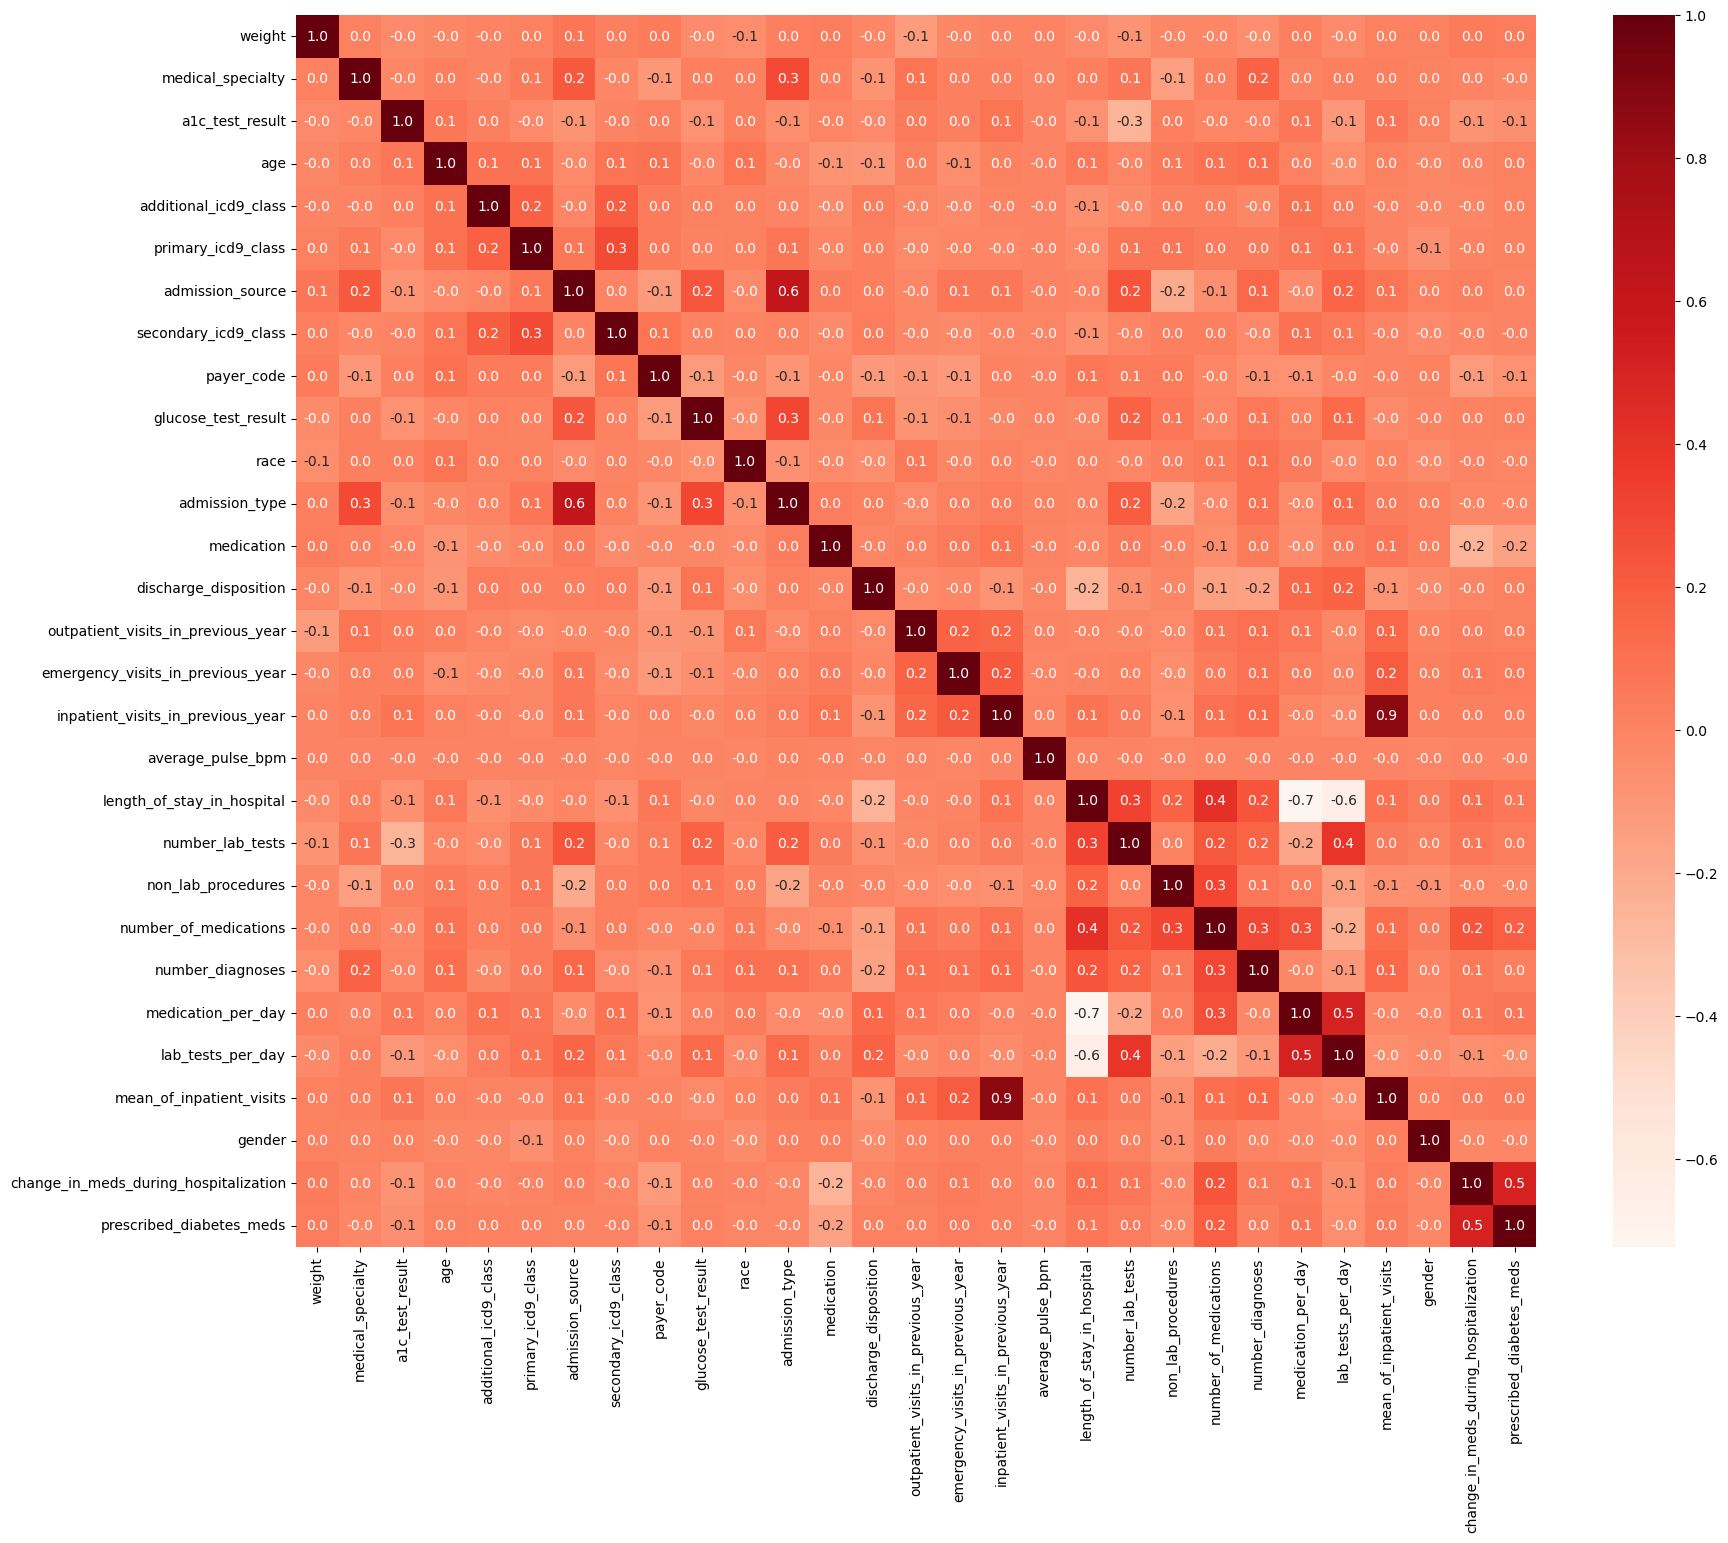

In [83]:
cor_spearman = X_train.corr(method ='spearman')
def cor_heatmap(cor):
    plt.figure(figsize=(20,16))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1f')
    plt.show()
cor_heatmap(cor_spearman)
#finally look at the correlations between input variables
#there are some relevant correlations we need to adress, but first drop the features based on the majority vote and see if we even have to
#adress the problems


In [84]:
#eventhough using random_state there is still some randomness left in the mutual information classification which
#makes it impossible to reproduce the exactly same result...
#usually this would be the code to choose
# X_train.drop(columns=feature_selection[feature_selection['sum']<3].index.to_list(), inplace=True) #drop features based on majority vote
# X_val.drop(columns=feature_selection[feature_selection['sum']<3].index.to_list(), inplace=True)

#since there is some variation sometimes we hardcode the columns to use here after trying many times, usually only 1 feature is different

final_features = ['age', 'payer_code', 'medication', 'discharge_disposition', 'emergency_visits_in_previous_year',
                'inpatient_visits_in_previous_year', 'number_of_medications', 'number_diagnoses',
                'mean_of_inpatient_visits', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds']

X_train = X_train[final_features] #drop features based on majority vote
X_val = X_val[final_features]

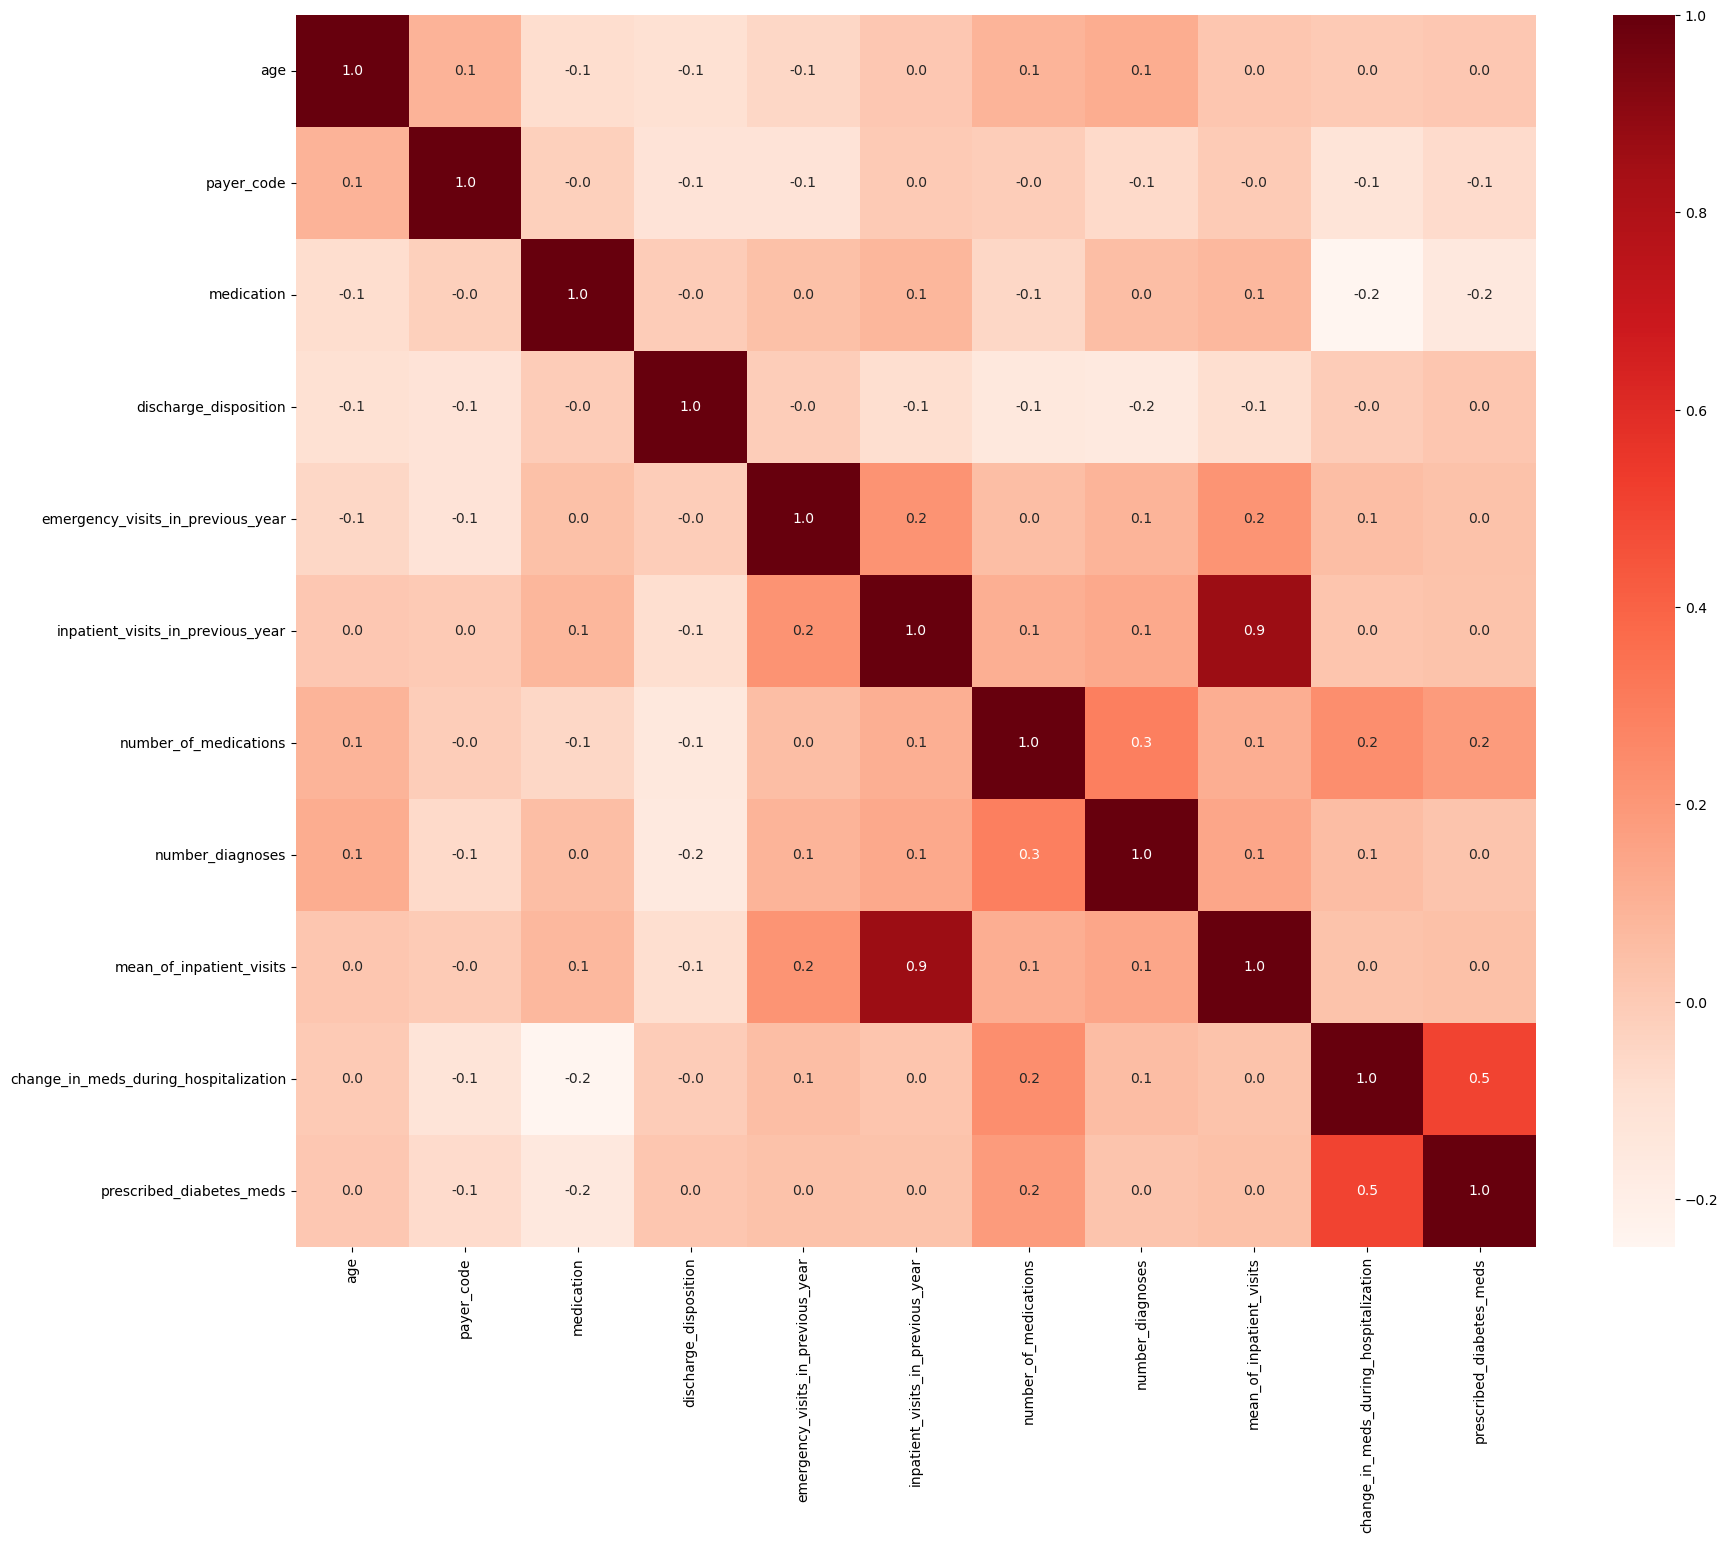

In [85]:
cor_spearman = X_train.corr(method ='spearman')
def cor_heatmap(cor):
    plt.figure(figsize=(20,16))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1f')
    plt.show()
cor_heatmap(cor_spearman)

#correlations after dropping features dropped out by majority vote
#only high correlation between mean visits and inpatient visits, which was expected
#still both models used so far seem to perform better if we use both variables so we keep them since they might still have a synergetic effect



In [86]:
X_train #final dataset

age  payer_code  medication  discharge_disposition  \
encounter_id                                                            
898739        1.236223    0.330546    1.164543              -1.032246   
985943        0.221320    0.330546   -1.240691              -1.069973   
386470        1.236223    0.330546    0.524856              -1.517595   
205429        1.236223    0.330546   -1.071650              -1.069973   
544009        1.236223    0.845313    0.524856              -1.519223   
...                ...         ...         ...                    ...   
819620        0.221320    0.845313    0.524856              -1.396063   
712256        1.236223    0.330546   -1.208318               0.818127   
609175        1.236223   -1.402975    0.524856               0.818127   
748927       -2.171090   -1.494058    1.164543              -1.069973   
788870       -2.337122    0.845313    1.164543              -1.396063   

              emergency_visits_in_previous_year  \
encounter_id                                      
898739                                 1.911105   
985943                                -0.324681   
386470                                -0.324681   
205429                                -0.324681   
544009                                -0.324681   
...                                         ...   
819620                                -0.324681   
712256                                -0.324681   
609175                                -0.324681   
748927                                 4.146891   
788870                                -0.324681   

              inpatient_visits_in_previous_year  number_of_medications  \
encounter_id                                                             
898739                                 0.712477               0.876743   
985943                                -0.640689               1.331642   
386470                                 0.712477              -0.791220   
205429                                 0.712477               1.028376   
544009                                 0.712477               0.573477   
...                                         ...                    ...   
819620                                -0.640689              -0.791220   
712256                                -0.640689              -0.487954   
609175                                -0.640689              -1.094486   
748927                                -0.640689              -1.094486   
788870                                -0.640689              -1.094486   

              number_diagnoses  mean_of_inpatient_visits  \
encounter_id                                               
898739                0.818474                  0.040742   
985943                0.818474                 -0.727216   
386470                0.818474                  0.808699   
205429                0.818474                 -0.215244   
544009                0.818474                  0.808699   
...                        ...                       ...   
819620               -2.289380                 -0.727216   
712256               -0.735453                 -0.727216   
609175               -1.771404                 -0.727216   
748927               -1.253429                 -0.727216   
788870               -2.807356                 -0.727216   

              change_in_meds_during_hospitalization  prescribed_diabetes_meds  
encounter_id                                                                   
898739                                            1                         1  
985943                                            1                         1  
386470                                            0                         0  
205429                                            0                         1  
544009                                            0                         0  
...                                             ...                       ...  
819620               

Models

In [87]:
#logistic regression -> l1/l2, class_weight/RUS
#decision tree class_weight/RUS
#random forest class_weight/RUS
#histgradient boosting sample_weights/RUS
#sgd hinge/svc class_weight/RUS
#naive bayes sample_weights/RUS
#mlp RUS
#knn RUS

In [88]:
#strategy: we use grid search to find the best parameters, therefore we run the notebook multiple times and exchange the
#the parameter grids every time until we get close to an optimum

In [89]:
def gridsearch(estimator, param_grid, cv, fit_params=None, scoring ='f1', X_train = X_train, y_train=y_train):
    
    
    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring, cv=cv)#, verbose=3
    
    if fit_params is not None:
        grid_search.fit(X_train, y_train, **fit_params)
    else:
        grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_params = {key.split('__', 1)[1] if '__' in key else key: value for key, value in best_params.items()} #for the RUS parameters
    best_score = grid_search.best_score_
    print("Best Parameters: ", best_params)
    print("Best F1: ", best_score)
    
    return best_params, best_score
    

In [90]:
def evaluate_estimator(estimator, y_train=y_train, y_val = y_val, X_train=X_train, X_val = X_val):
    train_pred = estimator.predict(X_train)
    test_pred = estimator.predict(X_val)
    cm = confusion_matrix(y_val, test_pred )
    train_error = f1_score(y_train, train_pred )
    test_error = f1_score(y_val, test_pred )
    print('Train Error F1', train_error) 
    print('Test Error F1', test_error)
    print(cm)
    
    return train_error, test_error, cm

In [91]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) #for every crossvalidation , n_repeats = 2

Logistic Regression

In [92]:
# param_grid = {
#     'solver': ['liblinear','saga'],
#     'penalty': ['l1'],
#     'C': [0.01, 0.05, 0.1, 0.5, 1]
# }
# Best Parameters:  {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
# Best F1:  0.33493953132744403
# Train Error F1 0.3353810393491615
# Test Error F1 0.333052134300658

# param_grid = {
#     'solver': ['liblinear','saga'],
#     'penalty': ['l1'],
#     'C': np.arange(0.1,1.1,0.05)
# }
# Best Parameters:  {'C': 0.25000000000000006, 'penalty': 'l1', 'solver': 'saga'}
# Best F1:  0.33499525707696776
# Train Error F1 0.3353531999667967
# Test Error F1 0.333052134300658


In [93]:
lr_l1 = LogisticRegression(class_weight='balanced', random_state=0)

param_grid = {
    'solver': ['liblinear','saga'],
    'penalty': ['l1'],
    'C': np.arange(0.24,0.27,0.01)
}

lr_l1_best_params, lr_l1_best_score = gridsearch(lr_l1, param_grid, stratified_kfold)

Best Parameters:  {'C': 0.25, 'penalty': 'l1', 'solver': 'saga'}
Best F1:  0.33499525707696776


In [94]:
lr_l1 = LogisticRegression(**lr_l1_best_params, class_weight='balanced')
lr_l1.fit(X_train, y_train)
lr_l1_train_error, lr_l1_test_error,lr_l1_cm = evaluate_estimator(lr_l1)

Train Error F1 0.3353810393491615
Test Error F1 0.333052134300658
[[9308 3350]
 [ 603  987]]


In [95]:
# param_grid = {
#     'solver': ['lbfgs','liblinear','saga', 'newton-cg','newton-cholesky', 'saga'],
#     'penalty': ['l2'],
#     'C': [0.01, 0.05, 0.1, 0.5, 1]
# }
# Best Parameters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
# Best F1:  0.3351627899121181
# Train Error F1 0.3359261262010732
# Test Error F1 0.3300151847477644


# param_grid = {
#     'solver': ['lbfgs','liblinear','saga', 'newton-cg','newton-cholesky', 'saga'],
#     'penalty': ['l2'],
#     'C': np.arange(0.06, 0.1, 0.01)
# }
# Best Parameters:  {'C': 0.07999999999999999, 'penalty': 'l2', 'solver': 'saga'}
# Best F1:  0.33524562596892343
# Train Error F1 0.3351607276351857
# Test Error F1 0.3332771124978917

In [96]:
lr_l2 = LogisticRegression(class_weight='balanced', random_state=0)

param_grid = {
    'solver': ['lbfgs','liblinear','saga', 'newton-cg','newton-cholesky', 'saga'],
    'penalty': ['l2'],
    'C': np.arange(0.06, 0.1, 0.01)
}


lr_l2_best_params, lr_l2_best_score = gridsearch(lr_l2, param_grid, stratified_kfold)

Best Parameters:  {'C': 0.07999999999999999, 'penalty': 'l2', 'solver': 'saga'}
Best F1:  0.33524562596892343


In [97]:
lr_l2 = LogisticRegression(**lr_l2_best_params, class_weight='balanced')
lr_l2.fit(X_train, y_train)
lr_l2_train_error, lr_l2_test_error,lr_l2_cm = evaluate_estimator(lr_l2)


Train Error F1 0.3351607276351857
Test Error F1 0.3332771124978917
[[9307 3351]
 [ 602  988]]


In [98]:
# param_grid = {
#     'logisticregression__solver': ['liblinear','saga'],
#     'logisticregression__penalty': ['l1'],
#     'logisticregression__C': [0.01, 0.05, 0.1, 0.5, 1]
# }
# Best Parameters:  {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
# Best F1:  0.3344888672557633
# Train Error F1 0.33526106394323446
# Test Error F1 0.329979879275654

# param_grid = {
#     'logisticregression__solver': ['liblinear','saga'],
#     'logisticregression__penalty': ['l1'],
#     'logisticregression__C': [1,5,10,50,100]
# }

# Best Parameters:  {'C': 50, 'penalty': 'l1', 'solver': 'saga'}
# Best F1:  0.3347370993644758
# Train Error F1 0.33523450002051614
# Test Error F1 0.3300352171725641

# param_grid = {
#     'logisticregression__solver': ['liblinear','saga'],
#     'logisticregression__penalty': ['l1'],
#     'logisticregression__C': [30,40,50]
# }
# Best Parameters:  {'C': 40, 'penalty': 'l1', 'solver': 'saga'}
# Best F1:  0.3347370993644758
# Train Error F1 0.33523450002051614
# Test Error F1 0.3300352171725641

In [99]:
lr_l1_rus = make_pipeline(RandomUnderSampler(random_state=0), LogisticRegression(random_state=0))

param_grid = {
    'logisticregression__solver': ['liblinear','saga'],
    'logisticregression__penalty': ['l1'],
    'logisticregression__C': [30,40,50]
}

lr_l1_rus_best_params, lr_l1_rus_best_score = gridsearch(lr_l1_rus, param_grid, stratified_kfold)


Best Parameters:  {'C': 40, 'penalty': 'l1', 'solver': 'saga'}
Best F1:  0.3347370993644758


In [100]:
lr_l1_rus = make_pipeline(RandomUnderSampler(random_state=0), LogisticRegression(random_state=0, **lr_l1_rus_best_params))
lr_l1_rus.fit(X_train, y_train)
lr_l1_rus_train_error, lr_l1_rus_test_error,lr_l1_rus_cm = evaluate_estimator(lr_l1_rus)

Train Error F1 0.33523450002051614
Test Error F1 0.3300352171725641
[[9269 3389]
 [ 606  984]]


In [101]:
# param_grid = {
#     'logisticregression__solver': ['lbfgs','liblinear','saga', 'newton-cg','newton-cholesky', 'saga'],
#     'logisticregression__penalty': ['l2'],
#     'logisticregression__C': [0.01, 0.1, 1, 10]
# }
# Best Parameters:  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
# Best F1:  0.33475078223062893
# Train Error F1 0.3352207451173478
# Test Error F1 0.3300905736330091

# param_grid = {
#     'logisticregression__solver': ['lbfgs','liblinear','saga', 'newton-cg','newton-cholesky', 'saga'],
#     'logisticregression__penalty': ['l2'],
#     'logisticregression__C': [10,30,50]
# }

# Train Error F1 0.3352207451173478
# Test Error F1 0.3300905736330091

#doesnt matter

In [102]:
lr_l2_rus = make_pipeline(RandomUnderSampler(random_state=0), LogisticRegression(random_state=0))

param_grid = {
    'logisticregression__solver': ['lbfgs','liblinear','saga', 'newton-cg','newton-cholesky', 'saga'],
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': [10,30,50]
}

lr_l2_rus_best_params, lr_l2_rus_best_score = gridsearch(lr_l2_rus, param_grid, stratified_kfold)


Best Parameters:  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1:  0.33475078223062893


In [103]:
lr_l2_rus = make_pipeline(RandomUnderSampler(random_state=0), LogisticRegression(random_state=0, **lr_l2_rus_best_params))
lr_l2_rus.fit(X_train, y_train)
lr_l2_rus_train_error, lr_l2_rus_test_error,lr_l2_rus_cm = evaluate_estimator(lr_l2_rus)

Train Error F1 0.3352207451173478
Test Error F1 0.3300905736330091
[[9270 3388]
 [ 606  984]]


Decision Tree

In [104]:
# param_grid = {
#     'max_depth': [4,8,12,16],
#     'min_samples_split': [10,20,30],
#     'min_samples_leaf': [10,20,30],
#     'splitter' : ['random', 'best'],
#     'criterion' : ['gini', 'entropy']
# }

# param_grid = {
#     'max_depth': [2,3,4,5,6],
#     'min_samples_split': [10,20,30],
#     'min_samples_leaf': [10,20,30],
#     'splitter' : ['random', 'best'],
#     'criterion' : ['gini', 'entropy']
# }

# param_grid = {
#     'max_depth': [2,3,4],
#     'min_samples_split': [8,10,12],
#     'min_samples_leaf': [8,10,12],
#     'splitter' : ['random', 'best'],
#     'criterion' : ['gini', 'entropy']
# }

In [105]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=0)

param_grid = {
    'max_depth': [2,3,4],
    'min_samples_split': [1,2,3],
    'min_samples_leaf': [1,2,3],
    'splitter' : ['random', 'best'],
    'criterion' : ['gini', 'entropy']
}

dt_best_params, dt_best_score = gridsearch(dt, param_grid, stratified_kfold)

#f1 score doesnt change anymore, min sample leaf and min samples split dont matter, since max depth is only 3

Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best F1:  0.3679509931882188


In [106]:
dt = DecisionTreeClassifier(**dt_best_params, class_weight='balanced')
dt.fit(X_train, y_train)
dt_train_error, dt_test_error,dt_cm = evaluate_estimator(dt)

Train Error F1 0.3679434989455099
Test Error F1 0.36485918453131566
[[10358  2300]
 [  722   868]]


In [107]:
dt_rus = make_pipeline(RandomUnderSampler(random_state=0), DecisionTreeClassifier(random_state=0))

param_grid = {
    'decisiontreeclassifier__max_depth': [2,3,4],
    'decisiontreeclassifier__min_samples_split': [1,2,3],
    'decisiontreeclassifier__min_samples_leaf': [1,2,3],
    'decisiontreeclassifier__splitter' : ['random', 'best'],
    'decisiontreeclassifier__criterion' : ['gini', 'entropy']
    
}
dt_rus_best_params, dt_rus_best_score = gridsearch(dt_rus, param_grid, stratified_kfold)

Best Parameters:  {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best F1:  0.36669694803739794


In [108]:
dt_rus = make_pipeline(RandomUnderSampler(random_state=0), DecisionTreeClassifier(random_state=0, **dt_rus_best_params))
dt_rus.fit(X_train, y_train)
dt_rus_train_error, dt_rus_test_error, dt_rus_cm = evaluate_estimator(dt_rus)

Train Error F1 0.3679434989455099
Test Error F1 0.36485918453131566
[[10358  2300]
 [  722   868]]


Random Forest

In [109]:
# param_grid = {
#     'n_estimators': [60,80,100],
#     'max_depth': [6,8,10,12],
#     'criterion': ['gini'], # we dont fine tune min sample split and min sample leaf anymore since, also gini was always the best so far so we dont consider entropy anymore
#     'max_features': [8,10,12] #start from 4 since log2(16) and sqrt(16) both aprrox 4    
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 8, 'n_estimators': 100}
# Best F1:  0.36578504087479924

# param_grid = {
#     'n_estimators': [60,70,80],
#     'max_depth': [12,14,16],
#     'criterion': ['gini'], 
#     'max_features': [7,9,11],
#     'min_impurity_decrease' : [0.0001],
#     'min_samples_split' : [25,50,75],
#     'min_samples_leaf' : [25,50,75]
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 14, 'max_features': 9, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 25, 'min_samples_split': 25, 'n_estimators': 60}
# Best F1:  0.37729570986001737
# Train Error F1 0.40876788186432855
# Test Error F1 0.3711035084318666


# param_grid = {
#     'n_estimators': [55,60,65],
#     'max_depth': [13,14,15],
#     'criterion': ['gini'], 
#     'max_features': [8,9,10],
#     'min_impurity_decrease' : [0.0001],
#     'min_samples_split' : [15,25,35],
#     'min_samples_leaf' : [15,25,35]
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 13, 'max_features': 9, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 15, 'min_samples_split': 15, 'n_estimators': 60}
# Best F1:  0.37927667288961364
# Train Error F1 0.4148716988200038
# Test Error F1 0.37145650048875856

# param_grid = {
#     'n_estimators': [50,60,70],
#     'max_depth': [13,14,15],
#     'criterion': ['gini'], 
#     'max_features': [9,10,11],
#     'min_impurity_decrease' : [0.0001],
#     'min_samples_split' : [5,10, 15],
#     'min_samples_leaf' : [5,10,15]
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 15, 'max_features': 9, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}
# Best F1:  0.38068212125749606
# Train Error F1 0.4321997417133017
# Test Error F1 0.3693421846710923
#better cv score but worse performance for test set

# param_grid = {
#     'n_estimators': [60,70],
#     'max_depth': [12],
#     'criterion': ['gini'], 
#     'max_features': [11],
#     'min_impurity_decrease' : [0.0001],
#     'min_samples_split' : [15],
#     'min_samples_leaf' : [15]
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 12, 'max_features': 11, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 15, 'min_samples_split': 15, 'n_estimators': 70}
# Best F1:  0.37762828154801553
# Train Error F1 0.41513503375843963
# Test Error F1 0.3713113152237639



In [110]:
rf = RandomForestClassifier(class_weight='balanced', random_state=0)

param_grid = {
    'n_estimators': [70],
    'max_depth': [12],
    'criterion': ['gini'], 
    'max_features': [11],
    'min_impurity_decrease' : [0.0001],
    'min_samples_split' : [15],
    'min_samples_leaf' : [15]
}

rf_best_params, rf_best_score = gridsearch(rf, param_grid, stratified_kfold)

Best Parameters:  {'criterion': 'gini', 'max_depth': 12, 'max_features': 11, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 15, 'min_samples_split': 15, 'n_estimators': 70}
Best F1:  0.37762828154801553


In [111]:
rf = RandomForestClassifier(random_state=0, class_weight='balanced',**rf_best_params)
rf.fit(X_train, y_train)
rf_train_error, rf_test_error,rf_cm= evaluate_estimator(rf)

Train Error F1 0.41513503375843963
Test Error F1 0.3713113152237639
[[10081  2577]
 [  640   950]]


In [112]:
# param_grid = {
#     'randomforestclassifier__n_estimators': [40,80,120],
#     'randomforestclassifier__max_depth': [12,14,16],
#     'randomforestclassifier__criterion': ['gini'],
#     'randomforestclassifier__max_features': [4,5,6],
#     'randomforestclassifier__min_impurity_decrease' : [0.0001],
#     'randomforestclassifier__min_samples_split' : [25,50,75],
#     'randomforestclassifier__min_samples_leaf' : [25,50,75],
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 12, 'max_features': 6, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 25, 'min_samples_split': 75, 'n_estimators': 80}
# Best F1:  0.35860530999274376
# Train Error F1 0.36608167951451537
# Test Error F1 0.3604999119873261

# param_grid = {
#     'randomforestclassifier__n_estimators': [60,80,100],
#     'randomforestclassifier__max_depth': [8,10, 12],
#     'randomforestclassifier__criterion': ['gini'],
#     'randomforestclassifier__max_features': [4,5,6],
#     'randomforestclassifier__min_impurity_decrease' : [0.0001],
#     'randomforestclassifier__min_samples_split' : [50, 70],
#     'randomforestclassifier__min_samples_leaf' : [5,20],
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'max_features': 6, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 60}
# Best F1:  0.3598855158287123
# Train Error F1 0.3687552213868004
# Test Error F1 0.36347262247838613


# param_grid = {
#     'randomforestclassifier__n_estimators': [50, 60,70],
#     'randomforestclassifier__max_depth': [8,10, 12],
#     'randomforestclassifier__criterion': ['gini'],
#     'randomforestclassifier__max_features': [7,9,11],
#     'randomforestclassifier__min_impurity_decrease' : [0.0001],
#     'randomforestclassifier__min_samples_split' : [25, 50],
#     'randomforestclassifier__min_samples_leaf' : [25,50],
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 11, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 25, 'min_samples_split': 25, 'n_estimators': 70}
# Best F1:  0.36280832408491726
# Train Error F1 0.3710310686241038
# Test Error F1 0.366465312099579

# param_grid = {
#     'randomforestclassifier__n_estimators': [60,70,80],
#     'randomforestclassifier__max_depth': [7,8,9],
#     'randomforestclassifier__criterion': ['gini'],
#     'randomforestclassifier__max_features': [9,11],
#     'randomforestclassifier__min_impurity_decrease' : [0.0001],
#     'randomforestclassifier__min_samples_split' : [25, 50],
#     'randomforestclassifier__min_samples_leaf' : [25,50],
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 11, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 25, 'min_samples_split': 25, 'n_estimators': 80}
# Best F1:  0.36407231865239853
# Train Error F1 0.3711357960905881
# Test Error F1 0.3681389761596748

# param_grid = {
#     'randomforestclassifier__n_estimators': [70,80,90],
#     'randomforestclassifier__max_depth': [6,7,8],
#     'randomforestclassifier__criterion': ['gini'],
#     'randomforestclassifier__max_features': [9,11],
#     'randomforestclassifier__min_impurity_decrease' : [0.0001],
#     'randomforestclassifier__min_samples_split' : [25, 40],
#     'randomforestclassifier__min_samples_leaf' : [25, 40],
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 11, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 25, 'min_samples_split': 25, 'n_estimators': 70}
# Best F1:  0.36494178097588875
# Train Error F1 0.3674902582109365
# Test Error F1 0.37009345794392523


# param_grid = {
#     'randomforestclassifier__n_estimators': [70,80,90],
#     'randomforestclassifier__max_depth': [6,7,8],
#     'randomforestclassifier__criterion': ['gini'],
#     'randomforestclassifier__max_features': [9,11],
#     'randomforestclassifier__min_impurity_decrease' : [0.0001],
#     'randomforestclassifier__min_samples_split' : [25, 40],
#     'randomforestclassifier__min_samples_leaf' : [25, 40],
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 11, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 25, 'min_samples_split': 25, 'n_estimators': 70}
# Best F1:  0.36494178097588875
# Train Error F1 0.3674902582109365
# Test Error F1 0.37009345794392523




In [113]:
rf_rus = make_pipeline(RandomUnderSampler(random_state=0), RandomForestClassifier(random_state=0))

param_grid = {
    'randomforestclassifier__n_estimators': [70],
    'randomforestclassifier__max_depth': [6],
    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_features': [11],
    'randomforestclassifier__min_impurity_decrease' : [0.0001],
    'randomforestclassifier__min_samples_split' : [25],
    'randomforestclassifier__min_samples_leaf' : [25],
}

rf_rus_best_params, rf_rus_best_score = gridsearch(rf_rus, param_grid, stratified_kfold)

Best Parameters:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 11, 'min_impurity_decrease': 0.0001, 'min_samples_leaf': 25, 'min_samples_split': 25, 'n_estimators': 70}
Best F1:  0.36494178097588875


In [114]:
rf_rus = make_pipeline(RandomUnderSampler(random_state=0), RandomForestClassifier(random_state=0, **rf_rus_best_params))
rf_rus.fit(X_train, y_train)
rf_rus_train_error, rf_rus_test_error, rf_rus_cm = evaluate_estimator(rf_rus)

Train Error F1 0.3674902582109365
Test Error F1 0.37009345794392523
[[9888 2770]
 [ 600  990]]


HistgradientBoosting

In [115]:
# param_grid = {
#     'learning_rate': [0.01,0.015, 0.02],
#     'max_iter': [170, 180, 190],
#     'max_depth': [2,3,4]
# }
# Best Parameters:  {'learning_rate': 0.015, 'max_depth': 3, 'max_iter': 180}
# Best F1:  0.37305521497420463
# Train Error F1 0.3740657698056801
# Test Error F1 0.3732959101844427

# param_grid = {
#     'learning_rate': np.arange(0.012,0.02,0.002),
#     'max_iter': np.arange(174,186,2),
#     'max_depth': [3]
# }
# Best Parameters:  {'learning_rate': 0.012, 'max_depth': 3, 'max_iter': 182}
# Best F1:  0.37346375622402606
# Train Error F1 0.3741881220503715
# Test Error F1 0.3733707639863646

# param_grid = {
#     'learning_rate': np.arange(0.01,0.014,0.001),
#     'max_iter': np.arange(180,184,1),
#     'max_depth': [3]
# }
# Best Parameters:  {'learning_rate': 0.011999999999999999, 'max_depth': 3, 'max_iter': 182}
# Best F1:  0.37346375622402606
# Train Error F1 0.3741881220503715
# Test Error F1 0.3733707639863646

In [116]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
fit_params = {'sample_weight': sample_weights}
hgb = HistGradientBoostingClassifier(random_state=0)

param_grid = {
    'learning_rate': np.arange(0.01,0.014,0.001),
    'max_iter': np.arange(180,184,1),
    'max_depth': [3]
}

hgb_best_params, hgb_best_score = gridsearch(hgb, param_grid, stratified_kfold, fit_params=fit_params)

Best Parameters:  {'learning_rate': 0.011999999999999999, 'max_depth': 3, 'max_iter': 182}
Best F1:  0.37346375622402606


In [117]:
hgb = HistGradientBoostingClassifier(random_state=0,**hgb_best_params)
hgb.fit(X_train, y_train, sample_weights)
hgb_train_error, hgb_test_error, hgb_cm = evaluate_estimator(hgb)

Train Error F1 0.3741881220503715
Test Error F1 0.3733707639863646
[[10192  2466]
 [  659   931]]


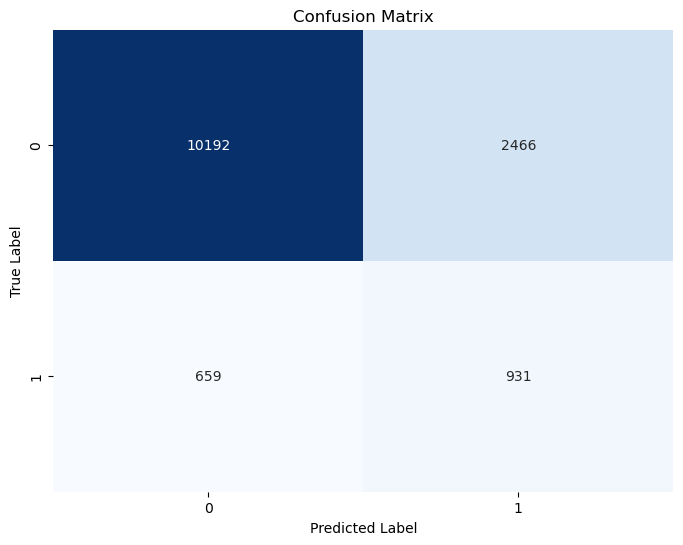

In [189]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming evaluate_estimator returns true labels and predicted labels
# y_train, y_test, hgb_cm = evaluate_estimator(hgb)

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(hgb_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [118]:
# param_grid = {
#     'histgradientboostingclassifier__learning_rate': np.arange(0.005, 0.016, 0.001),
#     'histgradientboostingclassifier__max_iter': np.arange(180,230,10), #50, 100,
#     'histgradientboostingclassifier__max_depth': [2,3,4] #,12,
# }
# Best Parameters:  {'learning_rate': 0.008, 'max_depth': 3, 'max_iter': 210}
# Best F1:  0.36828679436847606
# Train Error F1 0.37640893399326203
# Test Error F1 0.3608835055219095

# param_grid = {
#     'histgradientboostingclassifier__learning_rate': np.arange(0.0075, 0.009, 0.0005),
#     'histgradientboostingclassifier__max_iter': np.arange(190,200,2), #50, 100,
#     'histgradientboostingclassifier__max_depth': [3]
# }
# Best Parameters:  {'learning_rate': 0.0085, 'max_depth': 3, 'max_iter': 194}
# Best F1:  0.3681868723993489
# Train Error F1 0.37640893399326203
# Test Error F1 0.3608835055219095

In [119]:
hgb_rus = make_pipeline(RandomUnderSampler(random_state=0), HistGradientBoostingClassifier(random_state=0))

param_grid = {
    'histgradientboostingclassifier__learning_rate': np.arange(0.0075, 0.009, 0.0005),
    'histgradientboostingclassifier__max_iter': np.arange(190,200,2), #50, 100,
    'histgradientboostingclassifier__max_depth': [3]
}

hgb_rus_best_params, hgb_rus_best_score = gridsearch(hgb_rus, param_grid, stratified_kfold)

Best Parameters:  {'learning_rate': 0.0085, 'max_depth': 3, 'max_iter': 194}
Best F1:  0.3681868723993489


In [120]:
hgb_rus = make_pipeline(RandomUnderSampler(random_state=0), HistGradientBoostingClassifier(random_state=0))
hgb_rus.fit(X_train, y_train)
hgb_rus_train_error, hgb_rus_test_error, hgb_rus_cm = evaluate_estimator(hgb_rus)

Train Error F1 0.37640893399326203
Test Error F1 0.3608835055219095
[[9647 3011]
 [ 577 1013]]


SVM

In [121]:
# c = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
# alpha = 1/(c*len(X_train))
# Best Parameters:  {'alpha': 0.017547553870990384}
# Best F1:  0.3338604663356548
# Train Error F1 0.33489405602729944
# Test Error F1 0.3225270157938487

# c = np.arange(0.0005, 0.002, 0.0005)
# alpha = 1/(c*len(X_train))
# Best Parameters:  {'alpha': 0.017547553870990384}
# Best F1:  0.3338604663356548
# Train Error F1 0.33489405602729944
# Test Error F1 0.3225270157938487

In [122]:
sgd = SGDClassifier(loss='hinge', class_weight='balanced', random_state=0)

c = np.arange(0.0005, 0.002, 0.0005)
alpha = 1/(c*len(X_train))

param_grid = {
    'alpha': alpha
}

sgd_best_params, sgd_best_score = gridsearch(sgd, param_grid, stratified_kfold)

Best Parameters:  {'alpha': 0.017547553870990384}
Best F1:  0.3338604663356548


In [123]:
sgd = SGDClassifier(loss='hinge', class_weight='balanced', random_state=0, **sgd_best_params)
sgd.fit(X_train, y_train)
sgd_train_error, sgd_test_error, sgd_cm = evaluate_estimator(sgd)

Train Error F1 0.33489405602729944
Test Error F1 0.3225270157938487
[[9203 3455]
 [ 620  970]]


In [124]:
# c = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
# alpha = 1/(c*len(X_train))
# Best Parameters:  {'alpha': 0.017547553870990384}
# Best F1:  0.33385408056104493
# Train Error F1 0.3312647635824959
# Test Error F1 0.32244081360453486

# c = np.arange(0.0005, 0.002, 0.0005)
# alpha = 1/(c*len(X_train))
# Best Parameters:  {'alpha': 0.017547553870990384}
# Best F1:  0.33385408056104493
# Train Error F1 0.3312647635824959
# Test Error F1 0.32244081360453486

In [125]:
sgd_rus = make_pipeline(RandomUnderSampler(random_state=0), SGDClassifier(loss='hinge', random_state=0))

c = np.arange(0.0005, 0.002, 0.0005)
alpha = 1/(c*len(X_train))

param_grid = {
    'sgdclassifier__alpha': alpha
}

sgd_rus_best_params, sgd_rus_best_score = gridsearch(sgd_rus, param_grid, stratified_kfold)

Best Parameters:  {'alpha': 0.017547553870990384}
Best F1:  0.33385408056104493


In [126]:
sgd_rus = make_pipeline(RandomUnderSampler(random_state=0), SGDClassifier(loss='hinge', random_state=0, **sgd_rus_best_params))
sgd_rus.fit(X_train, y_train)
sgd_rus_train_error, sgd_rus_test_error, sgd_rus_cm = evaluate_estimator(sgd_rus)

Train Error F1 0.3312647635824959
Test Error F1 0.32244081360453486
[[9217 3441]
 [ 623  967]]


In [127]:
# param_grid = {
#     'gamma': ['auto'],
#     'C' : [0.01, 0.1, 1, 10]
# }
# Best Parameters:  {'C': 1, 'gamma': 'auto'}
# Best F1:  0.33004790428015174
# Train Error F1 0.33821392645579523
# Test Error F1 0.33115060804490176

# param_grid = {
#     'gamma': ['auto'],
#     'C' : [0.5, 1, 2, 3]
# }
# Best Parameters:  {'C': 0.5, 'gamma': 'auto'}
# Best F1:  0.33065291246183703
# Train Error F1 0.3352153215985829
# Test Error F1 0.3320487128102358

# param_grid = {
#     'gamma': ['auto'],
#     'C' : [0.3,0.6,0.9]
# }
# Best Parameters:  {'C': 0.6, 'gamma': 'auto'}
# Best F1:  0.3301913163245175
# Train Error F1 0.3361325885094891
# Test Error F1 0.3316318638824439

In [128]:
svc= SVC(class_weight='balanced', random_state=0, kernel='rbf')
param_grid = {
    'gamma': ['auto'],
    'C' : [0.6]
}

svc_best_params, svc_best_score = gridsearch(svc, param_grid, stratified_kfold)

Best Parameters:  {'C': 0.6, 'gamma': 'auto'}
Best F1:  0.3301913163245175


In [129]:
svc = SVC(class_weight='balanced', random_state=0, **svc_best_params, kernel='rbf')
svc.fit(X_train, y_train)
svc_train_error, svc_test_error, svc_cm = evaluate_estimator(svc)

Train Error F1 0.3361325885094891
Test Error F1 0.3316318638824439
[[8855 3803]
 [ 518 1072]]


In [130]:
# param_grid = {
#     'svc__gamma': ['auto'],
#     'svc__C' : [0.1,1,10]
# }
# Best Parameters:  {'C': 1, 'gamma': 'auto'}
# Best F1:  0.33068304677222116
# Train Error F1 0.3324180853011166
# Test Error F1 0.33124138986682994

# param_grid = {
#     'svc__gamma': ['auto'],
#     'svc__C' : [0.5,1,2]
# }
# Best Parameters:  {'C': 2, 'gamma': 'auto'}
# Best F1:  0.3307356738441999
# Train Error F1 0.33525158624760215
# Test Error F1 0.3318385650224215

# param_grid = {
#     'svc__gamma': ['auto'],
#     'svc__C' : np.arange(1.5,3,0.5)
# }
# Best Parameters:  {'C': 2.0, 'gamma': 'auto'}
# Best F1:  0.3307356738441999
# Train Error F1 0.33525158624760215
# Test Error F1 0.3318385650224215

In [131]:
svc_rus = make_pipeline(RandomUnderSampler(random_state=0), SVC(random_state=0))

param_grid = {
    'svc__gamma': ['auto'],
    'svc__C' : [2]
}

svc_rus_best_params, svc_rus_best_score = gridsearch(svc_rus, param_grid, stratified_kfold)

Best Parameters:  {'C': 2, 'gamma': 'auto'}
Best F1:  0.3307356738441999


In [132]:
svc_rus = make_pipeline(RandomUnderSampler(random_state=0), SVC(random_state=0, **svc_rus_best_params))
svc_rus.fit(X_train, y_train)
svc_rus_train_error, svc_rus_test_error, svc_rus_cm = evaluate_estimator(svc_rus)

Train Error F1 0.33525158624760215
Test Error F1 0.3318385650224215
[[8854 3804]
 [ 517 1073]]


Naive Bayes

In [133]:
param_grid = {}
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
fit_params = {'sample_weight': sample_weights}
#CategoricalNB,MultinomialNB doesnt work since we used stadard scaler and it cant take negative values

In [134]:
bnb = BernoulliNB()
bnb_best_params, bnb_best_score = gridsearch(bnb, param_grid, stratified_kfold, fit_params=fit_params)
bnb.fit(X_train, y_train, sample_weights)
bnb_train_error, bnb_test_error, bnb_cm = evaluate_estimator(bnb)

Best Parameters:  {}
Best F1:  0.2965262216111929
Train Error F1 0.29641217480020404
Test Error F1 0.3152254799821402
[[8588 4070]
 [ 531 1059]]


In [135]:
gnb = GaussianNB()
gnb_best_params, gnb_best_score = gridsearch(gnb, param_grid, stratified_kfold, fit_params=fit_params)
gnb.fit(X_train, y_train, sample_weights)
gnb_train_error, gnb_test_error, gnb_cm = evaluate_estimator(gnb)

Best Parameters:  {}
Best F1:  0.27881056513898905
Train Error F1 0.27898361434338637
Test Error F1 0.29880404783808645
[[9625 3033]
 [ 778  812]]


In [136]:
bnb_rus = make_pipeline(RandomUnderSampler(random_state=0), BernoulliNB())
bnb_rus_best_params, bnb_rus_best_score = gridsearch(bnb_rus, param_grid, stratified_kfold)
bnb_rus.fit(X_train, y_train)
bnb_rus_train_error, bnb_rus_test_error, bnb_rus_cm = evaluate_estimator(bnb_rus)

Best Parameters:  {}
Best F1:  0.2957836562570018
Train Error F1 0.2971265539025882
Test Error F1 0.31727624145108535
[[8589 4069]
 [ 523 1067]]


In [137]:
gnb_rus = make_pipeline(RandomUnderSampler(random_state=0), GaussianNB())
gnb_rus_best_params, gnb_rus_best_score = gridsearch(gnb_rus, param_grid, stratified_kfold)
gnb_rus.fit(X_train, y_train)
gnb_rus_train_error, gnb_rus_test_error, gnb_rus_cm = evaluate_estimator(gnb_rus)

Best Parameters:  {}
Best F1:  0.27699935089935773
Train Error F1 0.28007572172266915
Test Error F1 0.3023639362286971
[[9616 3042]
 [ 765  825]]


MLP

In [138]:
# param_grid = {
#     'mlpclassifier__hidden_layer_sizes': [(ncol,),(ncol, int((ncol/2)))],
#     'mlpclassifier__activation': ['relu', 'logistic', 'tanh'],
#     'mlpclassifier__alpha': [0.01, 0.05, 0.1],
#     'mlpclassifier__solver': ['adam'],
#     'mlpclassifier__max_iter' : [400]
# }
# Best Parameters:  {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (11, 5), 'max_iter': 400, 'solver': 'adam'}
# Best F1:  0.34196529362378014
# Train Error F1 0.3425609707099522
# Test Error F1 0.3384511557280243

# param_grid = {
#     'mlpclassifier__hidden_layer_sizes': [(ncol,),(ncol, int((ncol/2)))],
#     'mlpclassifier__activation': ['relu', 'logistic', 'tanh'],
#     'mlpclassifier__alpha': [0.001, 0.005, 0.01, 0.02],
#     'mlpclassifier__solver': ['adam'],
#     'mlpclassifier__max_iter' : [400]
# }
# Best Parameters:  {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (11, 5), 'max_iter': 400, 'solver': 'adam'}
# Best F1:  0.34196529362378014
# Train Error F1 0.3425609707099522
# Test Error F1 0.3384511557280243

# param_grid = {
#     'mlpclassifier__hidden_layer_sizes': [(ncol,),(ncol, int((ncol/2)))],
#     'mlpclassifier__activation': ['relu', 'logistic', 'tanh'],
#     'mlpclassifier__alpha': [0.008, 0.009, 0.01, 0.012, 0.013],
#     'mlpclassifier__solver': ['adam'],
#     'mlpclassifier__max_iter' : [400]
# }
# Best Parameters:  {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (11, 5), 'max_iter': 400, 'solver': 'adam'}
# Best F1:  0.34196529362378014
# Train Error F1 0.3425609707099522
# Test Error F1 0.3384511557280243

# param_grid = {
#     'mlpclassifier__hidden_layer_sizes': [(ncol,),(ncol, int((ncol/2)))],
#     'mlpclassifier__activation': ['relu', 'logistic', 'tanh'],
#     'mlpclassifier__alpha': np.arange(0.009, 0.0115, 0.0005),
#     'mlpclassifier__solver': ['adam'],
#     'mlpclassifier__max_iter' : [400]
# }
# Best Parameters:  {'activation': 'tanh', 'alpha': 0.0105, 'hidden_layer_sizes': (11, 5), 'max_iter': 400, 'solver': 'adam'}
# Best F1:  0.34199290014981615
# Train Error F1 0.34253344582379175
# Test Error F1 0.3383940620782726


In [139]:
ncol = len(X_train.columns)
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(ncol, int((ncol/2)))],
    'mlpclassifier__activation': ['tanh'],
    'mlpclassifier__alpha': [0.0105],
    'mlpclassifier__solver': ['adam'],
    'mlpclassifier__max_iter' : [400]
}
# 
mlp_rus = make_pipeline(RandomUnderSampler(random_state=0), MLPClassifier(random_state=0))
mlp_rus_best_params, mlp_rus_best_score = gridsearch(mlp_rus, param_grid, stratified_kfold)

Best Parameters:  {'activation': 'tanh', 'alpha': 0.0105, 'hidden_layer_sizes': (11, 5), 'max_iter': 400, 'solver': 'adam'}
Best F1:  0.34199290014981615


In [140]:
mlp_rus = make_pipeline(RandomUnderSampler(random_state=0), MLPClassifier(random_state=0, **mlp_rus_best_params))
mlp_rus.fit(X_train, y_train)
mlp_rus_train_error, mlp_rus_test_error, mlp_rus_cm = evaluate_estimator(mlp_rus)

Train Error F1 0.34253344582379175
Test Error F1 0.3383940620782726
[[9323 3335]
 [ 587 1003]]


KNN

In [141]:
# param_grid = {
#     'kneighborsclassifier__n_neighbors': [5,10,15],
#     'kneighborsclassifier__weights': ['uniform', 'distance'],
#     'kneighborsclassifier__p': [1, 2]                      
# }

# param_grid = {
#     'kneighborsclassifier__n_neighbors': np.arange(12,19,1),
#     'kneighborsclassifier__weights': ['uniform', 'distance'],
#     'kneighborsclassifier__p': [1, 2]                      
# }

# param_grid = {
#     'kneighborsclassifier__n_neighbors': np.arange(19,22,1),
#     'kneighborsclassifier__weights': ['uniform', 'distance'],
#     'kneighborsclassifier__p': [1, 2]                      
# }
# Best Parameters:  {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
# Best F1:  0.30287589254760866
# Train Error F1 0.33463677130044844
# Test Error F1 0.2890289315382412
from sklearn.neighbors import KNeighborsClassifier

In [142]:
knn_rus = make_pipeline(RandomUnderSampler(random_state=0), KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(19,22,1),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]                      
}

knn_rus_best_params, knn_rus_best_score = gridsearch(knn_rus, param_grid, stratified_kfold)

Best Parameters:  {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
Best F1:  0.30287589254760866


In [143]:
knn_rus = make_pipeline(RandomUnderSampler(random_state=0), KNeighborsClassifier())
knn_rus.fit(X_train, y_train)
knn_rus_train_error, knn_rus_test_error, knn_rus_cm = evaluate_estimator(knn_rus)

Train Error F1 0.33463677130044844
Test Error F1 0.2890289315382412
[[8275 4383]
 [ 581 1009]]


Evaluation

In [144]:
#f1 score makes most sense for sure since data imbalance and FP and FN are equally important

In [145]:
def get_metrics(cm):
    true_positives = cm[1, 1]
    false_positives = cm[0, 1]
    false_negatives = cm[1, 0]
    true_negatives = cm[0, 0]

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)
    
    return precision,recall, specificity   
    

Kaggle Solution

In [146]:
#since we know mena_inpatient_visits is our msot important feature and is based on the mean by patient_id we want to use the whole data set
#to extract as much information within this feature as possible since threw the train test split we
#don't see every duplicate possible
#everything else stays the same

In [147]:
df = pd.read_csv(r'project_data\train.csv', sep=',')
df = df.drop(columns='readmitted_multiclass') #drop multiclass, this notebook is for binary
df = df.set_index(df['encounter_id']).drop(columns='encounter_id') #set encounter id as index
y_train = df['readmitted_binary'] #split in X and y
X_train = df.drop(columns = 'readmitted_binary')

In [148]:
df = pd.read_csv(r'project_data\test.csv', sep=',')
X_test = df.set_index(df['encounter_id']).drop(columns='encounter_id') #set encounter id as index

In [149]:
X_train_id = X_train.index #save indicies for later on
X_test_id = X_test.index


In [150]:
#Transformation
X_train['outpatient_visits_in_previous_year'] = np.log1p(X_train['outpatient_visits_in_previous_year'])
X_train['inpatient_visits_in_previous_year'] = np.log1p(X_train['inpatient_visits_in_previous_year'])
X_train['emergency_visits_in_previous_year'] = np.log1p(X_train['emergency_visits_in_previous_year'])
 
 #Outliers
X_train.loc[X_train['emergency_visits_in_previous_year'] >= 3.2, 'emergency_visits_in_previous_year' ] = 0
X_train.loc[X_train['outpatient_visits_in_previous_year'] >= 3.2, 'outpatient_visits_in_previous_year' ] = 0
X_train.loc[X_train['length_of_stay_in_hospital']>12, 'length_of_stay_in_hospital'] = 4
X_train.loc[X_train['number_lab_tests']>96, 'number_lab_tests'] = 44
X_train.loc[X_train['number_of_medications']>34, 'number_of_medications'] = 15
X_train.loc[X_train['number_diagnoses']>13, 'number_diagnoses'] = 13
X_train.loc[X_train['non_lab_procedures']>5, 'non_lab_procedures'] = 5

#feature engineering
X_train['medication_per_day'] = X_train['number_of_medications'] / X_train['length_of_stay_in_hospital']
X_train['lab_tests_per_day'] = X_train['number_lab_tests'] / X_train['length_of_stay_in_hospital']
X_train['mean_of_inpatient_visits'] = X_train.groupby('patient_id')['inpatient_visits_in_previous_year'].transform('mean')

In [151]:
#Transformation
X_test['outpatient_visits_in_previous_year'] = np.log1p(X_test['outpatient_visits_in_previous_year'])
X_test['inpatient_visits_in_previous_year'] = np.log1p(X_test['inpatient_visits_in_previous_year'])
X_test['emergency_visits_in_previous_year'] = np.log1p(X_test['emergency_visits_in_previous_year'])

 #Outliers
X_test.loc[X_test['emergency_visits_in_previous_year'] >= 3.2, 'emergency_visits_in_previous_year' ] = 0
X_test.loc[X_test['outpatient_visits_in_previous_year'] >= 3.2, 'outpatient_visits_in_previous_year' ] = 0
X_test.loc[X_test['length_of_stay_in_hospital']>12, 'length_of_stay_in_hospital'] = 4
X_test.loc[X_test['number_lab_tests']>96, 'number_lab_tests'] = 44
X_test.loc[X_test['number_of_medications']>34, 'number_of_medications'] = 15
X_test.loc[X_test['number_diagnoses']>13, 'number_diagnoses'] = 13
X_test.loc[X_test['non_lab_procedures']>5, 'non_lab_procedures'] = 5

#Feature Engineering
X_test['medication_per_day'] = X_test['number_of_medications'] / X_test['length_of_stay_in_hospital']
X_test['lab_tests_per_day'] = X_test['number_lab_tests'] / X_test['length_of_stay_in_hospital']

#avoid data leakage
X_test = pd.merge(X_test, X_train.groupby('patient_id')['mean_of_inpatient_visits'].max().reset_index(), on='patient_id', how='left').set_index(X_test_id)
X_test['mean_of_inpatient_visits'].fillna(X_test['inpatient_visits_in_previous_year'], inplace=True)

X_train.drop(columns='patient_id', inplace=True)
X_test.drop(columns='patient_id', inplace=True)

numerical_features = X_train.select_dtypes(include=np.number).columns

In [152]:
#preprocessing, NAs low cardinalities
categorical_features = X_train.select_dtypes(exclude=np.number).columns
X_train[categorical_features] = X_train[categorical_features].fillna('NA')

X_train.drop(columns='country', inplace=True)

X_train.loc[X_train['race']=='NA', 'race'] = '?'
X_train.loc[X_train['gender']=='Unknown/Invalid', 'gender'] = 'Female'
X_train.loc[X_train['age']=='NA', 'age'] = '[70-80)'

other = ['[125-150)', '[25-50)', '[0-25)', '[150-175)', '[175-200)', '>200 ']
X_train['weight'] = X_train['weight'].replace(other, 'other')

other = ['CH', 'WC', 'OT', 'MP', 'SI', 'FR']
X_train['payer_code'] = X_train['payer_code'].replace(other, 'other')

X_train.loc[X_train['admission_type']=='NA', 'admission_type'] = 'Not Mapped'
other = ['Not Mapped', 'Trauma Center', 'Newborn']
X_train['admission_type'] = X_train['admission_type'].replace(other, 'other')

X_train.loc[X_train['discharge_disposition']=='NA', 'discharge_disposition'] = 'Not Mapped'
category_counts = X_train['discharge_disposition'].value_counts()
other_discharge= category_counts[category_counts < X_train.shape[0] * 0.005].index
X_train['discharge_disposition'] = X_train['discharge_disposition'].replace(other_discharge, 'other')

X_train.loc[X_train['medical_specialty']=='NA', 'medical_specialty'] = 'Not Mapped'
category_counts = X_train['medical_specialty'].value_counts()
other_medical_specialty = category_counts[category_counts < X_train.shape[0] * 0.005].index
X_train['medical_specialty'] = X_train['medical_specialty'].replace(other_medical_specialty , 'other')

X_train.loc[X_train['admission_source']=='NA', 'admission_source'] = 'Not Mapped'
X_train.loc[X_train['admission_source']=='Not Available', 'admission_source'] = 'Not Mapped'

other= ['HMO Referral', 'Court/Law Enforcement', 'Transfer from hospital inpt/same fac reslt in a sep claim', 'Transfer from critial access hospital', 'Transfer from Ambulatory Surgery Center', 'Extramural Birth', 'Normal Delivery', 'Sick Baby']
X_train['admission_source'] = X_train['admission_source'].replace(other, 'other')

category_counts = X_train['medication'].value_counts()
other_med = category_counts[category_counts < X_train.shape[0] * 0.005].index
X_train['medication'] = X_train['medication'].replace(other_med, 'other')

In [153]:
icd9_mapping = {
    'Infectious and Parasitic Diseases': (1, 139),
    'Neoplasms': (140, 239),
    'Endocrine, Nutritional, Metabolic Diseases, and Immunity Disorders': (240, 279),
    'Diseases of the Blood and Blood-Forming Organs': (280, 289),
    'Mental Disorders': (290, 319),
    'Diseases of the Nervous System and Sense Organs': (320, 389),
    'Diseases of the Circulatory System': (390, 459),
    'Diseases of the Respiratory System': (460, 519),
    'Diseases of the Digestive System': (520, 579),
    'Diseases of the Genitourinary System': (580, 629),
    'Complications of Pregnancy, Childbirth, and the Puerperium': (630, 679),
    'Diseases of the Skin and Subcutaneous Tissue': (680, 709),
    'Diseases of the Musculoskeletal System and Connective Tissue': (710, 739),
    'Congenital Anomalies': (740, 759),
    'Certain Conditions Originating in the Perinatal Period': (760, 779),
    'Symptoms, Signs, and Ill-Defined Conditions': (780, 799),
    'Injury and Poisoning': (800, 999),
    'External Causes of Injury': ('E',),
    'Supplemental Classification': ('V',)
}

def map_icd9_code(icd9_code, icd9_mapping):
    # Check for 'E' and 'V' codes
    if icd9_code.startswith('E'):
        return 'External Causes of Injury'
    
    if icd9_code.startswith('V'):
        return 'Supplemental Classification'
    
    if '250' in icd9_code: #since we know diabetes is important for hospital readmission we encode them seperately
        return 'Diabetes'
    
    for category, code_range in icd9_mapping.items():
        if icd9_code.isdigit():
            start, end = code_range
            if start <= int(icd9_code) <= end:
                return category
    
    if icd9_code == '?':
        return icd9_code
    
    return 'other'

In [154]:
#icd mapping
X_train['primary_icd9_class'] = X_train['primary_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))
X_train['secondary_icd9_class'] = X_train['secondary_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))
X_train['additional_icd9_class'] = X_train['additional_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))

X_train.drop(columns = ['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis'], inplace=True)

In [155]:
#binary encoding
categorical_features = X_train.select_dtypes(exclude=np.number).columns
binary_encoding_columns = ['gender', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds']
frequency_encoding_columns = list(set(categorical_features)-set(binary_encoding_columns))
X_train['gender'] = X_train['gender'].replace({'Female':1, 'Male':0})
X_train['change_in_meds_during_hospitalization'] = X_train['change_in_meds_during_hospitalization'].replace({'Ch':1, 'No':0})
X_train['prescribed_diabetes_meds'] = X_train['prescribed_diabetes_meds'].replace({'Yes':1, 'No':0})

In [156]:
#preprocessing for validation set
categorical_features = X_test.select_dtypes(exclude=np.number).columns
X_test[categorical_features] = X_test[categorical_features].fillna('NA')

X_test.drop(columns='country', inplace=True)
X_test.loc[X_test['race']=='NA', 'race'] = '?'
X_test.loc[X_test['gender']=='Unknown/Invalid', 'gender'] = 'Female'
X_test.loc[X_test['age']=='NA', 'age'] = '[70-80)'

other = ['[125-150)', '[25-50)', '[0-25)', '[150-175)', '[175-200)', '>200 ']
X_test['weight'] = X_test['weight'].replace(other, 'other')

other = ['CH', 'WC', 'OT', 'MP', 'SI', 'FR']
X_test['payer_code'] = X_test['payer_code'].replace(other, 'other')

X_test.loc[X_test['admission_type']=='NA', 'admission_type'] = 'Not Mapped'
other = ['Not Mapped', 'Trauma Center', 'Newborn']
X_test['admission_type'] = X_test['admission_type'].replace(other, 'other')

X_test.loc[X_test['discharge_disposition']=='NA', 'discharge_disposition'] = 'Not Mapped'
X_test['discharge_disposition'] = X_test['discharge_disposition'].replace(other_discharge, 'other')

X_test['medical_specialty'] = X_test['medical_specialty'].replace(other_medical_specialty, 'other')

X_test.loc[X_test['admission_source']=='NA', 'admission_source'] = 'Not Mapped'
X_test.loc[X_test['admission_source']=='Not Available', 'admission_source'] = 'Not Mapped'
other= ['HMO Referral', 'Court/Law Enforcement', 'Transfer from hospital inpt/same fac reslt in a sep claim', 'Transfer from critial access hospital', 'Transfer from Ambulatory Surgery Center', 'Extramural Birth', 'Normal Delivery', 'Sick Baby']
X_test['admission_source'] = X_test['admission_source'].replace(other, 'other')

X_test['medication'] = X_test['medication'].replace(other_med, 'other')

In [157]:
X_test['primary_icd9_class'] = X_test['primary_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))
X_test['secondary_icd9_class'] = X_test['secondary_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))
X_test['additional_icd9_class'] = X_test['additional_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))

X_test.drop(columns = ['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis'], inplace=True)

In [158]:
X_test['gender'] = X_test['gender'].replace({'Female':1, 'Male':0})
X_test['change_in_meds_during_hospitalization'] = X_test['change_in_meds_during_hospitalization'].replace({'Ch':1, 'No':0})
X_test['prescribed_diabetes_meds'] = X_test['prescribed_diabetes_meds'].replace({'Yes':1, 'No':0})

In [159]:
def frequency_encode_columns(df1, df2, columns):
    frequency_mappings = {}
    
    for column in columns:
        frequency_mapping = df1[column].value_counts(normalize=True)
        frequency_mappings[column] = frequency_mapping
    
    for column, mapping in frequency_mappings.items():
        df1[column] = df1[column].map(mapping)
        df2[column] = df2[column].map(mapping).fillna(0) 
    
    return df1, df2


X_train, X_test = frequency_encode_columns(X_train, X_test, columns=frequency_encoding_columns)

In [160]:
features_to_scale = list(list(frequency_encoding_columns) + list(numerical_features))

In [161]:
scaler = StandardScaler()

#we use as standardscaler since most of our distribution are skewed and standard scalers are less affected by outliers in the absence of normal distribution
scaler.fit(X_train[features_to_scale])

X_train_num_scaled = scaler.transform(X_train[features_to_scale])
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train[features_to_scale].columns).set_index(X_train.index)

X_test_num_scaled = scaler.transform(X_test[features_to_scale])
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns = X_test[features_to_scale].columns).set_index(X_test.index)

X_train = pd.concat([X_train_num_scaled, X_train[binary_encoding_columns]], axis=1)
X_test =  pd.concat([X_test_num_scaled, X_test[binary_encoding_columns]], axis=1)

In [162]:
X_train=X_train[final_features]
X_test = X_test[final_features]

In [163]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [164]:
y_train = y_train.replace({'Yes': 1, 'No': 0})

In [165]:
hgb_sol = HistGradientBoostingClassifier(random_state=0,**hgb_best_params,class_weight='balanced')
hgb_sol.fit(X_train, y_train)

HistGradientBoostingClassifier(class_weight='balanced',
                               learning_rate=0.011999999999999999, max_depth=3,
                               max_iter=182, random_state=0)

In [166]:
train_pred = hgb_sol.predict(X_train)
print(f1_score(y_train,train_pred)) #even better than before because we get more duplicates using the whole df
pd.DataFrame(train_pred, index=X_train.index, columns=['binary_prediction']).to_csv("binary_train_pred.csv") #for multiclass

0.38759299859828206


In [167]:
pred = hgb_sol.predict(X_test)
pred = pd.Series(pred, name='readmitted_binary')
pred = pred.apply(lambda x: 'No' if x == 0 else 'Yes')
pred_df = pd.concat([pd.Series(X_test_id), pd.Series(pred, name='readmitted_binary')],axis=1)
pred_df.to_csv('Group38__Version44.csv', index=False)

In [183]:
# Creating a DataFrame
model_data = {
    'Model': ['Logistic Regression (L1)', 'Logistic Regression (L2)', 'Logistic Regression (L1 RUS)', 'Logistic Regression (L2 RUS)', 'Decision Tree', 'Decision Tree (RUS)', 'Random Forest', 'Random Forest (RUS)', 'HistGradient Boosting', 'HistGradient Boosting (RUS)', 'SVM', 'SVM (RUS)', 'SVC', 'SVC (RUS)', 'BernoulliNB', 'BernoulliNB (RUS)', 'GaussianNB', 'GaussianNB (RUS)', 'MLP (RUS)', 'KNN (RUS)'],
    'Train F1 Score': [lr_l1_train_error, lr_l2_train_error, lr_l1_rus_train_error, lr_l2_rus_train_error, dt_train_error, dt_rus_train_error, rf_train_error, rf_rus_train_error, hgb_train_error, hgb_rus_train_error, sgd_train_error, sgd_rus_train_error, svc_train_error, svc_rus_train_error, bnb_train_error, bnb_rus_train_error, gnb_train_error, gnb_rus_train_error, mlp_rus_train_error, knn_rus_train_error],
    'Test F1 Score': [lr_l1_test_error, lr_l2_test_error, lr_l1_rus_test_error, lr_l2_rus_test_error, dt_test_error, dt_rus_test_error, rf_test_error, rf_rus_test_error, hgb_test_error, hgb_rus_test_error, sgd_test_error, sgd_rus_test_error, svc_test_error, svc_rus_test_error, bnb_test_error, bnb_rus_test_error, gnb_test_error, gnb_rus_test_error, mlp_rus_test_error, knn_rus_test_error],
    'CV Score': [lr_l1_best_score, lr_l2_best_score, lr_l1_rus_best_score, lr_l2_rus_best_score, dt_best_score, dt_rus_best_score, rf_best_score, rf_rus_best_score, hgb_best_score, hgb_rus_best_score, sgd_best_score, sgd_rus_best_score, svc_best_score, svc_rus_best_score, bnb_best_score, bnb_rus_best_score, gnb_best_score, gnb_rus_best_score, mlp_rus_best_score, knn_rus_best_score]
}

model_df = pd.DataFrame(model_data)

# Displaying the DataFrame
print(model_df)

# Exporting the DataFrame to Excel
model_df.to_excel('model_results.xlsx', index=False)




                           Model  Train F1 Score  Test F1 Score  CV Score
0       Logistic Regression (L1)        0.335381       0.333052  0.334995
1       Logistic Regression (L2)        0.335161       0.333277  0.335246
2   Logistic Regression (L1 RUS)        0.335235       0.330035  0.334737
3   Logistic Regression (L2 RUS)        0.335221       0.330091  0.334751
4                  Decision Tree        0.367943       0.364859  0.367951
5            Decision Tree (RUS)        0.367943       0.364859  0.366697
6                  Random Forest        0.415135       0.371311  0.377628
7            Random Forest (RUS)        0.367490       0.370093  0.364942
8          HistGradient Boosting        0.374188       0.373371  0.373464
9    HistGradient Boosting (RUS)        0.376409       0.360884  0.368187
10                           SVM        0.334894       0.322527  0.333860
11                     SVM (RUS)        0.331265       0.322441  0.333854
12                           SVC      

Multiclass

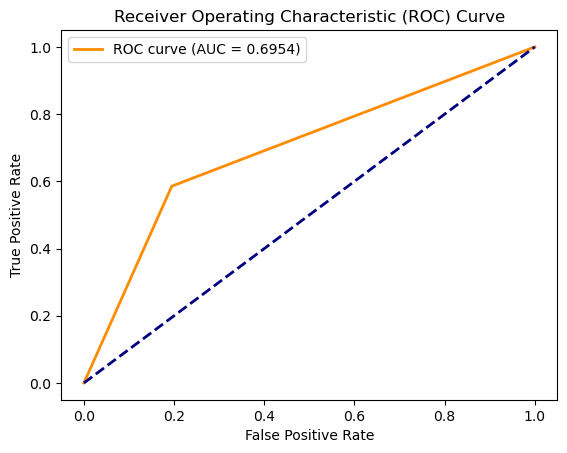

In [184]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_val, hgb.predict(X_val))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [185]:
models = [
    lr_l1, lr_l2, lr_l1_rus, lr_l2_rus,
    dt, dt_rus, rf, rf_rus,
    hgb, hgb_rus, sgd, sgd_rus,
    svc, svc_rus, bnb, bnb_rus,
    gnb, gnb_rus, mlp_rus, knn_rus
]


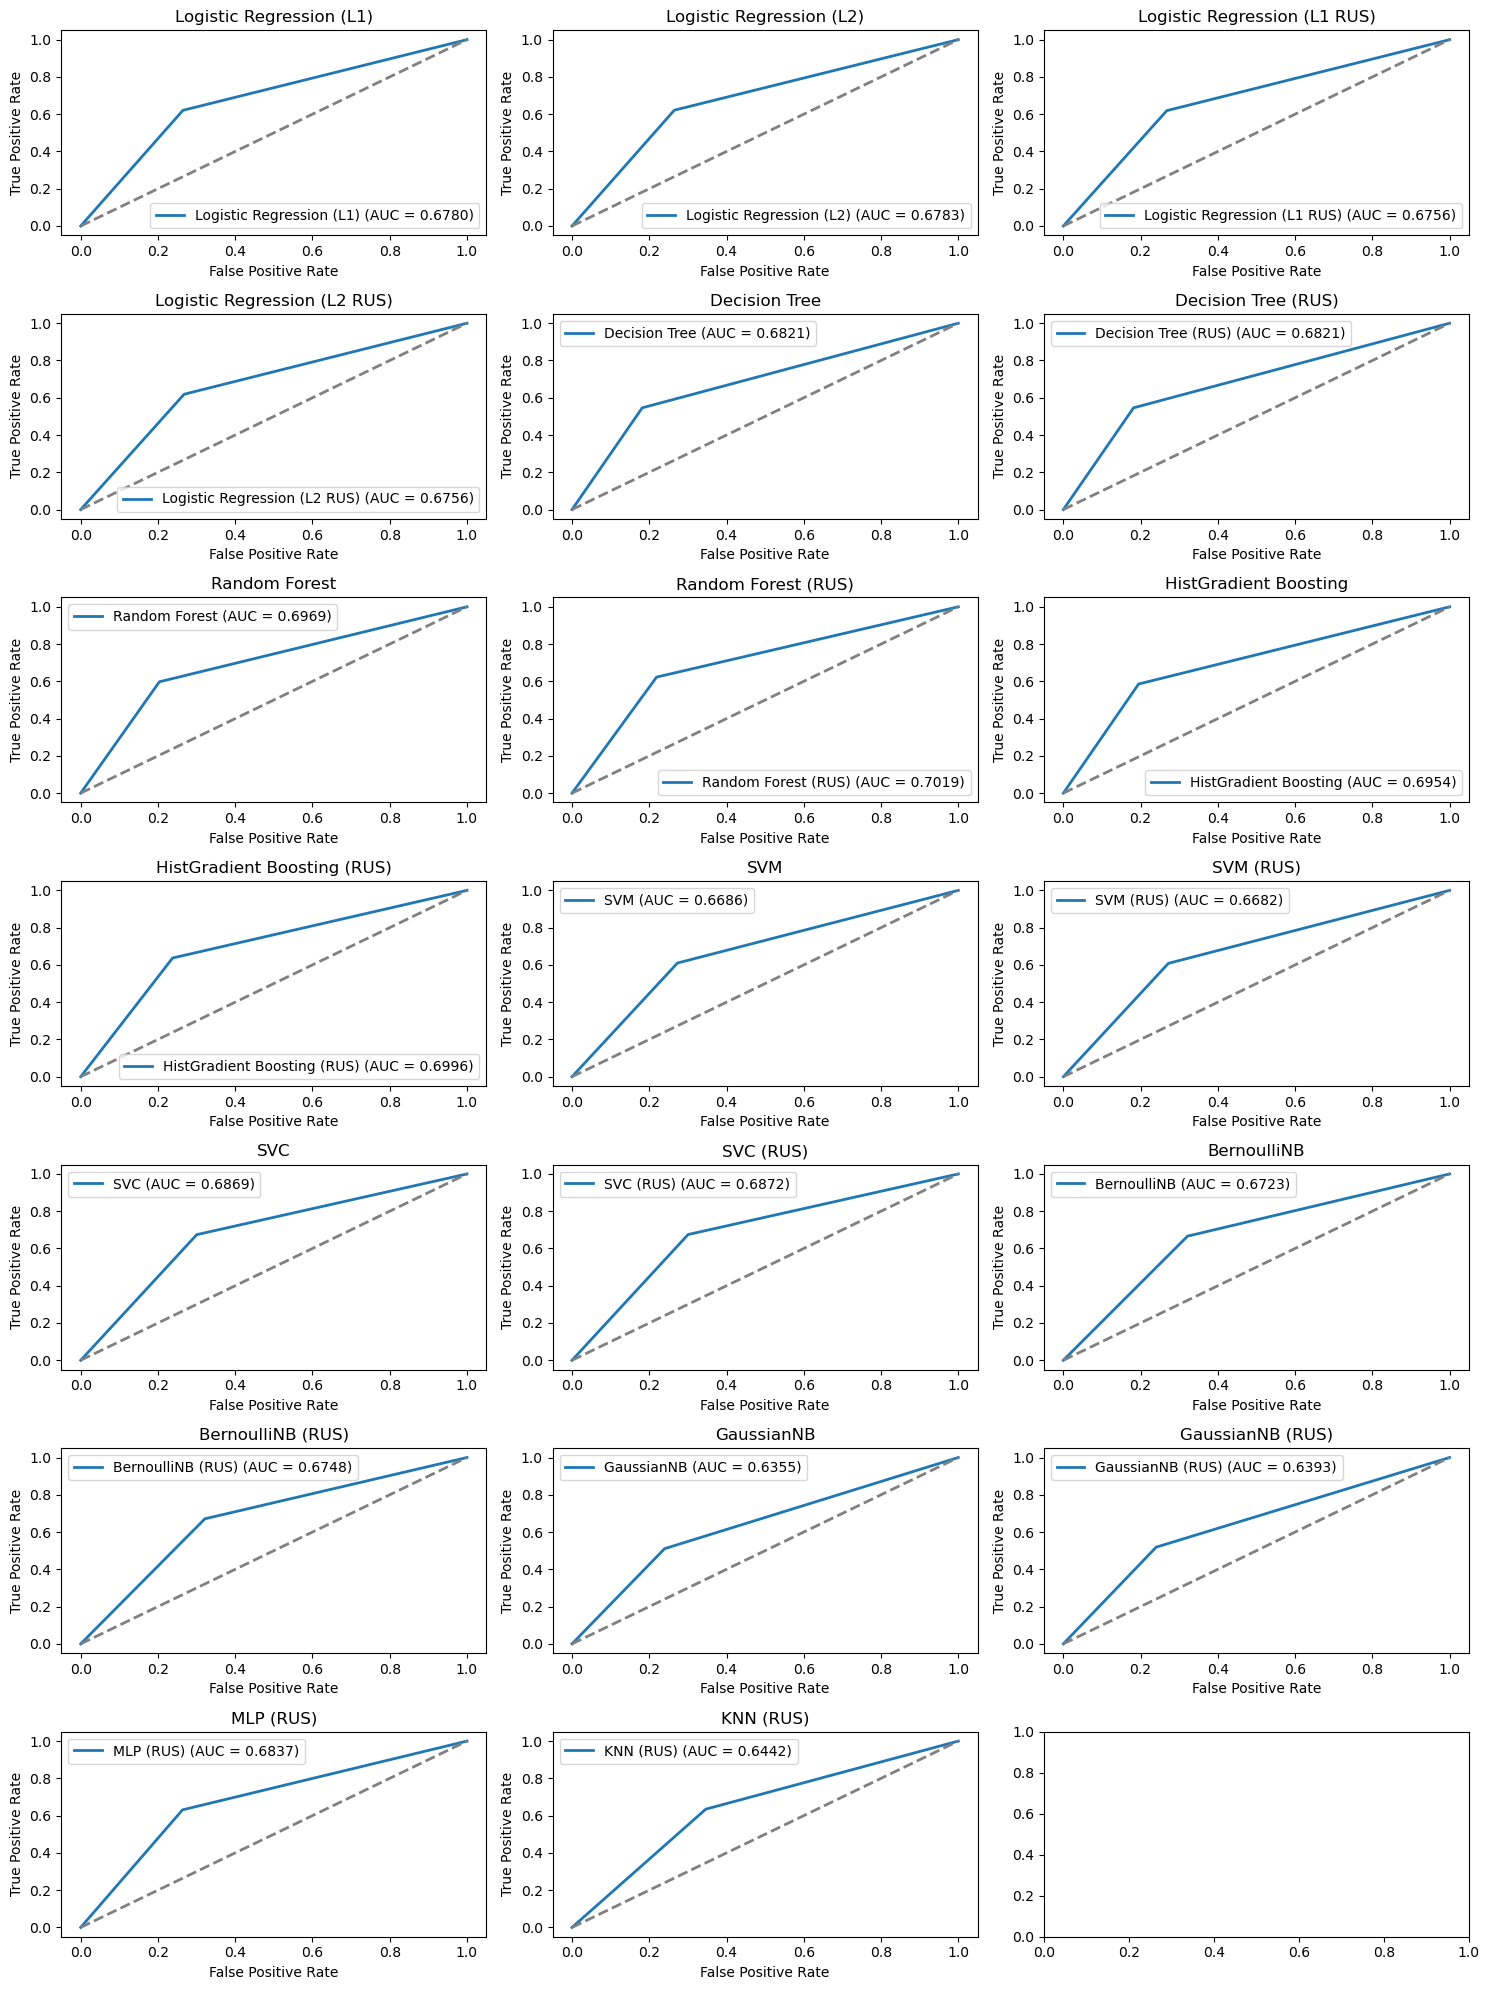

In [188]:
from sklearn.metrics import roc_curve, auc

# Assuming X_val and y_val are your validation set features and labels

# Create a list of model names for labeling in the legend
model_names = [
    'Logistic Regression (L1)', 'Logistic Regression (L2)', 'Logistic Regression (L1 RUS)', 'Logistic Regression (L2 RUS)',
    'Decision Tree', 'Decision Tree (RUS)', 'Random Forest', 'Random Forest (RUS)',
    'HistGradient Boosting', 'HistGradient Boosting (RUS)', 'SGD', 'SGD (RUS)',
    'SVC', 'SVC (RUS)', 'BernoulliNB', 'BernoulliNB (RUS)', 'GaussianNB', 'GaussianNB (RUS)',
    'MLP (RUS)', 'KNN (RUS)'
]

# Create a figure and axis for each model
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(15, 20))
axes = axes.flatten()

# Loop through each model and plot its ROC curve
for i, (model, model_name) in enumerate(zip(models, model_names)):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict(X_val))
    roc_auc = auc(fpr, tpr)
    
    ax = axes[i]
    ax.plot(fpr, tpr, lw=2, label='{} (AUC = {:.4f})'.format(model_name, roc_auc))
    ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax.set_title(model_name)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
